In [236]:
#from lib.connector.S3Connector import S3Connector
import pandas as pd
import random
import warnings
from minio import Minio
import pickle
import numpy as np
import matplotlib.pyplot as plt
import skfda
from scipy.interpolate import interp1d
from scipy import stats 
from skfda.datasets import fetch_growth
from skfda.exploratory.visualization import plot_fpca_perturbation_graphs
from skfda.preprocessing.dim_reduction.projection import FPCA
from skfda.representation.basis import BSpline, Fourier, Monomial
from sklearn import preprocessing
from skfda import FDataGrid
from scipy.interpolate import UnivariateSpline
import datetime
from numpy.linalg import LinAlgError   
from scipy.spatial.distance import minkowski
from sklearn.metrics import mean_squared_error,r2_score
import itertools
import seaborn as sns

# Load config file
# import json
# config = json.load(open('configAMSprocessed10Mar2021.json'))

# Set display params
plt.rcParams["figure.figsize"] = (20,5)
plt.rcParams["figure.max_open_warning"] = 200
warnings.filterwarnings('ignore')

In [237]:
# markers for plots
marker = itertools.cycle(('o', '+', '*', '^')) 

In [238]:
# minioClient= Minio(config['minioClient']['server'], 
#                    access_key=config['minioClient']['key'],
#                    secret_key=config['minioClient']['secret'],
#                    secure=True
#                   )

In [239]:
# #Step 1:# to get pickle file from bucket directory
# bucket=config['data_bucket']['processed']
# folder_prefix_rssi=config['folder_prefix']['acquisition_date']
# #file_patterns = config['file_patterns']['curves']

In [240]:
# create a dataframe for saving the baselines for each tre
tre_baseline_df = pd.DataFrame(columns = ['tre_id','obm_direction','kp_inc','fpca_baseline','fd','fpca_baseline_ant1','fd_ant1','fpca_baseline_ant2','fd_ant2'])
tre_baseline_df['rssi_baseline'] = pd.Series()
tre_baseline_df['fpca_baseline'] = pd.Series()
tre_baseline_df['fd'] = pd.Series()
tre_baseline_df['rssi_baseline_ant1'] = pd.Series()
tre_baseline_df['fpca_baseline_ant1'] = pd.Series()
tre_baseline_df['fd_ant1'] = pd.Series()
tre_baseline_df['rssi_baseline_ant2'] = pd.Series()
tre_baseline_df['fpca_baseline_ant2'] = pd.Series()
tre_baseline_df['fd_ant2'] = pd.Series()
tre_baseline_df = tre_baseline_df.astype(object)

In [241]:
# Load measured functional dataset - connected curves healthy
#br_df = pd.read_pickle(config['curves']['RSSI_BLUE_RED_filtered'],compression="zip")
br_df = pd.read_pickle(r"C:\Users\devakanth.kalapati\Documents\Radioscopy Local\rssi_curves_amd1_115_red_2021-03-16.zip",compression="zip")
# br_df = pickle.loads(minioClient.get_object(bucket_name=bucket, object_name=folder_prefix_rssi+config['curves']['RSSI_cBLUE_RED']).read())
br_df

,primary_mac_address,train_id,obm_direction,date,primary_rssi_dbm,primary_kp,secondary_mac_address,secondary_rssi_dbm,secondary_kp,secondary_connection,ap_mac_address,tre_ap_name,tre_id,ap_physical_name,ap_name_geo,ap_color,ap_kp_in_track,kp_inc,obm_color,report_date
0,00:14:5a:02:31:53,115,Head,2021-03-16 16:1/3,"[-65.1, -63.6, -62.3, -61.2, -60.4, -59.8, -59...","[908142.6, 908169.2, 908187.4, 908223.7, 90824...",00:14:5a:02:3e:ef,"[-57.2, -56.7, -56.5, -56.1, -55.8, -55.5, -55...","[908160.1, 908178.3, 908205.5, 908232.8, 90825...",True,00:14:5a:02:31:53,BLW-HLD_02_BLUE,BLW-HLD_02,BLW-HLD_02_RAP_BLUE,HLD_02_BLUE,BLUE,941500.0,True,RED,2021/07/06 10:14:43
1,00:14:5a:02:31:53,115,Head,2021-03-16 17:1/3,"[-55.0, -54.8, -54.9, -54.7, -54.6, -54.4, -54...","[908325.4, 908345.9, 908366.4, 908386.9, 90840...",00:14:5a:02:3e:ef,"[-54.0, -53.8, -53.7, -53.3, -53.1, -52.8, -52...","[908335.6, 908356.1, 908376.6, 908397.2, 90841...",True,00:14:5a:02:31:53,BLW-HLD_02_BLUE,BLW-HLD_02,BLW-HLD_02_RAP_BLUE,HLD_02_BLUE,BLUE,941500.0,True,RED,2021/07/06 10:14:43
2,00:14:5a:02:31:a1,115,Head,2021-03-16 16:3/3,"[-52.0, -52.0, -52.2, -52.1, -52.3, -52.5, -52...","[1386407.0, 1386384.5, 1386362.0, 1386339.5, 1...",00:14:5a:02:31:f8,"[-48.0, -48.3, -48.3, -48.5, -48.6, -48.7, -48...","[1386395.8, 1386373.2, 1386350.8, 1386328.2, 1...",False,00:14:5a:02:31:a1,LLL-HDS_02_RED,LLL-HDS_02,LLL-HDS_02_RAP_RED,HDS_02_RED,RED,1367500.0,False,RED,2021/07/06 10:14:43
3,00:14:5a:02:31:ac,115,Head,2021-03-16 17:1/3,"[-53.0, -53.0, -52.8, -52.6, -52.5, -52.3, -51...","[1198472.1, 1198414.2, 1198356.3, 1198298.4, 1...",00:14:5a:02:32:09,"[-54.0, -53.8, -53.3, -52.9, -52.6, -52.2, -51...","[1198443.1, 1198385.2, 1198327.3, 1198240.5, 1...",False,00:14:5a:02:31:ac,HVW-ASW_04_RED,HVW-ASW_04,HVW-ASW_04_RAP_RED,ASW_04_RED,RED,1185800.0,False,RED,2021/07/06 10:14:43
4,00:14:5a:02:31:ac,115,Tail,2021-03-16 16:2/3,"[-39.0, -39.2, -39.7, -39.9, -40.2, -40.3, -40...","[1188051.3, 1188114.1, 1188208.4, 1188271.3, 1...",00:14:5a:02:32:09,"[-39.0, -39.2, -39.3, -39.4, -39.5, -39.6, -39...","[1188082.7, 1188145.6, 1188177.0, 1188239.9, 1...",False,00:14:5a:02:31:ac,HVW-ASW_04_RED,HVW-ASW_04,HVW-ASW_04_RAP_RED,ASW_04_RED,RED,1185800.0,True,RED,2021/07/06 10:14:43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,00:14:5a:03:05:f4,115,Head,2021-03-16 16:3/3,"[-59.0, -59.2, -59.1, -59.4, -59.5, -59.7, -59...","[1465059.5, 1465035.7, 1465011.9, 1464976.1, 1...",00:14:5a:02:31:e0,"[-55.0, -55.3, -55.7, -55.9, -56.5, -56.9, -57...","[1465047.6, 1465023.8, 1465000.0, 1464964.2, 1...",False,00:14:5a:03:05:f4,PJW-LLL_02_RED,PJW-LLL_02,PJW-LLL_02_RAP_RED,LLL_02_RED,RED,1433400.0,False,RED,2021/07/06 10:14:43
147,00:14:5a:03:05:f4,115,Tail,2021-03-16 16:2/3,"[-39.0, -39.0, -39.2, -39.3, -39.4, -39.6, -39...","[1434004.6, 1434039.3, 1434091.3, 1434143.3, 1...",00:14:5a:02:31:e0,"[-38.0, -38.2, -38.1, -38.6, -38.5, -38.6, -38...","[1434108.6, 1434160.6, 1434230.0, 1434282.0, 1...",False,00:14:5a:03:05:f4,PJW-LLL_02_RED,PJW-LLL_02,PJW-LLL_02_RAP_RED,LLL_02_RED,RED,1433400.0,True,RED,2021/07/06 10:14:43
148,00:14:5a:03:06:0c,115,Tail,2021-03-16 16:2/3,"[-59.0, -58.2, -57.9, -57.8, -57.5, -57.0, -55...","[604012.2, 604193.1, 604268.5, 604343.9, 60435...",00:14:5a:02:34:f2,"[-62.0, -61.6, -60.6, -59.6, -58.3, -58.4, -57...","[604027.3, 604057.4, 604117.7, 604163.0, 60420...",False,00:14:5a:03:06:0c,OAS-MDW_06_RED,OAS-MDW_06,OAS-MDW_06_RAP_RED,MDW_06_RED,RED,604100.0,True,RED,2021/07/06 10:14:43
149,00:14:5a:03:08:81,115,Head,2021-03-16 17:1/3,"[-55.0, -55.2, -55.3, -55.7, -55.4, -55.4, -55...","[738359.3, 738329.9, 738271.1, 738212.2, 73812...",00:14:5a:02:3f:8e,"[-55.0, -54.6, -54.3, -54.0, -53.8, -53.7, -53...","[738300.5, 738241.6, 738182.8, 738153.4, 73809...",False,00:14:5a:03:08:81,RAI-OAS_04_RED,RAI-OAS_04,RAI-OAS_04_RAP_RED,OAS_04_RED,RED,721600.0,False,RED,2021/07/06 10:14:43


VLN-JLS_02


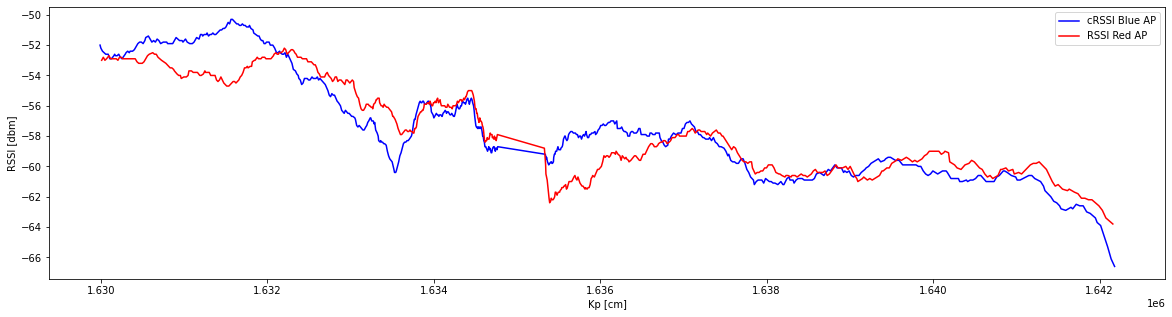

In [242]:
# plot a sample curve
cd = 21
print(br_df['tre_id'][cd])
plt.plot(br_df['primary_kp'][cd],br_df['primary_rssi_dbm'][cd], 'b', label="cRSSI Blue AP") #display a specific curve
plt.plot(br_df['secondary_kp'][cd],br_df['secondary_rssi_dbm'][cd],'r', label="RSSI Red AP")
plt.legend()
plt.ylabel('RSSI [dbm]')
plt.xlabel('Kp [cm]')
plt.show()

In [243]:
# pick few curves per tre/direction/kp_inc for the purpose of testing anomaly detection
br_df[(br_df['tre_id'] == 'WBS-ASA_04') & (br_df['obm_direction'] == 'Head') & (br_df['kp_inc'] == False)]

,primary_mac_address,train_id,obm_direction,date,primary_rssi_dbm,primary_kp,secondary_mac_address,secondary_rssi_dbm,secondary_kp,secondary_connection,ap_mac_address,tre_ap_name,tre_id,ap_physical_name,ap_name_geo,ap_color,ap_kp_in_track,kp_inc,obm_color,report_date


In [275]:
# # get the rows which have to be subset for testing
# test_con = br_df.index.isin([30,31,32,33])

In [276]:
# # subset the df
# br_df_test = br_df[test_con].reset_index(drop = True)
# br_df = br_df[~test_con].reset_index(drop = True)

Register KP for the curves, w.r.t the train. Here we take the Kp of the first curve of a TRE as the reference kp and register it. Later we adjust the kp based on this registered kp.

In [ ]:
# changed the function to accommodate the flipping issue

In [244]:
# registering Kp
def kp_register(df):
    # empty dataframe to register kp
    kp_df = pd.DataFrame(columns = ['tre_id','obm_direction','kp_inc','kp','primary_rssi_dbm','secondary_rssi_dbm','kp_len','kp_max','kp_min'])
    kp_df['kp'] = pd.Series()
    kp_df['kp_ant1'] = pd.Series()
    kp_df['kp_ant2'] = pd.Series()
    kp_df['primary_rssi_dbm'] = pd.Series()
    kp_df['secondary_rssi_dbm'] = pd.Series()
    kp_df['primary_rssi_dbm_ant1'] = pd.Series()
    kp_df['primary_rssi_dbm_ant2'] = pd.Series()
    kp_df = kp_df.astype(object)
    
    for tre,direction,kp_inc,pkp,skp,prssi,srssi in zip(df['tre_id'],df['obm_direction'],df['kp_inc'],df['primary_kp'],df['secondary_kp'],df['primary_rssi_dbm'],df['secondary_rssi_dbm']):
        ref_df = kp_df[(kp_df['tre_id'] == tre) & (kp_df['obm_direction'] == direction) & (kp_df['kp_inc'] == kp_inc)]
        ref_kp = kp_df.loc[(kp_df['tre_id'] == tre) & (kp_df['obm_direction'] == direction) & (kp_df['kp_inc'] == kp_inc),'kp']
        
        if ref_df.empty:
            temp_kp_df = pd.DataFrame({'tre_id' : 1,'obm_direction' : 2, 'kp_inc' : 3, 'kp' : 4},index=[0])
            temp_kp_df['kp'] = pd.Series()
            temp_kp_df['kp_ant1'] = pd.Series()
            temp_kp_df['kp_ant2'] = pd.Series()
            temp_kp_df['primary_rssi_dbm'] = pd.Series()
            temp_kp_df['secondary_rssi_dbm'] = pd.Series()
            temp_kp_df['primary_rssi_dbm_ant1'] = pd.Series()
            temp_kp_df['primary_rssi_dbm_ant2'] = pd.Series()
            temp_kp_df = temp_kp_df.astype(object)

            temp_kp_df.at[0,'tre_id'] = tre
            temp_kp_df.at[0,'obm_direction'] = direction
            temp_kp_df.at[0,'kp_inc'] = kp_inc
            
            
            if kp_inc == False:
                pkp=np.flip(pkp)
                skp=np.flip(skp)
                prssi=np.flip(prssi)
                srssi=np.flip(srssi)
                
        
            f = interp1d(skp, srssi,fill_value="extrapolate")
            isrssi=f(pkp)
            
            
            pmax_index = np.argmax(prssi)
            pkp_peak = pkp[pmax_index]

            prssi_ant1 = prssi[:pmax_index+1]
            prssi_ant2 = prssi[pmax_index+1:]

            if kp_inc == True:
                pkp_ant1 = pkp[pkp <= pkp_peak]
                pkp_ant2 = pkp[pkp > pkp_peak]

            if kp_inc == False:
                pkp_ant1 = pkp[pkp >= pkp_peak]
                pkp_ant2 = pkp[pkp < pkp_peak]

            # calculate distance of primary kp
            pkp_len = abs(max(pkp) - min(pkp))
            
            temp_kp_df.at[0,'kp'] = pkp
            temp_kp_df.at[0,'kp_ant1'] = pkp_ant1
            temp_kp_df.at[0,'kp_ant2'] = pkp_ant2
            temp_kp_df.at[0,'kp_len'] = pkp_len
            temp_kp_df.at[0,'kp_max'] = max(pkp)
            temp_kp_df.at[0,'kp_min'] = min(pkp)
            temp_kp_df.at[0,'primary_rssi_dbm'] = prssi
            temp_kp_df.at[0,'primary_rssi_dbm_ant1'] = prssi_ant1
            temp_kp_df.at[0,'primary_rssi_dbm_ant2'] = prssi_ant2
            temp_kp_df.at[0,'secondary_rssi_dbm'] = isrssi
            
            kp_df=kp_df.append(temp_kp_df, ignore_index=True) 
            
        elif (abs(max(ref_kp.values[0]) - min(ref_kp.values[0])) > pkp_len):
            
            if kp_inc == False:
                pkp=np.flip(pkp)
                skp=np.flip(skp)
                prssi=np.flip(prssi)
                srssi=np.flip(srssi)
        
            f = interp1d(skp, srssi,fill_value="extrapolate")
            isrssi=f(pkp)
            
            kp_ind = ref_df.index[0]
            kp_df.at[kp_ind,'kp'] = pkp
            kp_df.at[kp_ind,'kp_ant1'] = pkp_ant1
            kp_df.at[kp_ind,'kp_ant2'] = pkp_ant2
            kp_df.at[kp_ind,'kp_len'] = pkp_len
            kp_df.at[kp_ind,'kp_max'] = max(pkp)
            kp_df.at[kp_ind,'kp_min'] = min(pkp)
            kp_df.at[kp_ind,'primary_rssi_dbm'] = prssi
            kp_df.at[kp_ind,'primary_rssi_dbm_ant1'] = prssi_ant1
            kp_df.at[kp_ind,'primary_rssi_dbm_ant2'] = prssi_ant2
            kp_df.at[kp_ind,'secondary_rssi_dbm'] = isrssi
        
        else:
            print('Kp already registered for:',tre,direction,kp_inc)

    return kp_df

In [245]:
kp_df = kp_register(br_df)

Kp already registered for: BLW-HLD_02 Head True
Kp already registered for: RGB-GN_02 Head True
Kp already registered for: HLD-RGB_04 Head True
Kp already registered for: HLD-RGB_03 Head True
Kp already registered for: HLD-RGB_01B Head True
Kp already registered for: RGB-GN_01B Head True
Kp already registered for: RGB-GN_03 Head True
Kp already registered for: BMR-BLW_02 Head True
Kp already registered for: BMR-BLW_01B Head True
Kp already registered for: HLD-RGB_02 Head True
Kp already registered for: HLD-RGB_05 Head True
Kp already registered for: BMR-BLW_03 Head True
Kp already registered for: MDW-DVD_04 Head True
Kp already registered for: SVT-BMR_03 Head True
Kp already registered for: GN-GN_01 Head True
Kp already registered for: DVD-SVT_03 Head True
Kp already registered for: SVT-BMR_04 Head True
Kp already registered for: MDW-DVD_05 Head True


In [246]:
kp_df

,tre_id,obm_direction,kp_inc,kp,primary_rssi_dbm,secondary_rssi_dbm,kp_len,kp_max,kp_min,kp_ant1,kp_ant2,primary_rssi_dbm_ant1,primary_rssi_dbm_ant2
0,BLW-HLD_02,Head,True,"[908142.6, 908169.2, 908187.4, 908223.7, 90824...","[-65.1, -63.6, -62.3, -61.2, -60.4, -59.8, -59...","[-57.68076923076739, -56.9500000000016, -56.63...",40048.4,948191.0,908142.6,"[908142.6, 908169.2, 908187.4, 908223.7, 90824...","[940201.9, 940260.4, 940318.9, 940377.5, 94046...","[-65.1, -63.6, -62.3, -61.2, -60.4, -59.8, -59...","[-35.4, -35.8, -36.4, -37.1, -37.7, -38.2, -38..."
1,LLL-HDS_02,Head,False,"[1360613.5, 1360675.3, 1360767.9, 1360829.7, 1...","[-63.7, -63.5, -63.4, -63.3, -63.1, -63.3, -63...","[-62.0, -62.0, -61.80032414910965, -61.6999999...",25793.5,1386407.0,1360613.5,"[1369103.2, 1369155.8, 1369182.1, 1369208.4, 1...","[1360613.5, 1360675.3, 1360767.9, 1360829.7, 1...","[-63.7, -63.5, -63.4, -63.3, -63.1, -63.3, -63...","[-39.1, -39.2, -39.2, -39.2, -39.4, -39.5, -39..."
2,HVW-ASW_04,Head,False,"[1177306.4, 1177388.5, 1177429.6, 1177511.7, 1...","[-65.7, -65.6, -65.6, -65.1, -64.8, -65.0, -64...","[-65.76655844155835, -65.63327922077917, -65.5...",21165.7,1198472.1,1177306.4,"[1187383.4, 1187445.6, 1187507.8, 1187569.9, 1...","[1177306.4, 1177388.5, 1177429.6, 1177511.7, 1...","[-65.7, -65.6, -65.6, -65.1, -64.8, -65.0, -64...","[-40.9, -40.9, -41.1, -41.1, -41.1, -41.1, -41..."
3,HVW-ASW_04,Tail,True,"[1188051.3, 1188114.1, 1188208.4, 1188271.3, 1...","[-39.0, -39.2, -39.7, -39.9, -40.2, -40.3, -40...","[-38.90015898251244, -39.0998410174883, -39.34...",21067.2,1209118.5,1188051.3,[1188051.3],"[1188114.1, 1188208.4, 1188271.3, 1188334.1, 1...",[-39.0],"[-39.2, -39.7, -39.9, -40.2, -40.3, -40.4, -40..."
4,HVW-ASW_03,Head,False,"[1199528.3, 1199562.4, 1199664.6, 1199732.8, 1...","[-66.0, -66.0, -65.9, -65.7, -65.8, -65.4, -65...","[-66.8, -66.8, -66.69999999999965, -66.4999999...",24656.0,1224184.3,1199528.3,"[1205849.6, 1205879.4, 1205968.6, 1205998.3, 1...","[1199528.3, 1199562.4, 1199664.6, 1199732.8, 1...","[-66.0, -66.0, -65.9, -65.7, -65.8, -65.4, -65...","[-31.1, -31.7, -32.2, -32.9, -33.4, -33.7, -33..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
128,PJW-LLL_02,Head,False,"[1423033.0, 1423093.0, 1423173.0, 1423233.0, 1...","[-65.7, -65.4, -65.3, -65.2, -65.1, -65.2, -65...","[-64.0, -64.0, -64.0, -63.9, -63.9, -63.9, -63...",42026.5,1465059.5,1423033.0,"[1434425.5, 1434465.0, 1434504.6, 1434544.2, 1...","[1423033.0, 1423093.0, 1423173.0, 1423233.0, 1...","[-65.7, -65.4, -65.3, -65.2, -65.1, -65.2, -65...","[-40.5, -40.6, -40.6, -40.6, -40.7, -40.6, -40..."
129,PJW-LLL_02,Tail,True,"[1434004.6, 1434039.3, 1434091.3, 1434143.3, 1...","[-39.0, -39.0, -39.2, -39.3, -39.4, -39.6, -39...","[-37.599999999999994, -37.733461538461356, -37...",29447.9,1463452.5,1434004.6,[1434004.6],"[1434039.3, 1434091.3, 1434143.3, 1434212.6, 1...",[-39.0],"[-39.0, -39.2, -39.3, -39.4, -39.6, -39.5, -39..."
130,OAS-MDW_06,Tail,True,"[604012.2, 604193.1, 604268.5, 604343.9, 60435...","[-59.0, -58.2, -57.9, -57.8, -57.5, -57.0, -55...","[-62.20066445182864, -58.734292035398006, -58....",24447.2,628459.4,604012.2,"[604012.2, 604193.1, 604268.5, 604343.9, 60435...","[605533.1, 605562.1, 605634.6, 605678.0, 60572...","[-59.0, -58.2, -57.9, -57.8, -57.5, -57.0, -55...","[-42.1, -42.2, -42.3, -42.6, -42.8, -43.0, -43..."
131,RAI-OAS_04,Head,False,"[712982.9, 713038.8, 713094.6, 713150.5, 71320...","[-63.7, -63.4, -63.1, -62.9, -62.7, -62.8, -62...","[-64.24991055456185, -64.14991055456163, -63.9...",25376.4,738359.3,712982.9,"[724037.8, 724085.2, 724132.8, 724180.2, 72422...","[712982.9, 713038.8, 713094.6, 713150.5, 71320...","[-63.7, -63.4, -63.1, -62.9, -62.7, -62.8, -62...","[-42.2, -42.0, -42.2, -42.3, -42.1, -42.2, -42..."


In [247]:
# select a random acquisition
sid = 50
tre_s = br_df['tre_id'].iloc[sid]
direction_s = br_df['obm_direction'].iloc[sid]
kp_inc_s = br_df['kp_inc'].iloc[sid]

In [248]:
# subset with the respective treid,direction,kp inc flag
sample_df = br_df[(br_df['tre_id'] == tre_s) & (br_df['obm_direction'] == direction_s) & (br_df['kp_inc'] == kp_inc_s)] 
sample_df

,primary_mac_address,train_id,obm_direction,date,primary_rssi_dbm,primary_kp,secondary_mac_address,secondary_rssi_dbm,secondary_kp,secondary_connection,ap_mac_address,tre_ap_name,tre_id,ap_physical_name,ap_name_geo,ap_color,ap_kp_in_track,kp_inc,obm_color,report_date
50,00:14:5a:02:34:8d,115,Tail,2021-03-16 16:3/3,"[-53.0, -53.0, -53.0, -53.4, -54.0, -54.3, -54...","[1783583.2, 1783632.0, 1783680.7, 1783729.5, 1...",00:14:5a:02:34:8c,"[-54.0, -54.2, -54.4, -54.5, -54.7, -54.6, -54...","[1783607.6, 1783656.3, 1783705.1, 1783753.9, 1...",False,00:14:5a:02:34:8d,ITW-STD_06_RED,ITW-STD_06,ITW-STD_06_RAP_RED,STD_06_RED,RED,1775600.0,True,RED,2021/07/06 10:14:43


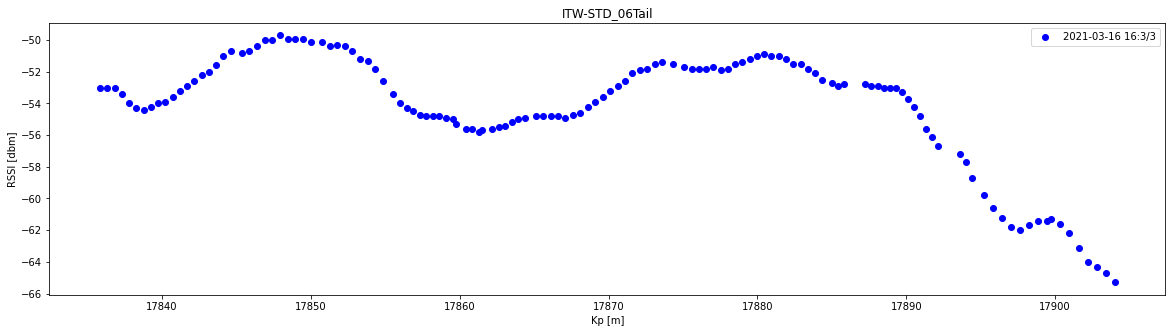

In [133]:
# plot the curves
for i in range(len(sample_df)):
    plt.plot(sample_df['primary_kp'].iloc[i]/100,sample_df['primary_rssi_dbm'].iloc[i], marker = next(marker),color = 'b', label = sample_df['date'].iloc[i],linestyle='')
    plt.legend()
    plt.title(sample_df['tre_id'].iloc[i] + sample_df['obm_direction'].iloc[i])
    plt.ylabel('RSSI [dbm]')
    plt.xlabel('Kp [m]') 
    plt.show()

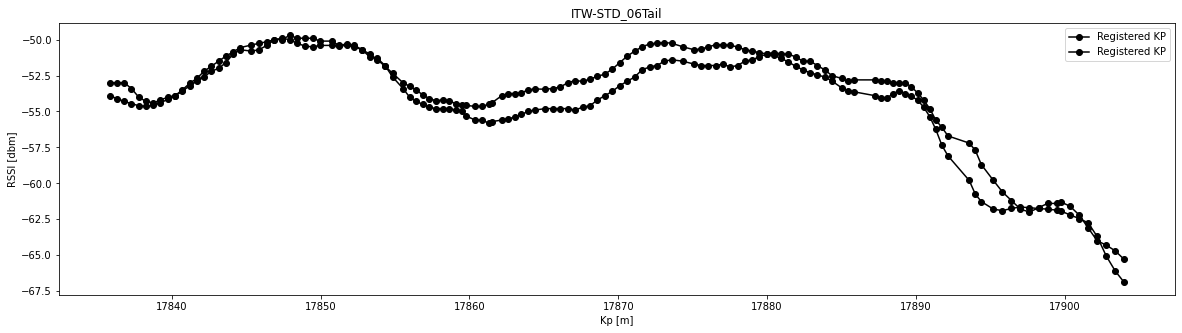

In [134]:
# plot the registered kp for the selected tre,direction,kp inc flag
sample_registered = kp_df[(kp_df['tre_id'] == tre_s) & (kp_df['obm_direction'] == direction_s) & (kp_df['kp_inc'] == kp_inc_s)]

plt.plot(sample_registered['kp'].iloc[0]/100,sample_registered['primary_rssi_dbm'].iloc[0], marker = 'o',color = 'k', label = 'Registered KP')
plt.plot(sample_registered['kp'].iloc[0]/100,sample_registered['secondary_rssi_dbm'].iloc[0], marker = 'o',color = 'k', label = 'Registered KP')

plt.legend()
plt.title(sample_df['tre_id'].iloc[0] + sample_df['obm_direction'].iloc[0])
plt.ylabel('RSSI [dbm]')
plt.xlabel('Kp [m]') 
plt.show()

Interpolation of the Primary RSSI and kp based on the registered kp

In [ ]:
# remove the flipping of registered kp 

In [135]:
def interp_primary_rssi(row,kp_df): 
    
    tre = row['tre_id']
    direction = row['obm_direction']
    kp_inc = row['kp_inc']
    
    ref_kp = kp_df.loc[(kp_df['tre_id'] == tre) & (kp_df['obm_direction'] == direction) & (kp_df['kp_inc'] == kp_inc),'kp']
    kp_limit = kp_df.loc[(kp_df['tre_id'] == tre) & (kp_df['obm_direction'] == direction) & (kp_df['kp_inc'] == kp_inc),['kp_max','kp_min']]
    
    kp_max = kp_limit['kp_max'].values[0]
    kp_min = kp_limit['kp_min'].values[0]
            
    reg_kp = ref_kp.values[0]
    pkp = row['primary_kp']
    
    ind = np.where((pkp <= kp_max) & (pkp >=kp_min))
    
    pkp = pkp[ind]
    prssi = row['primary_rssi_dbm']
    prssi = prssi[ind]

    if np.any(prssi):
        
        if row['kp_inc']==False:
#             reg_kp=np.flip(reg_kp)
            pkp=np.flip(pkp)
            prssi=np.flip(prssi)
        
        
        f = interp1d(pkp, prssi,fill_value='extrapolate')
        iprssi=f(reg_kp)

        if row['kp_inc']==False:
            reg_kp=np.flip(reg_kp)
            pkp=np.flip(pkp)
            iprssi=np.flip(iprssi)
    else:
        iprssi = np.nan
        
    
    return reg_kp,iprssi

In [136]:
# apply function
a,b=zip(*br_df.apply(lambda x : interp_primary_rssi(x,kp_df), axis=1))

In [137]:
# assign kp and rssi
br_df['primary_kp'] = list(a)
br_df['primary_rssi_dbm'] = list(b)

In [138]:
# drop the curves which have RSSI nan 
br_df = br_df[br_df['primary_rssi_dbm'].notna()].reset_index(drop = True)

In [139]:
# check the interpolated RSSI and Kp for the selected tre,direction,kp increasing flag
ta = br_df[(br_df['tre_id'] == tre_s) & (br_df['obm_direction'] == direction_s) & (br_df['kp_inc'] == kp_inc_s)] 
ta

,primary_mac_address,train_id,obm_direction,date,primary_rssi_dbm,primary_kp,secondary_mac_address,secondary_rssi_dbm,secondary_kp,secondary_connection,ap_mac_address,tre_ap_name,tre_id,ap_physical_name,ap_name_geo,ap_color,ap_kp_in_track,kp_inc,obm_color,report_date
50,00:14:5a:02:34:8d,115,Tail,2021-03-16 16:3/3,"[-53.0, -53.0, -53.0, -53.4, -54.0, -54.3, -54...","[1783583.2, 1783632.0, 1783680.7, 1783729.5, 1...",00:14:5a:02:34:8c,"[-54.0, -54.2, -54.4, -54.5, -54.7, -54.6, -54...","[1783607.6, 1783656.3, 1783705.1, 1783753.9, 1...",False,00:14:5a:02:34:8d,ITW-STD_06_RED,ITW-STD_06,ITW-STD_06_RAP_RED,STD_06_RED,RED,1775600.0,True,RED,2021/07/06 10:14:43


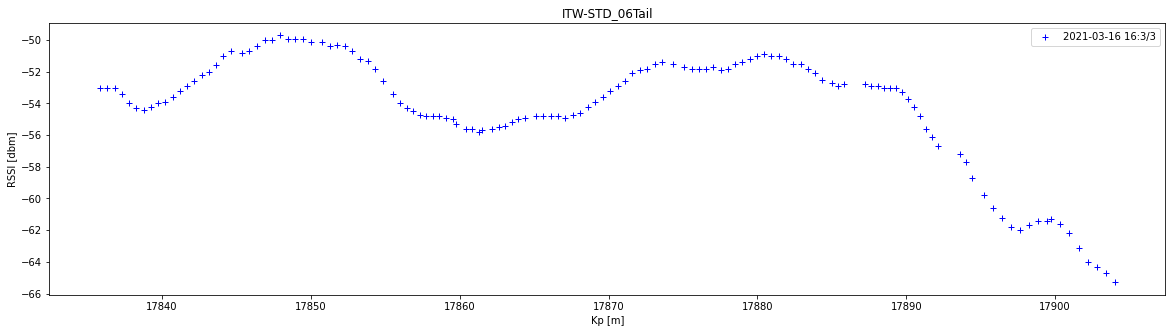

In [140]:
# plot the curves
for i in range(len(ta)):
    plt.plot(ta['primary_kp'].iloc[i]/100,ta['primary_rssi_dbm'].iloc[i], marker = next(marker),color = 'b', label = ta['date'].iloc[i],linestyle='')
    plt.legend()
    plt.title(ta['tre_id'].iloc[i] + ta['obm_direction'].iloc[i])
    plt.ylabel('RSSI [dbm]')
    plt.xlabel('Kp [m]') 

Interpolate secondary Kp and RSSI based on primary kp and RSSI 

In [141]:
def interp_secondary_rssi(row):
    
    pkp = row['primary_kp'] 
    skp = row['secondary_kp']
    srssi = row['secondary_rssi_dbm']
    #if (len(rkp)>len(kp)):
    #    rkp=rkp[:len(kp)]
     #   rrssi=rrssi[:len(kp)]
    #print(len(rkp))
    if row['kp_inc']==False:
        skp=np.flip(skp)
        srssi=np.flip(srssi)
        pkp=np.flip(pkp)
        
    f = interp1d(skp, srssi,fill_value="extrapolate")
    isrssi=f(pkp)
    
    if row['kp_inc']==False:
        isrssi=np.flip(isrssi)
        pkp=np.flip(pkp)
        
    return pkp,isrssi

In [142]:
# apply function
a,b=zip(*br_df.apply(lambda x : interp_secondary_rssi(x), axis=1))

In [143]:
# assign new secondary kp and rssi
br_df['secondary_kp'] = list(a)
br_df['secondary_rssi_dbm'] = list(b)

In [144]:
# select tre, direction, kp increasing flag to plot primary and secondary curves
tc = br_df[(br_df['tre_id'] == tre_s) & (br_df['obm_direction'] == direction_s) & (br_df['kp_inc'] == kp_inc_s)] 
tc

,primary_mac_address,train_id,obm_direction,date,primary_rssi_dbm,primary_kp,secondary_mac_address,secondary_rssi_dbm,secondary_kp,secondary_connection,ap_mac_address,tre_ap_name,tre_id,ap_physical_name,ap_name_geo,ap_color,ap_kp_in_track,kp_inc,obm_color,report_date
50,00:14:5a:02:34:8d,115,Tail,2021-03-16 16:3/3,"[-53.0, -53.0, -53.0, -53.4, -54.0, -54.3, -54...","[1783583.2, 1783632.0, 1783680.7, 1783729.5, 1...",00:14:5a:02:34:8c,"[-53.89979466119029, -54.10020533880875, -54.2...","[1783583.2, 1783632.0, 1783680.7, 1783729.5, 1...",False,00:14:5a:02:34:8d,ITW-STD_06_RED,ITW-STD_06,ITW-STD_06_RAP_RED,STD_06_RED,RED,1775600.0,True,RED,2021/07/06 10:14:43


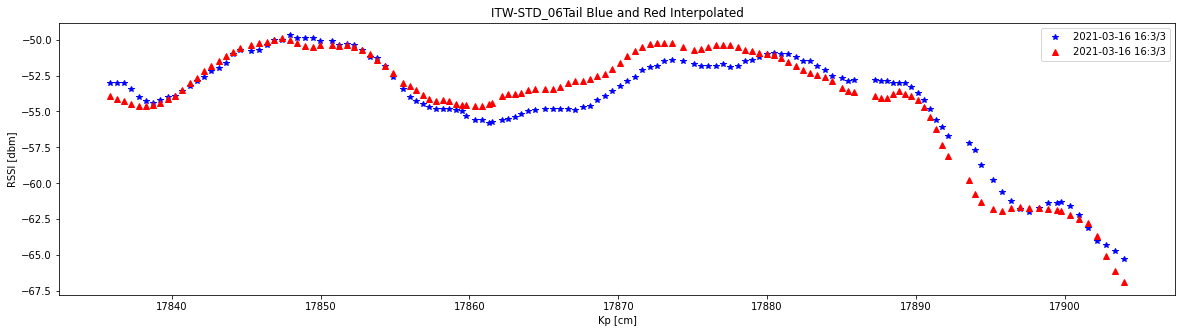

In [145]:
# plot the curves
for i in range(len(tc)):
    plt.plot(tc['primary_kp'].iloc[i]/100,tc['primary_rssi_dbm'].iloc[i], marker = next(marker),color = 'b', label = tc['date'].iloc[i],linestyle='')
    plt.plot(tc['secondary_kp'].iloc[i]/100,tc['secondary_rssi_dbm'].iloc[i], marker = next(marker),color = 'r', label = tc['date'].iloc[i],linestyle='')
    plt.legend()
    plt.title(tc['tre_id'].iloc[i] + tc['obm_direction'].iloc[i] + ' Blue and Red Interpolated')
    plt.ylabel('RSSI [dbm]')
    plt.xlabel('Kp [cm]')  

In [146]:
# number of curves per tre,direction,kp inc
br_df.groupby(['tre_id','obm_direction','kp_inc'])['tre_id'].count().head()

tre_id     obm_direction  kp_inc
ASW-ZD_01  Tail           True      1
ASW-ZD_02  Head           False     1
ASW-ZD_04  Tail           True      1
ASW-ZD_08  Tail           True      1
ASW-ZD_09  Head           False     1
Name: tre_id, dtype: int64

Filter curves using kalman filter. In some scenarios we need to change the estimate of variance to tweak the noise factor in the curves

In [147]:
#function for kalman filter
def kalman_filter(data):
    # intial parameters
    n_iter = len(data)
    sz = (n_iter,) # size of array
    x = -0.37727 # truth value 
    z = np.array(data) # observations (normal about x, sigma=0.1)

    Q = 1e-5 # process variance

    # allocate space for arrays
    xhat=np.zeros(sz)      # a posteri estimate of x
    P=np.zeros(sz)         # a posteri error estimate
    xhatminus=np.zeros(sz) # a priori estimate of x
    Pminus=np.zeros(sz)    # a priori error estimate
    K=np.zeros(sz)         # gain or blending factor

    R = 0.1**5 # estimate of measurement variance, change to see effect

    # intial guesses
    xhat[0] = 0
    P[0] = 1.0

    for k in range(1,n_iter):
        # time update
        xhatminus[k] = xhat[k-1]
        Pminus[k] = P[k-1]+Q

        # measurement update
        K[k] = Pminus[k]/( Pminus[k]+R )
        xhat[k] = xhatminus[k]+K[k]*(z[k]-xhatminus[k])
        P[k] = (1-K[k])*Pminus[k]
        
    xhat[0] = data[0]
    return xhat

In [148]:
# function to apply kalman filter function
def kalman_rssi(row):
    prssi = row['primary_rssi_dbm']
    srssi = row['secondary_rssi_dbm']
    
    prssi_kalman = kalman_filter(prssi)
    srssi_kalman = kalman_filter(srssi)
    
    return prssi_kalman, srssi_kalman

Text(0.5, 1.0, 'Before applying kalman filter')

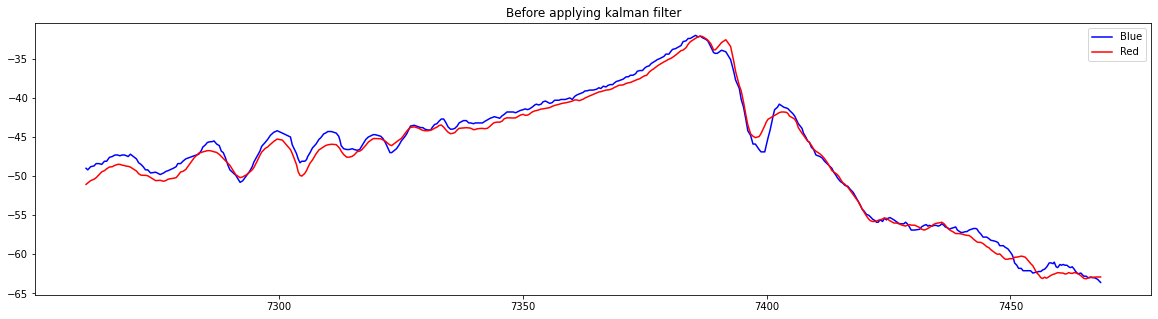

In [149]:
# select a random curve to visualize the curves to compare the effect of kalman filter
sid = 123
plt.plot(br_df['primary_kp'].iloc[sid]/100,br_df['primary_rssi_dbm'].iloc[sid],'-',color = 'b', label = 'Blue')
plt.plot(br_df['secondary_kp'].iloc[sid]/100,br_df['secondary_rssi_dbm'].iloc[sid],'-', color = 'r', label = 'Red')
plt.legend()
plt.title('Before applying kalman filter')

In [150]:
# get kalman filtered rssi
a,b=zip(*br_df.apply(lambda x : kalman_rssi(x), axis=1))
br_df['primary_rssi_dbm'] = list(a)
br_df['secondary_rssi_dbm'] = list(b)

Text(0.5, 1.0, 'After applying kalman filter')

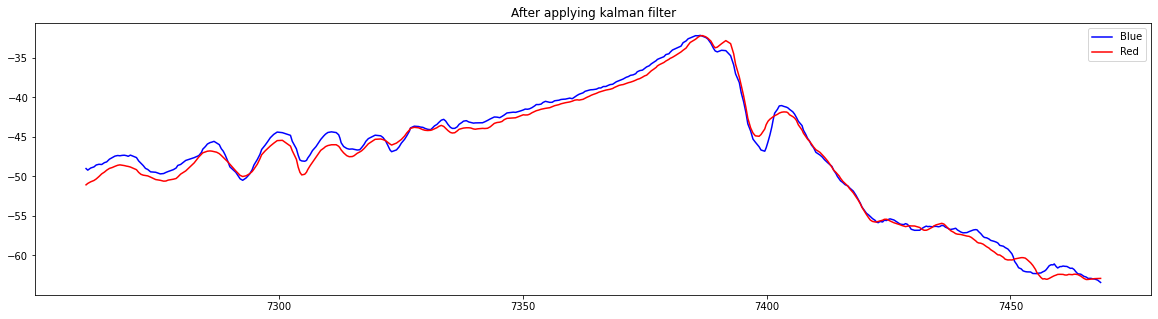

In [151]:
# select a random curve to visualize the curves to compare the effect of kalman filter
sid = 123
plt.plot(br_df['primary_kp'].iloc[sid]/100,br_df['primary_rssi_dbm'].iloc[sid],'-',color = 'b', label = 'Blue')
plt.plot(br_df['secondary_kp'].iloc[sid]/100,br_df['secondary_rssi_dbm'].iloc[sid],'-', color = 'r', label = 'Red')
plt.legend()
plt.title('After applying kalman filter')

Flip the KP wherever it is decreasing, to always have an increasing KP

In [152]:
# Interpolate to have same number of equidistant points for red and blue (retain the number)
def flip_kp(row):
    pkp = row['primary_kp'] 
    prssi = row['primary_rssi_dbm']
    srssi = row['secondary_rssi_dbm']
    
    try:
        if row['kp_inc']==False:
            pkp=np.flip(pkp)
            prssi=np.flip(prssi)
            srssi=np.flip(srssi)      
            
        return pkp, prssi, srssi
    
    except ValueError:
        pkp = np.nan
        prssi = np.nan
        srssi = np.nan
        
        return pkp, prssi, srssi

In [153]:
a,b,c=zip(*br_df.apply(lambda x : flip_kp(x), axis=1))
br_df['kp'] = list(a)
br_df['primary_rssi'] = list(b)
br_df['secondary_rssi'] = list(c)

In [154]:
# function to find the peak and split the rssi curves based on the peak
def find_peak_rssi_split(row):
    pkp = row['primary_kp']
    prssi_kalman = row['primary_rssi_dbm']
    skp = row['secondary_kp']
    srssi_kalman = row['secondary_rssi_dbm']
    
    pmax_index = np.argmax(prssi_kalman)
    pkp_peak = pkp[pmax_index]
    
    prssi_ant1 = prssi_kalman[:pmax_index+1]
    prssi_ant2 = prssi_kalman[pmax_index+1:]
    
    smax_index = np.argmax(srssi_kalman)
    skp_peak = skp[smax_index]
    
    srssi_ant1 = srssi_kalman[:smax_index+1]
    srssi_ant2 = srssi_kalman[smax_index+1:]
    
    return pkp_peak, skp_peak, prssi_ant1, prssi_ant2, srssi_ant1, srssi_ant2

In [155]:
# add changes to the data
a,b,c,d,e,f=zip(*br_df.apply(lambda x : find_peak_rssi_split(x), axis=1))
br_df["primary_kp_peak"] = list(a)
br_df["secondary_kp_peak"] = list(b)
br_df["primary_rssi_dbm_ant1"] = list(c)
br_df["primary_rssi_dbm_ant2"] = list(d)
br_df["secondary_rssi_dbm_ant1"] = list(e)
br_df["secondary_rssi_dbm_ant2"] = list(f)

In [156]:
# function to split the kp in track w.r.t peak
def split_kp(row):
    pkp = row['primary_kp']
    skp = row['secondary_kp']
    kp_inc = row['kp_inc']
    
    if kp_inc == True:
        p_antenna1 = pkp[pkp <= row['primary_kp_peak']]
        p_antenna2 = pkp[pkp > row['primary_kp_peak']]

        s_antenna1 = skp[skp <= row['secondary_kp_peak']]
        s_antenna2 = skp[skp > row['secondary_kp_peak']]

    if kp_inc == False:
        p_antenna1 = pkp[pkp >= row['primary_kp_peak']]
        p_antenna2 = pkp[pkp < row['primary_kp_peak']]

        s_antenna1 = skp[skp >= row['secondary_kp_peak']]
        s_antenna2 = skp[skp < row['secondary_kp_peak']]
    
    return p_antenna1,p_antenna2,s_antenna1,s_antenna2

In [157]:
# apply function
a, b, c, d = zip(*br_df.apply(lambda x : split_kp(x), axis=1))
# add changes to the data 
br_df["primary_kp_ant1"] = list(a)
br_df["primary_kp_ant2"] = list(b)
br_df["secondary_kp_ant1"] = list(c)
br_df["secondary_kp_ant2"] = list(d)

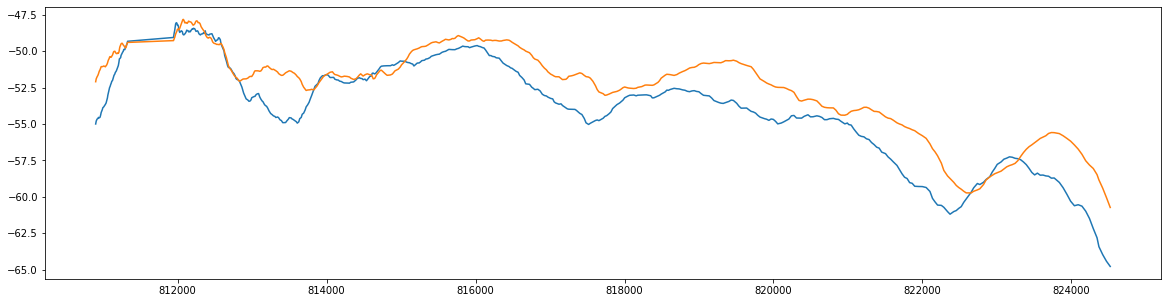

In [158]:
# sample curve
sid = 145
plt.plot(br_df['primary_kp'].iloc[sid],br_df['primary_rssi_dbm'].iloc[sid])
plt.plot(br_df['secondary_kp'].iloc[sid],br_df['secondary_rssi_dbm'].iloc[sid])

Text(0.5, 1.0, 'Antenna 1')

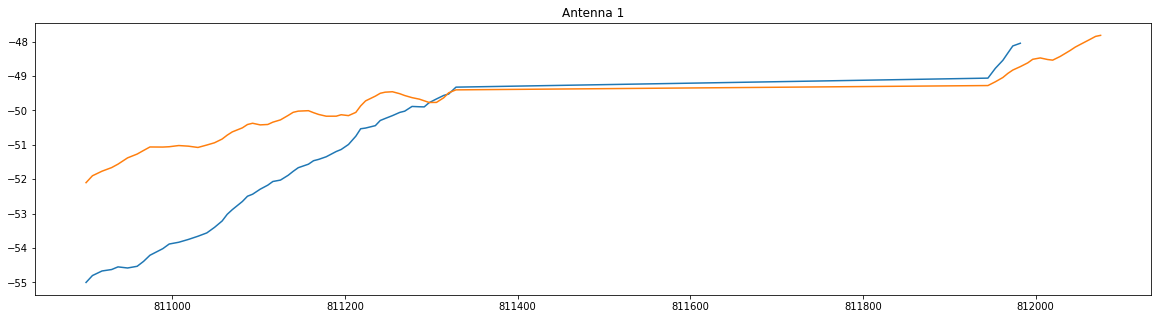

In [159]:
# antenna level curve
plt.plot(br_df['primary_kp_ant1'].iloc[sid],br_df['primary_rssi_dbm_ant1'].iloc[sid])
plt.plot(br_df['secondary_kp_ant1'].iloc[sid],br_df['secondary_rssi_dbm_ant1'].iloc[sid])
plt.title('Antenna 1')

Text(0.5, 1.0, 'Antenna 2')

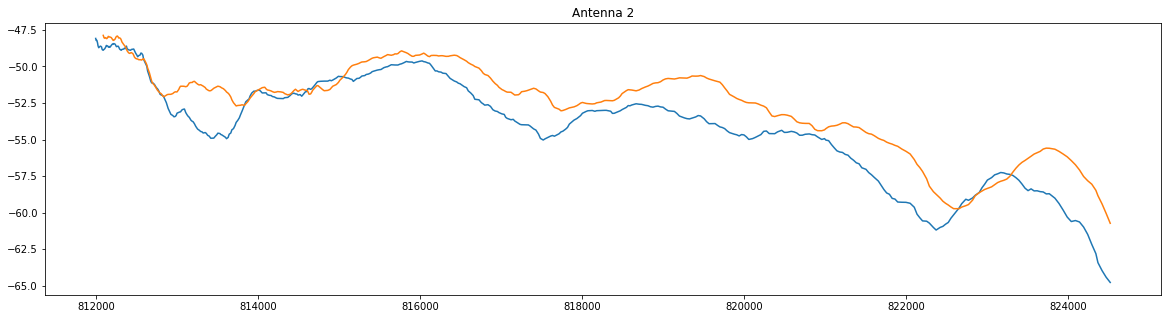

In [160]:
# antenna level curve
plt.plot(br_df['primary_kp_ant2'].iloc[sid],br_df['primary_rssi_dbm_ant2'].iloc[sid])
plt.plot(br_df['secondary_kp_ant2'].iloc[sid],br_df['secondary_rssi_dbm_ant2'].iloc[sid])
plt.title('Antenna 2')

In [161]:
# remove flipping of registered kp

In [162]:
# Interpolate to have the same number of points for both blue antennas of the simulations as the original curve.
def interp_primary_rssi_antenna(row,kp_df):
    
    tre = row['tre_id']
    direction = row['obm_direction']
    kp_inc = row['kp_inc']
    
    pkp_ant1 = row['primary_kp_ant1']
    pkp_ant2 = row['primary_kp_ant2']
    
    prssi_ant1 = row['primary_rssi_dbm_ant1']
    prssi_ant2 = row['primary_rssi_dbm_ant2']
    
    kp_df_temp = kp_df[(kp_df['tre_id'] == tre) & (kp_df['obm_direction'] == direction) & (kp_df['kp_inc'] == kp_inc)].copy(deep = True)
    
    kp_ant1 = kp_df_temp['kp_ant1'].iloc[0]
    kp_ant2 = kp_df_temp['kp_ant2'].iloc[0]
    
    if row['kp_inc']==False:
       
        pkp_ant1 = np.flip(pkp_ant1) 
        pkp_ant2 = np.flip(pkp_ant2)
    
        prssi_ant1 = np.flip(prssi_ant1)
        prssi_ant2 = np.flip(prssi_ant2)
    
#         kp_ant1 = np.flip(kp_ant1)
#         kp_ant2 = np.flip(kp_ant2)
    
    try:
        iprssi1 = np.interp(kp_ant1,pkp_ant1,prssi_ant1)
    except ValueError:
        iprssi1 = np.nan
    try:
        iprssi2 = np.interp(kp_ant2,pkp_ant2,prssi_ant2)
    except ValueError:
        iprssi2 = np.nan

    
    if row['kp_inc']==False:
        iprssi1=np.flip(iprssi1)
        iprssi2=np.flip(iprssi2)
        
        kp_ant1 =np.flip(kp_ant1)
        kp_ant2 =np.flip(kp_ant2)
    
    return kp_ant1,kp_ant2,iprssi1,iprssi2

In [163]:
# interpolate blue antenna level curves    
a, b, c, d = zip(*br_df.apply(lambda x : interp_primary_rssi_antenna(x,kp_df), axis=1))
# add changes
br_df['primary_kp_ant1'] = list(a)
br_df['primary_kp_ant2'] = list(b)
br_df['primary_rssi_dbm_ant1'] = list(c)
br_df['primary_rssi_dbm_ant2'] = list(d)

In [164]:
# interpolate to have same number of points for both red and blue kp and rssi after splitting w.r.t antenna
def interp_secondary_rssi_antenna(row):
    
    pkp_ant1 = row['primary_kp_ant1']
    pkp_ant2 = row['primary_kp_ant2']
    
    skp_ant1 = row['secondary_kp_ant1']
    skp_ant2 = row['secondary_kp_ant2']
    
    srssi_ant1 = row['secondary_rssi_dbm_ant1']
    srssi_ant2 = row['secondary_rssi_dbm_ant2']
    
    if row['kp_inc']==False:
       
        skp_ant1 = np.flip(skp_ant1) 
        skp_ant2 = np.flip(skp_ant2)

        srssi_ant1 = np.flip(srssi_ant1)
        srssi_ant2 = np.flip(srssi_ant2)

        pkp_ant1 = np.flip(pkp_ant1)
        pkp_ant2 = np.flip(pkp_ant2)

    try:
        isrssi1=np.interp(pkp_ant1,skp_ant1,srssi_ant1)
    except ValueError:
        isrssi1 = np.nan
    try:    
        isrssi2=np.interp(pkp_ant2,skp_ant2,srssi_ant2)
    except ValueError:
        isrssi2 = np.nan
    
    if row['kp_inc']==False:
        isrssi1=np.flip(isrssi1)
        isrssi2=np.flip(isrssi2)
        
    return isrssi1,isrssi2

In [165]:
# interpolate red antenna level curves
a, b = zip(*br_df.apply(lambda x : interp_secondary_rssi_antenna(x), axis=1))
# add changes 
br_df['secondary_rssi_dbm_ant1'] = list(a)
br_df['secondary_rssi_dbm_ant2'] = list(b)
br_df['secondary_kp_ant1'] = br_df['primary_kp_ant1']
br_df['secondary_kp_ant2'] = br_df['primary_kp_ant2']

Flip Kp at antenna level to have KP always increasing

In [181]:
# flip kp for antenna 1 if kp is decreasing
def flip_kp_ant1(row):
    
    kp_ant1 = row['primary_kp_ant1'] 
    prssi = row['primary_rssi_dbm_ant1']
    srssi = row['secondary_rssi_dbm_ant1']

    try:
        if row['kp_inc']==False:
            kp_ant1 = np.flip(kp_ant1)
            prssi=  np.flip(prssi)
            srssi = np.flip(srssi)


        #newkp = np.linspace(rkp.min(), rkp.max(),len(rkp))  #use rKp length
        new_kp_ant1 = np.linspace(kp_ant1.min(), kp_ant1.max(),len(kp_ant1))  #use Kp length

        return new_kp_ant1, prssi, srssi
    
    except ValueError:
        new_kp_ant1 = np.nan
        prssi = np.nan
        srssi = np.nan
        
        return new_kp_ant1, prssi, srssi

#br_df['Kp_inc'], br_df['BRSSI'], br_df['RRSSI'] = zip(*br_df.apply(lambda x : interpKp(x,nsamples), axis=1))
a,b,c=zip(*br_df.apply(lambda x : flip_kp_ant1(x), axis=1))
br_df['kp_ant1'] = list(a)
br_df['primary_rssi_ant1'] = list(b)
br_df['secondary_rssi_ant1'] = list(c)

In [182]:
# flip kp for antenna 2 if decreasing
def flip_kp_ant2(row):
    kp_ant2 = row['primary_kp_ant2'] 
    prssi = row['primary_rssi_dbm_ant2']
    srssi = row['secondary_rssi_dbm_ant2']
    
    try:
        if row['kp_inc']==False:
            kp_ant2=np.flip(kp_ant2)
            prssi=np.flip(prssi)
            srssi=np.flip(srssi)

        new_kp_ant2 = np.linspace(kp_ant2.min(), kp_ant2.max(),len(kp_ant2))  #use Kp length

        return new_kp_ant2, prssi, srssi
    
    except ValueError:
        new_kp_ant2 = np.nan
        prssi = np.nan
        srssi = np.nan
        
        return new_kp_ant2, prssi, srssi


#br_df['Kp_inc'], br_df['BRSSI'], br_df['RRSSI'] = zip(*br_df.apply(lambda x : interpKp(x,nsamples), axis=1))
a,b,c=zip(*br_df.apply(lambda x : flip_kp_ant2(x), axis=1))
br_df['kp_ant2'] = list(a)
br_df['primary_rssi_ant2'] = list(b)
br_df['secondary_rssi_ant2'] = list(c)

In [183]:
tre_id = 'GN-GN_01' 
dir = 'Head' 
kp_inc = True

In [184]:
sample = br_df[(br_df['tre_id'] == tre_id) & (br_df['obm_direction'] == dir) & (br_df['kp_inc'] == kp_inc)]

In [185]:
sample[['kp_ant1','kp_ant2','primary_rssi_ant1','primary_rssi_ant2','secondary_rssi_ant1','secondary_rssi_ant2']]

,kp_ant1,kp_ant2,primary_rssi_ant1,primary_rssi_ant2,secondary_rssi_ant1,secondary_rssi_ant2
116,"[1230947.3, 1230964.810263158, 1230982.3205263...",NaN,"[-55.0, -55.19944801103978, -55.33314911418153...",NaN,"[-54.0, -53.99946001079978, -53.99982000299995...",NaN
117,"[1230947.3, 1230964.810263158, 1230982.3205263...",NaN,"[-54.0, -53.99946001079978, -53.99982000299995...",NaN,"[-50.86721311475014, -51.07653842004697, -51.2...",NaN


In [186]:
sample.columns

Index(['primary_mac_address', 'train_id', 'obm_direction', 'date',
       'primary_rssi_dbm', 'primary_kp', 'secondary_mac_address',
       'secondary_rssi_dbm', 'secondary_kp', 'secondary_connection',
       'ap_mac_address', 'tre_ap_name', 'tre_id', 'ap_physical_name',
       'ap_name_geo', 'ap_color', 'ap_kp_in_track', 'kp_inc', 'obm_color',
       'report_date', 'kp', 'primary_rssi', 'secondary_rssi',
       'primary_kp_peak', 'secondary_kp_peak', 'primary_rssi_dbm_ant1',
       'primary_rssi_dbm_ant2', 'secondary_rssi_dbm_ant1',
       'secondary_rssi_dbm_ant2', 'primary_kp_ant1', 'primary_kp_ant2',
       'secondary_kp_ant1', 'secondary_kp_ant2', 'kp_ant1',
       'primary_rssi_ant1', 'secondary_rssi_ant1', 'kp_ant2',
       'primary_rssi_ant2', 'secondary_rssi_ant2'],
      dtype='object')

Text(0.5, 1.0, 'Antenna level increasing KP')

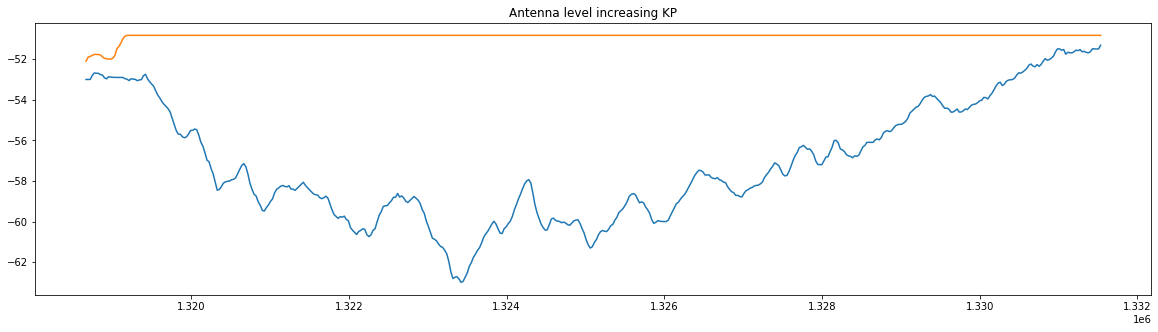

In [187]:
sid = 23
plt.plot(br_df['kp_ant1'].iloc[sid],br_df['primary_rssi_ant1'].iloc[sid])
plt.plot(br_df['kp_ant1'].iloc[sid],br_df['secondary_rssi_ant1'].iloc[sid])
plt.title('Antenna level increasing KP')

Text(0.5, 1.0, 'Antenna level increasing KP')

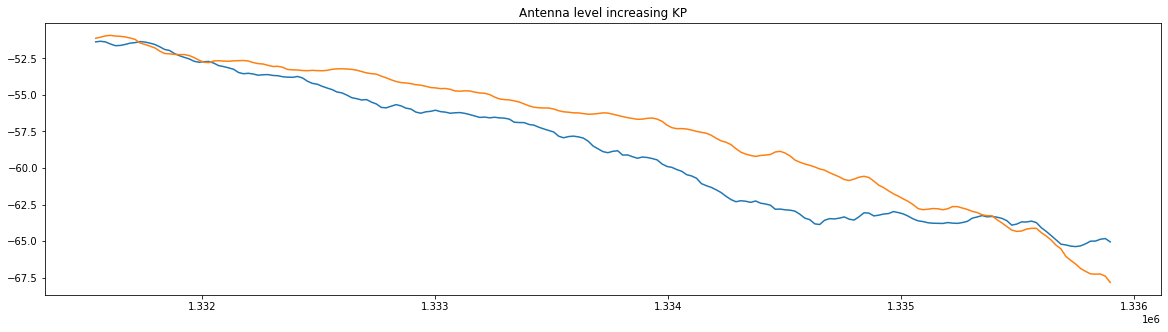

In [188]:
sid = 23
plt.plot(br_df['kp_ant2'].iloc[sid],br_df['primary_rssi_ant2'].iloc[sid])
plt.plot(br_df['kp_ant2'].iloc[sid],br_df['secondary_rssi_ant2'].iloc[sid])
plt.title('Antenna level increasing KP')

## Baseline Creation

In [189]:
#check if blue/red are zero mean wrt the real measured red-blue RSSI for this TRE
def in_baseline(row, primary_ref, secondary_ref):
    
    diff_prssi = row['primary_rssi_dbm'] - primary_ref
    diff_srssi = row['secondary_rssi_dbm'] - secondary_ref
    
    tp,pp=stats.ttest_1samp(diff_prssi,0)
    ts,ps=stats.ttest_1samp(diff_srssi,0)
    
    return (pp>=0.05 and ps>=0.05)

In [190]:
# get the list of tre, direction, kp inc flag
tre_list = kp_df['tre_id']
direction_list = kp_df['obm_direction']
kp_inc_list = kp_df['kp_inc']

In [195]:
# list to store bool values whether the curves have zero mean wrt the ref curve
baseline_bool_list = []
for tre,direction,kp_inc in zip(tre_list, direction_list, kp_inc_list):

    # get the reference curves 
#     ref_rssi_df = kp_df.loc[(kp_df['tre_id'] == tre) & (kp_df['obm_direction'] == direction) & (kp_df['kp_inc'] == kp_inc),['kp','primary_rssi_dbm','secondary_rssi_dbm']]
    
#     ref_primary_rssi = ref_rssi_df['primary_rssi_dbm'].values[0]
#     ref_secondary_rssi = ref_rssi_df['secondary_rssi_dbm'].values[0]
    
    # subset data with tre, direction, kp inc
    br_df_temp = br_df[(br_df['tre_id'] == tre) & (br_df['obm_direction'] == direction) & (br_df['kp_inc'] == kp_inc)].copy(deep = True)

#     br_df_temp['in_baseline'] = br_df_temp.apply(lambda x : in_baseline(x,ref_primary_rssi,ref_secondary_rssi), axis=1)
    
#     baseline_bool_list.append(br_df_temp['in_baseline'].to_list())
    
#     baseline_df = br_df_temp[br_df_temp['in_baseline']==True]
    
    try:
        rssi_base=[]
        for i in range(len(br_df_temp)):
            if type(br_df_temp["primary_rssi"].iloc[i]) not in [float,np.float64]:    
                rssi_base.append(br_df_temp["primary_rssi"].iloc[i])

            if type(br_df_temp["secondary_rssi"].iloc[i]) not in [float,np.float64]:    
                rssi_base.append(br_df_temp["secondary_rssi"].iloc[i])

        rssi_base=np.stack(rssi_base,axis=0)

        kp = br_df_temp['kp'].iloc[0]
    

        fd = FDataGrid(rssi_base,kp, 
                   dataset_label='Curves for the baseline',
                   axes_labels=['kp', 'RSSI'])
        
        mfd=fd.mean().data_matrix[0]

        basis = skfda.representation.basis.BSpline(n_basis=20, order=7)
        basis_fd = fd.to_basis(basis)
        mf=basis_fd.mean().evaluate(fd.sample_points[0])[0] 
        
        tre_baseline_df = tre_baseline_df.append({'tre_id': tre,'obm_direction': direction,'kp_inc': kp_inc,'rssi_baseline' : mfd,'fpca_baseline' : mf,'fd' : basis_fd.mean()}, ignore_index=True)

        print(tre,' ',direction,' ',kp_inc,' Baseline Successful!')

    except (LinAlgError,ValueError):
        print('Baseline failed for ',tre,' ',direction,' ',kp_inc)

BLW-HLD_02   Head   True  Baseline Successful!
LLL-HDS_02   Head   False  Baseline Successful!
HVW-ASW_04   Head   False  Baseline Successful!
HVW-ASW_04   Tail   True  Baseline Successful!
HVW-ASW_03   Head   False  Baseline Successful!
HVW-ASW_03   Tail   True  Baseline Successful!
STD-VLN_03   Head   False  Baseline Successful!
STD-VLN_03   Tail   True  Baseline Successful!
HVW-ASW_08   Tail   True  Baseline Successful!
HDS-HVW_03   Head   False  Baseline Successful!
HDS-HVW_03   Tail   True  Baseline Successful!
HVW-ASW_07   Head   False  Baseline Successful!
HVW-ASW_07   Tail   True  Baseline Successful!
ITW-STD_05   Head   False  Baseline Successful!
ITW-STD_05   Tail   True  Baseline Successful!
VLN-JLS_03   Head   False  Baseline Successful!
VLN-JLS_03   Tail   True  Baseline Successful!
ITW-STD_04   Head   False  Baseline Successful!
ITW-STD_04   Tail   True  Baseline Successful!
VLN-JLS_02   Head   False  Baseline Successful!
VLN-JLS_02   Tail   True  Baseline Successful!
HDS

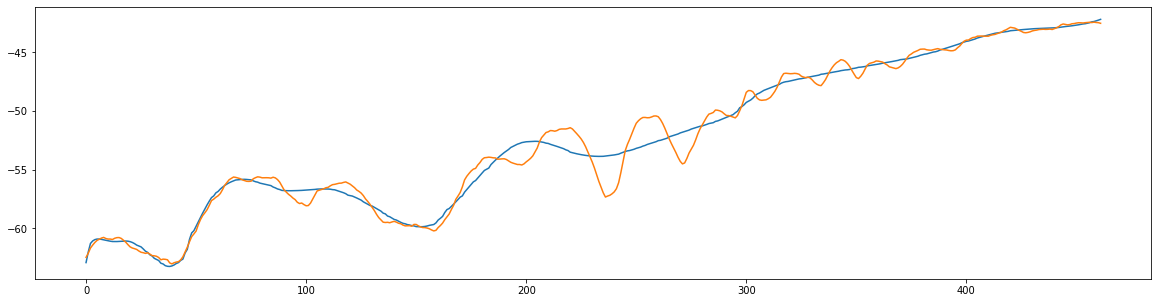

In [192]:
# sample rssi baseline and fpca baseline
bid = 103
plt.plot(tre_baseline_df['fpca_baseline'].iloc[bid])
plt.plot(tre_baseline_df['rssi_baseline'].iloc[bid])

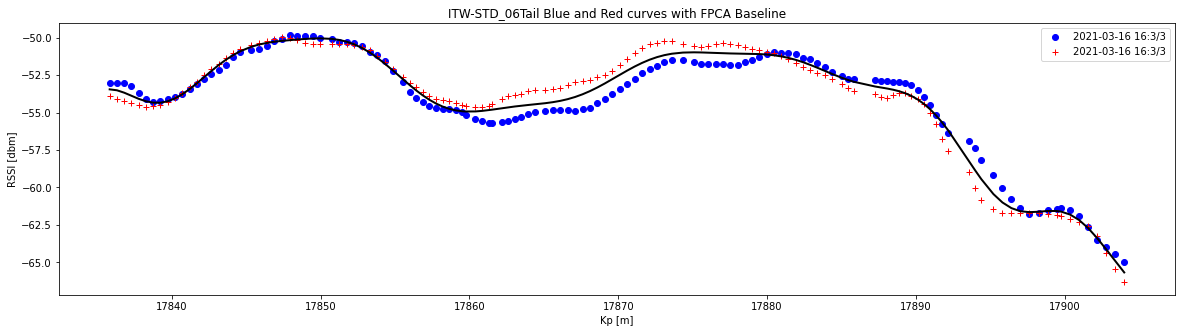

In [193]:
# select tre, direction, kp increasing flag
tc = br_df[(br_df['tre_id'] == tre_s) & (br_df['obm_direction'] == direction_s) & (br_df['kp_inc'] == kp_inc_s)] 

reg_kp = kp_df[(kp_df['tre_id'] == tre_s) & (kp_df['obm_direction'] == direction_s) & (kp_df['kp_inc'] == kp_inc_s)] 
tcbase = tre_baseline_df[(tre_baseline_df['tre_id'] == tre_s) & (tre_baseline_df['obm_direction'] == direction_s) & (tre_baseline_df['kp_inc'] == kp_inc_s)]

for i in range(len(tc)):
    plt.plot(tc['kp'].iloc[i]/100,tc['primary_rssi'].iloc[i], marker = next(marker),color = 'b', label = tc['date'].iloc[i],linestyle='')
    plt.plot(tc['kp'].iloc[i]/100,tc['secondary_rssi'].iloc[i], marker = next(marker),color = 'r', label = tc['date'].iloc[i],linestyle='')
    
    plt.legend()
    plt.title(tc['tre_id'].iloc[i] + tc['obm_direction'].iloc[i] + ' Blue and Red curves with FPCA Baseline')
    plt.ylabel('RSSI [dbm]')
    plt.xlabel('Kp [m]')  
plt.plot(reg_kp['kp'].iloc[0]/100,tcbase['fpca_baseline'].iloc[0],'k',linewidth=2)
#plt.plot(tre_baseline['baseline'].iloc[sid])

## Baseline Creation Antenna

In [196]:
# list to store bool values whether the curves have zero mean wrt the ref curve
baseline_bool_list = []
for tre,direction,kp_inc in zip(tre_list, direction_list, kp_inc_list):
    
    # subset data with tre, direction, kp inc
    br_df_temp = br_df[(br_df['tre_id'] == tre) & (br_df['obm_direction'] == direction) & (br_df['kp_inc'] == kp_inc)].copy(deep = True)
    # get index of the row wrt tre,direction,kp increasing in tre baseline df
    ind = tre_baseline_df.loc[(tre_baseline_df['tre_id'] == tre) & (tre_baseline_df['obm_direction'] == direction) & (tre_baseline_df['kp_inc'] == kp_inc)].index[0]

    try:
        # antenna 1
        rssi_base_ant1=[]
        for i in range(len(br_df_temp)):
            if type(br_df_temp["primary_rssi_ant1"].iloc[i]) not in [float,np.float64]:
                rssi_base_ant1.append(br_df_temp["primary_rssi_ant1"].iloc[i])

            if type(br_df_temp["secondary_rssi_ant1"].iloc[i]) not in [float,np.float64]:    
                rssi_base_ant1.append(br_df_temp["secondary_rssi_ant1"].iloc[i])

        rssi_base_ant1=np.stack(rssi_base_ant1,axis=0)

        kp_ant1 = br_df_temp['kp_ant1'].iloc[0]
    

        fd_ant1 = FDataGrid(rssi_base_ant1,kp_ant1, 
                   dataset_label='Curves for the baseline',
                   axes_labels=['kp', 'RSSI'])
        
        mfd_ant1=fd_ant1.mean().data_matrix[0]

        basis = skfda.representation.basis.BSpline(n_basis=20, order=7)
        basis_fd_ant1 = fd_ant1.to_basis(basis)
        mf_ant1 = basis_fd_ant1.mean().evaluate(fd_ant1.sample_points[0])[0] 
                
        tre_baseline_df.loc[ind,'rssi_baseline_ant1'] = mfd_ant1
        tre_baseline_df.loc[ind,'fpca_baseline_ant1'] = mf_ant1
        tre_baseline_df.loc[ind,'fd_ant1'] =basis_fd_ant1.mean()

        print(tre,' ',direction,' ',kp_inc,' Antenna 1 Baseline Successful!')

    except (LinAlgError, ValueError):
        print(tre,' ',direction,' ',kp_inc,'\033[91m'+'\033[1m'+'Antenna 1 Baseline failed'+'\033[0m')
    
    # antenna 2
    try:
        rssi_base_ant2=[]
        for j in range(len(br_df_temp)):

            if type(br_df_temp["primary_rssi_ant2"].iloc[j]) not in [float,np.float64]:
                rssi_base_ant2.append(br_df_temp["primary_rssi_ant2"].iloc[j])

            if type(br_df_temp["secondary_rssi_ant2"].iloc[j]) not in [float,np.float64]:    
                rssi_base_ant2.append(br_df_temp["secondary_rssi_ant2"].iloc[j])

        rssi_base_ant2=np.stack(rssi_base_ant2,axis=0)

        kp_ant2 = br_df_temp['kp_ant2'].iloc[0]
    
        fd_ant2 = FDataGrid(rssi_base_ant2,kp_ant2, 
                   dataset_label='Curves for the baseline',
                   axes_labels=['kp', 'RSSI'])
        
        mfd_ant2=fd_ant2.mean().data_matrix[0]

        basis_fd_ant2 = fd_ant2.to_basis(basis)
        mf_ant2 = basis_fd_ant2.mean().evaluate(fd_ant2.sample_points[0])[0] 
                
        tre_baseline_df.loc[ind,'rssi_baseline_ant2'] = mfd_ant2
        tre_baseline_df.loc[ind,'fpca_baseline_ant2'] = mf_ant2
        tre_baseline_df.loc[ind,'fd_ant2'] =basis_fd_ant2.mean()

        print(tre,' ',direction,' ',kp_inc,' Antenna 2 Baseline Successful!')

    except (LinAlgError, ValueError):
        print(tre,' ',direction,' ',kp_inc,'\033[91m'+'\033[1m'+'Antenna 2 Baseline failed'+'\033[0m')

BLW-HLD_02   Head   True  Antenna 1 Baseline Successful!
BLW-HLD_02   Head   True  Antenna 2 Baseline Successful!
LLL-HDS_02   Head   False  Antenna 1 Baseline Successful!
LLL-HDS_02   Head   False  Antenna 2 Baseline Successful!
HVW-ASW_04   Head   False  Antenna 1 Baseline Successful!
HVW-ASW_04   Head   False  Antenna 2 Baseline Successful!
HVW-ASW_04   Tail   True Antenna 1 Baseline failed
HVW-ASW_04   Tail   True  Antenna 2 Baseline Successful!
HVW-ASW_03   Head   False  Antenna 1 Baseline Successful!
HVW-ASW_03   Head   False  Antenna 2 Baseline Successful!
HVW-ASW_03   Tail   True Antenna 1 Baseline failed
HVW-ASW_03   Tail   True  Antenna 2 Baseline Successful!
STD-VLN_03   Head   False  Antenna 1 Baseline Successful!
STD-VLN_03   Head   False  Antenna 2 Baseline Successful!
STD-VLN_03   Tail   True Antenna 1 Baseline failed
STD-VLN_03   Tail   True  Antenna 2 Baseline Successful!
HVW-ASW_08   Tail   True  Antenna 1 Baseline Successful!
HVW-ASW_08   Tail   True  Antenna 2 Basel

RGB-GN_01B   Head   True  Antenna 2 Baseline Successful!
BLW-HLD_04   Head   True  Antenna 1 Baseline Successful!
BLW-HLD_04   Head   True  Antenna 2 Baseline Successful!
RGB-GN_03   Head   True  Antenna 1 Baseline Successful!
RGB-GN_03   Head   True  Antenna 2 Baseline Successful!
ZD-RAI_03   Head   False  Antenna 1 Baseline Successful!
ZD-RAI_03   Head   False  Antenna 2 Baseline Successful!
ZD-RAI_03   Tail   True  Antenna 1 Baseline Successful!
ZD-RAI_03   Tail   True  Antenna 2 Baseline Successful!
HLD-RGB_05B   Tail   False Antenna 1 Baseline failed
HLD-RGB_05B   Tail   False  Antenna 2 Baseline Successful!
BMR-BLW_02   Head   True  Antenna 1 Baseline Successful!
BMR-BLW_02   Head   True  Antenna 2 Baseline Successful!
EPP-ZD_06   Head   False  Antenna 1 Baseline Successful!
EPP-ZD_06   Head   False  Antenna 2 Baseline Successful!
EPP-ZD_06   Tail   True  Antenna 1 Baseline Successful!
EPP-ZD_06   Tail   True  Antenna 2 Baseline Successful!
STD-VLN_04   Head   False  Antenna 1 Ba

In [197]:
# Select a sample fpca baseline to plot
sid = 107
tre_f = tre_baseline_df['tre_id'].iloc[sid]
direction_f = tre_baseline_df['obm_direction'].iloc[sid]
kp_inc_f = tre_baseline_df['kp_inc'].iloc[sid]

In [198]:
# select curves for th corresponding tre, direction, kp increasing flag
bs = br_df[(br_df['tre_id'] == tre_f) & (br_df['obm_direction'] == direction_f) & (br_df['kp_inc'] == kp_inc_f)]

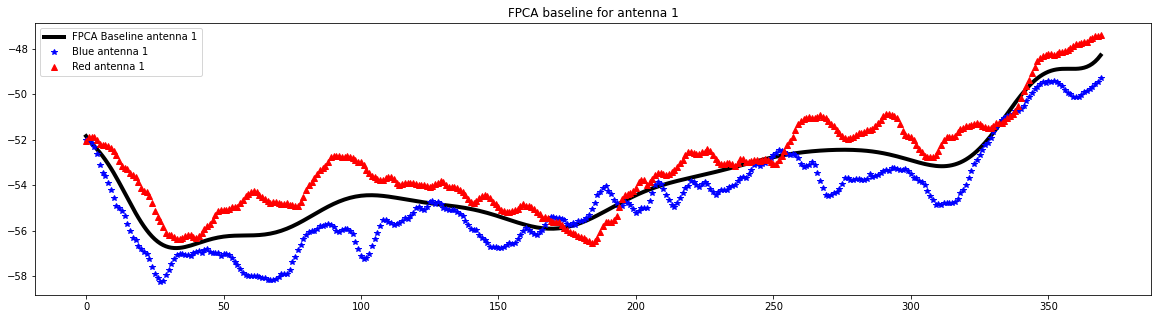

In [199]:
plt.plot(tre_baseline_df['fpca_baseline_ant1'].iloc[sid],'k',label = 'FPCA Baseline antenna 1', linewidth = 4)

for i in range(len(bs)):
    plt.plot(bs['primary_rssi_ant1'].iloc[i],marker = next(marker),color = 'b',label = 'Blue antenna 1', linewidth = 0)
    plt.plot(bs['secondary_rssi_ant1'].iloc[i],marker = next(marker),color = 'r',label = 'Red antenna 1', linewidth = 0)
    plt.legend() 
    plt.title('FPCA baseline for antenna 1')

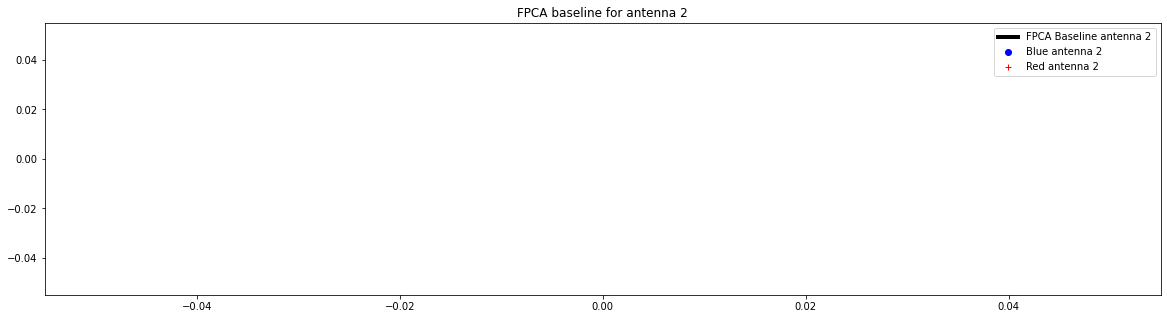

In [200]:
plt.plot(tre_baseline_df['fpca_baseline_ant2'].iloc[sid],'k',label = 'FPCA Baseline antenna 2', linewidth = 4)

for i in range(len(bs)):
    plt.plot(bs['primary_rssi_ant2'].iloc[i],marker = next(marker),color = 'b',label = 'Blue antenna 2', linewidth = 0)
    plt.plot(bs['secondary_rssi_ant2'].iloc[i],marker = next(marker),color = 'r',label = 'Red antenna 2', linewidth = 0)
    plt.legend() 
    plt.title('FPCA baseline for antenna 2')

## FPCA Reconstruction

In [201]:
def fdata_primary(row):
    prssi = row['primary_rssi']
    kp = row['kp']
    
    fd = FDataGrid(prssi,kp, 
               dataset_label='Measured RSSI curve Blue AP',
               axes_labels=['kp', 'RSSI'])
    return fd


br_df['primary_fdata'] = br_df.apply(lambda x : fdata_primary(x), axis=1)

In [202]:
def fdata_secondary(row):
    srssi = row['secondary_rssi']
    kp = row['kp']
    
    fd = FDataGrid(srssi,kp, 
               dataset_label='Measured RSSI curve Blue AP',
               axes_labels=['kp', 'RSSI'])
    return fd


br_df['secondary_fdata'] = br_df.apply(lambda x : fdata_secondary(x), axis=1)

In [203]:
# Compute Functional PCA
def FPCA(fd):
    n_components = 20
    basis = skfda.representation.basis.BSpline(n_basis=n_components,order=7)  
   # basis = skfda.representation.basis.Fourier(n_basis=10)          #error 
   # basis = skfda.representation.basis.Monomial(n_basis=8)         #original
    #basis = skfda.representation.basis.BSpline(n_basis=6)           #use splines note: change in coefficients wrt monomials
    try:
        fd_basis = fd.to_basis(basis)
        return fd_basis
    except:
      #  print("Unable to perform FPCA" + index)
        return None

# functional form
br_df['primary_fpca'] = br_df.apply(lambda row : FPCA(row["primary_fdata"]),axis=1) 
br_df['secondary_fpca'] = br_df.apply(lambda row : FPCA(row["secondary_fdata"]),axis=1)  

In [204]:
# fpca reconstruction
br_df['primary_fpca_predict'] = br_df[br_df['primary_fpca'].notnull()].apply(lambda row : row["primary_fpca"].evaluate(row["primary_fdata"].sample_points[0])[0],axis=1)
br_df['secondary_fpca_predict'] = br_df[br_df['secondary_fpca'].notnull()].apply(lambda row : row["secondary_fpca"].evaluate(row["secondary_fdata"].sample_points[0])[0],axis=1)

Text(0.5, 1.0, 'Actual and FPCA reconstructed curves')

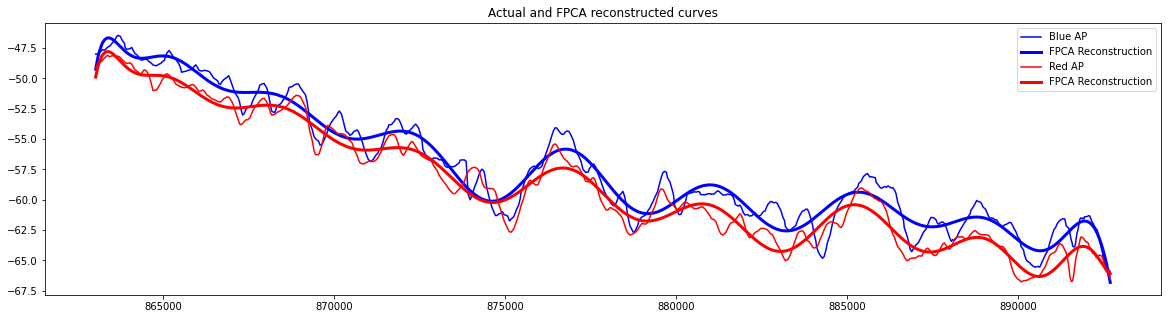

In [206]:
# sample fpca reconstruction
fid = 100

plt.plot(br_df['kp'].iloc[fid],br_df['primary_rssi'].iloc[fid],'b',label = 'Blue AP')
plt.plot(br_df['kp'].iloc[fid],br_df['primary_fpca_predict'].iloc[fid],'b',label = 'FPCA Reconstruction',linewidth = 3)
plt.plot(br_df['kp'].iloc[fid],br_df['secondary_rssi'].iloc[fid],'r',label = 'Red AP')
plt.plot(br_df['kp'].iloc[fid],br_df['secondary_fpca_predict'].iloc[fid],'r',label = 'FPCA Reconstruction',linewidth = 3)
plt.legend()
plt.title('Actual and FPCA reconstructed curves')

Antennas

In [207]:
def fdata_primary_antenna(row):
    
    prssi_ant1 = row['primary_rssi_ant1']
    kp_ant1 = row['kp_ant1']
    
    prssi_ant2 = row['primary_rssi_ant2']
    kp_ant2 = row['kp_ant2']
    
    try:
        fd_ant1 = FDataGrid(prssi_ant1,kp_ant1, 
                   dataset_label='Measured RSSI curve Blue AP antenna 1',
                   axes_labels=['kp_ant1', 'RSSI_ant1'])
        
    except (IndexError,ValueError):
        fd_ant1 = np.nan
    
    try:
        fd_ant2 = FDataGrid(prssi_ant2,kp_ant2, 
               dataset_label='Measured RSSI curve Blue AP antenna 2',
               axes_labels=['kp_ant2', 'RSSI_ant2'])
    
    except (IndexError,ValueError):
        fd_ant2 = np.nan
        
    
    return fd_ant1,fd_ant2


a,b = zip(*br_df.apply(lambda x : fdata_primary_antenna(x), axis=1))
br_df['primary_fdata_ant1'] = list(a)
br_df['primary_fdata_ant2'] = list(b)

In [208]:
def fdata_secondary_antenna(row):
    
    srssi_ant1 = row['secondary_rssi_ant1']
    kp_ant1 = row['kp_ant1']
    
    srssi_ant2 = row['secondary_rssi_ant2']
    kp_ant2 = row['kp_ant2']
    
    try:
        fd_ant1 = FDataGrid(srssi_ant1,kp_ant1, 
                   dataset_label='Measured RSSI curve Blue AP antenna 1',
                   axes_labels=['kp_ant1', 'RSSI_ant1'])
        
    except (IndexError,ValueError):
        fd_ant1 = np.nan
    
    try:
        fd_ant2 = FDataGrid(srssi_ant2,kp_ant2, 
               dataset_label='Measured RSSI curve Blue AP antenna 2',
               axes_labels=['kp_ant2', 'RSSI_ant2'])
    
    except (IndexError,ValueError):
        fd_ant2 = np.nan
        
    
    return fd_ant1,fd_ant2


a,b = zip(*br_df.apply(lambda x : fdata_secondary_antenna(x), axis=1))
br_df['secondary_fdata_ant1'] = list(a)
br_df['secondary_fdata_ant2'] = list(b)

In [209]:
br_df['primary_fpca_ant1'] = br_df.apply(lambda row : FPCA(row["primary_fdata_ant1"]),axis=1) 
br_df['secondary_fpca_ant1'] = br_df.apply(lambda row : FPCA(row["secondary_fdata_ant1"]),axis=1)  
br_df['primary_fpca_ant2'] = br_df.apply(lambda row : FPCA(row["primary_fdata_ant2"]),axis=1) 
br_df['secondary_fpca_ant2'] = br_df.apply(lambda row : FPCA(row["secondary_fdata_ant2"]),axis=1)  

In [210]:
print("FPCA blue antenna 1 generation failures %d%%" % (len(br_df[br_df['primary_fpca_ant1'].notnull() == False])*100/len(br_df)))
print("FPCA red antenna 1 generation failures %d%%" % (len(br_df[br_df['secondary_fpca_ant1'].notnull() == False])*100/len(br_df)))
print("FPCA blue antenna 2 generation failures %d%%" % (len(br_df[br_df['primary_fpca_ant2'].notnull() == False])*100/len(br_df)))
print("FPCA red antenna 2 generation failures %d%%" % (len(br_df[br_df['secondary_fpca_ant2'].notnull() == False])*100/len(br_df)))

FPCA blue antenna 1 generation failures 26%
FPCA red antenna 1 generation failures 26%
FPCA blue antenna 2 generation failures 1%
FPCA red antenna 2 generation failures 1%


In [211]:
# predict primary for both antennas
br_df['primary_fpca_predict_ant1'] = br_df[br_df['primary_fpca_ant1'].notnull()].apply(lambda row : row["primary_fpca_ant1"].evaluate(row["primary_fdata_ant1"].sample_points[0])[0],axis=1)
br_df['primary_fpca_predict_ant2'] = br_df[br_df['primary_fpca_ant2'].notnull()].apply(lambda row : row["primary_fpca_ant2"].evaluate(row["primary_fdata_ant2"].sample_points[0])[0],axis=1)

In [212]:
# predict red for both antennas
br_df['secondary_fpca_predict_ant1'] = br_df[br_df['secondary_fpca_ant1'].notnull()].apply(lambda row : row["secondary_fpca_ant1"].evaluate(row["secondary_fdata_ant1"].sample_points[0])[0],axis=1)
br_df['secondary_fpca_predict_ant2'] = br_df[br_df['secondary_fpca_ant2'].notnull()].apply(lambda row : row["secondary_fpca_ant2"].evaluate(row["secondary_fdata_ant2"].sample_points[0])[0],axis=1)

Text(0.5, 1.0, 'Actual and FPCA reconstructed curves antenna 1')

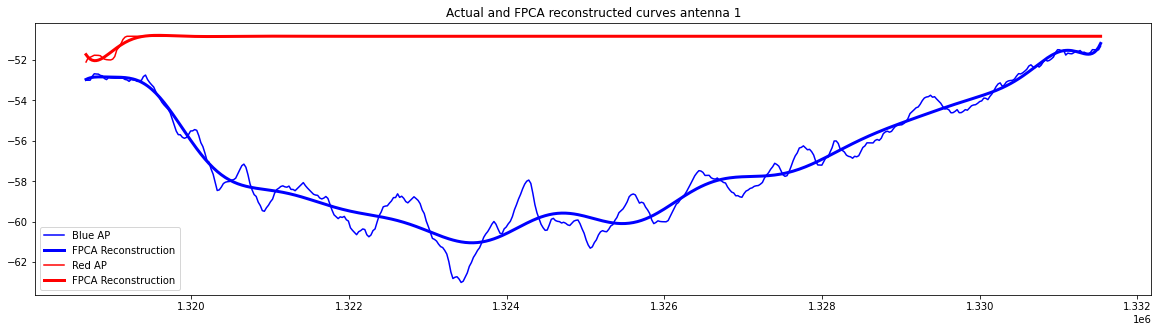

In [213]:
# sample fpca antenna 1 reconstruction
fid = 23


plt.plot(br_df['kp_ant1'].iloc[fid],br_df['primary_rssi_ant1'].iloc[fid],'b',label = 'Blue AP')
plt.plot(br_df['kp_ant1'].iloc[fid],br_df['primary_fpca_predict_ant1'].iloc[fid],'b',label = 'FPCA Reconstruction',linewidth = 3)
plt.plot(br_df['kp_ant1'].iloc[fid],br_df['secondary_rssi_ant1'].iloc[fid],'r',label = 'Red AP')
plt.plot(br_df['kp_ant1'].iloc[fid],br_df['secondary_fpca_predict_ant1'].iloc[fid],'r',label = 'FPCA Reconstruction',linewidth = 3)
plt.legend()
plt.title('Actual and FPCA reconstructed curves antenna 1')

Text(0.5, 1.0, 'Actual and FPCA reconstructed curves antenna 2')

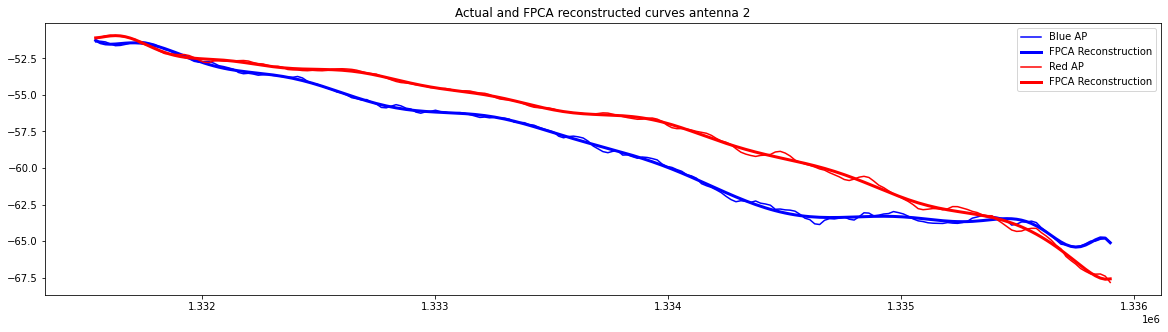

In [214]:
# sample fpca antenna 2 reconstruction

plt.plot(br_df['kp_ant2'].iloc[fid],br_df['primary_rssi_ant2'].iloc[fid],'b',label = 'Blue AP')
plt.plot(br_df['kp_ant2'].iloc[fid],br_df['primary_fpca_predict_ant2'].iloc[fid],'b',label = 'FPCA Reconstruction',linewidth = 3)
plt.plot(br_df['kp_ant2'].iloc[fid],br_df['secondary_rssi_ant2'].iloc[fid],'r',label = 'Red AP')
plt.plot(br_df['kp_ant2'].iloc[fid],br_df['secondary_fpca_predict_ant2'].iloc[fid],'r',label = 'FPCA Reconstruction',linewidth = 3)
plt.legend()
plt.title('Actual and FPCA reconstructed curves antenna 2')

Calculating Error

In [215]:
# Compute the error between the functional model and raw data
def eval_r2(fd,fd_basis):
    to_eval = fd.sample_points[0]
    evaluation = fd_basis.evaluate(fd.sample_points[0])[0]
    test = fd.data_matrix[0]
    r2 = r2_score(test,evaluation)
    return r2

In [216]:
# error
br_df['primary_fpca_r2'] = br_df[br_df['primary_fpca'].notnull()].apply(lambda row : eval_r2(row["primary_fdata"],row["primary_fpca"]),axis=1)
br_df['secondary_fpca_r2'] = br_df[br_df['secondary_fpca'].notnull()].apply(lambda row : eval_r2(row["secondary_fdata"],row["secondary_fpca"]),axis=1)

## HI-2

Calculate Distance 

In [217]:
# compute the distance between blue and red
def compute_distance_primary_secondary(row):
    try:
        primary_fd = row['primary_fpca'].coefficients[0]
        secondary_fd = row['secondary_fpca'].coefficients[0]
        #spb=br_df['FDataBlue'][cd].sample_points[0]
        #spb
        #red_fd=row['FDataRed'][cd].evaluate(spb)
        #blue_fd = row['FPCABlue_predict']
        #red_fd = row['FPCARed_predict']
        #distance = sqeuclidean(blue_fd,red_fd)/np.abs(row['Kp'].agg(["max"])[0]-row['Kp'].agg(["min"])[0]) #splines
        #distance = minkowski(blue_fd,red_fd)/np.abs(row['Kp'].agg(["max"])[0]-row['Kp'].agg(["min"])[0])
        #distance = sqeuclidean(blue_fd,red_fd)
        #distance = cosine(blue_fd,red_fd)
        #distance = distance/np.sqrt(len(row['Kp']))
        distance = minkowski(primary_fd,secondary_fd)
    except AttributeError:
        distance = np.nan
        
    return distance

In [218]:
# RSSI difference and distance computation
br_df['distance_primary_secondary'] = br_df[br_df['primary_fpca_r2'] > 0.5].apply(lambda row : compute_distance_primary_secondary(row),axis=1)

In [219]:
# difference in RSSI from the baseline
def compute_distance_baseline(row, baseline):
    
    tre = row['tre_id']
    direction = row['obm_direction']
    kp_inc = row['kp_inc']
    
    cd = baseline[(baseline['tre_id'] == tre) & (baseline['obm_direction'] == direction) & (baseline['kp_inc'] == kp_inc)].index.values[0]
    
    # baseline
    baseline_fd = baseline['fd'][cd]
    
    primary_fd = row['primary_fpca_predict']
    secondary_fd = row['secondary_fpca_predict']
    
    #blue_fd = row['FPCABlue'].coefficients[0]
    #red_fd = row['FPCARed'].coefficients[0]
    #spb=br_df['FDataBlue'][cd].sample_points[0]
    #spb
    #red_fd=row['FDataRed'][cd].evaluate(spb)
    #blue_fd = row['FPCABlue_predict']
    #red_fd = row['FPCARed_predict']
    #ref_fd=baseline.coefficients[0]
    ref_fd = baseline_fd.evaluate(row["primary_fdata"].sample_points[0])[0]
    #distance = sqeuclidean(blue_fd,red_fd)/np.abs(row['Kp'].agg(["max"])[0]-row['Kp'].agg(["min"])[0]) #splines
    #distance = minkowski(blue_fd,red_fd)/np.abs(row['Kp'].agg(["max"])[0]-row['Kp'].agg(["min"])[0])
    #distance = sqeuclidean(blue_fd,red_fd)
    #distanceBlue = minkowski(blue_fd,ref_fd)
    #distanceRed = minkowski(red_fd,ref_fd)
    try:
        primary_distance = minkowski(primary_fd,ref_fd)/np.sqrt(len(row['kp']))
        secondary_distance = minkowski(secondary_fd,ref_fd)/np.sqrt(len(row['kp']))
    except (AttributeError,ValueError):
        primary_distance = np.nan
        secondary_distance = np.nan
    #distanceBlue = cosine(blue_fd,ref_fd)
    #distanceRed = cosine(red_fd,ref_fd)
    return primary_distance, secondary_distance

In [220]:
# distance from baseline to blue and red curves
a,b=zip(*br_df.apply(lambda x : compute_distance_baseline(x,tre_baseline_df), axis=1))
br_df['primary_dist'] = list(a)
br_df['secondary_dist'] = list(b)

In [221]:
# antenna 1
def compute_distance_baseline_ant1(row, baseline):
    
    tre = row['tre_id']
    direction = row['obm_direction']
    kp_inc = row['kp_inc']
    
    cd = baseline[(baseline['tre_id'] == tre) & (baseline['obm_direction'] == direction) & (baseline['kp_inc'] == kp_inc)].index.values[0]
    
    # baseline
    baseline_fd_ant1 = baseline['fd_ant1'][cd]
    
    primary_fd_ant1 = row['primary_fpca_predict_ant1']
    secondary_fd_ant1 = row['secondary_fpca_predict_ant1']
    
    try:
        ref_fd_ant1 = baseline_fd_ant1.evaluate(row["primary_fdata_ant1"].sample_points[0])[0]
        #distanceBlue = minkowski(blue_fd,ref_fd,2,np.linspace(1,100,len(row['BRSSI_ant1'])))/np.sqrt(len(row['BRSSI_ant1']))
        #distanceRed = minkowski(red_fd,ref_fd,2,np.linspace(1,100,len(row['RRSSI_ant1'])))/np.sqrt(len(row['BRSSI_ant1']))
        primary_distance_ant1 = minkowski(primary_fd_ant1,ref_fd_ant1)/np.sqrt(len(row['primary_rssi_ant1']))
        secondary_distance_ant1 = minkowski(secondary_fd_ant1,ref_fd_ant1)/np.sqrt(len(row['secondary_rssi_ant1']))
    
    except (AttributeError,ValueError):
        primary_distance_ant1 = np.nan
        secondary_distance_ant1 = np.nan
    
    #distance = cosine(blue_fd,red_fd)
    #distance = distance/np.sqrt(len(row['Kp']))
    
    return primary_distance_ant1, secondary_distance_ant1

In [222]:
# distance from antenna 1 baseline to antenna 1 blue and red curves
c,d=zip(*br_df.apply(lambda x : compute_distance_baseline_ant1(x,tre_baseline_df), axis=1))
br_df['primary_dist_ant1'] = list(c)
br_df['secondary_dist_ant1'] = list(d)

In [223]:
# antenna 2
def compute_distance_baseline_ant2(row, baseline):
    
    tre = row['tre_id']
    direction = row['obm_direction']
    kp_inc = row['kp_inc']
    
    cd = baseline[(baseline['tre_id'] == tre) & (baseline['obm_direction'] == direction) & (baseline['kp_inc'] == kp_inc)].index.values[0]
    
    # baseline
    baseline_fd_ant2 = baseline['fd_ant2'][cd]
    
    primary_fd_ant2 = row['primary_fpca_predict_ant2']
    secondary_fd_ant2 = row['secondary_fpca_predict_ant2']
    
    try:
        ref_fd_ant2 = baseline_fd_ant2.evaluate(row["primary_fdata_ant2"].sample_points[0])[0]
        #distanceBlue = minkowski(blue_fd,ref_fd,2,np.linspace(2,200,len(row['BRSSI_ant2'])))/np.sqrt(len(row['BRSSI_ant2']))
        #distanceRed = minkowski(red_fd,ref_fd,2,np.linspace(2,200,len(row['RRSSI_ant2'])))/np.sqrt(len(row['BRSSI_ant2']))
        primary_distance_ant2 = minkowski(primary_fd_ant2,ref_fd_ant2)/np.sqrt(len(row['primary_rssi_ant2']))
        secondary_distance_ant2 = minkowski(secondary_fd_ant2,ref_fd_ant2)/np.sqrt(len(row['secondary_rssi_ant2']))
    
    except (AttributeError,ValueError):
        primary_distance_ant2 = np.nan
        secondary_distance_ant2 = np.nan
    
    #distance = cosine(blue_fd,red_fd)
    #distance = distance/np.sqrt(len(row['Kp']))
    
    return primary_distance_ant2, secondary_distance_ant2

In [224]:
# distance from antenna 1 baseline to antenna 1 blue and red curves
e,f=zip(*br_df.apply(lambda x : compute_distance_baseline_ant2(x,tre_baseline_df), axis=1))
br_df['primary_dist_ant2'] = list(e)
br_df['secondary_dist_ant2'] = list(f)

In [225]:
br_df

,primary_mac_address,train_id,obm_direction,date,primary_rssi_dbm,primary_kp,secondary_mac_address,secondary_rssi_dbm,secondary_kp,secondary_connection,...,secondary_fpca_predict_ant2,primary_fpca_r2,secondary_fpca_r2,distance_primary_secondary,primary_dist,secondary_dist,primary_dist_ant1,secondary_dist_ant1,primary_dist_ant2,secondary_dist_ant2
0,00:14:5a:02:31:53,115,Head,2021-03-16 16:1/3,"[-65.1, -63.59936401271975, -62.73312278128631...","[908142.6, 908169.2, 908187.4, 908223.7, 90824...",00:14:5a:02:3e:ef,"[-57.68076923076739, -56.94943051139137, -56.7...","[908142.6, 908169.2, 908187.4, 908223.7, 90824...",True,...,"[[-34.12561117537572], [-33.5252925738452], [-...",0.887719,0.910477,47.218698,1.286311,0.764759,1.199400,0.714427,2.311847,1.627650
1,00:14:5a:02:31:53,115,Head,2021-03-16 17:1/3,"[-56.78341463414682, -56.523337211305254, -56....","[908142.6, 908169.2, 908187.4, 908223.7, 90824...",00:14:5a:02:3e:ef,"[-55.88292682926832, -55.62285841112471, -55.5...","[908142.6, 908169.2, 908187.4, 908223.7, 90824...",True,...,"[[-33.15049151988518], [-33.90700819663342], [...",0.909453,0.919922,35.236066,0.859923,1.017715,0.736264,0.993461,1.731937,2.064117
2,00:14:5a:02:31:a1,115,Head,2021-03-16 16:3/3,"[-52.0, -51.99948001039979, -52.13315978067042...","[1386407.0, 1386384.5, 1386362.0, 1386339.5, 1...",00:14:5a:02:31:f8,"[-47.85132743362955, -48.14951850962981, -48.2...","[1386407.0, 1386384.5, 1386362.0, 1386339.5, 1...",False,...,"[[-61.909035822065874], [-61.9521215987671], [...",0.937219,0.939827,16.845873,1.301057,1.301057,1.424538,1.424538,0.987128,0.987128
3,00:14:5a:02:31:ac,115,Head,2021-03-16 17:1/3,"[-53.0, -52.99947001059979, -52.86649022516280...","[1198472.1, 1198414.2, 1198356.3, 1198298.4, 1...",00:14:5a:02:32:09,"[-54.10017271157143, -53.89963372062413, -53.6...","[1198472.1, 1198414.2, 1198356.3, 1198298.4, 1...",False,...,"[[-65.67894480718313], [-65.60316870768395], [...",0.990400,0.988789,31.871274,0.676779,0.676779,0.628684,0.628684,0.783619,0.783619
4,00:14:5a:02:31:ac,115,Tail,2021-03-16 16:2/3,"[-39.0, -39.19960800783984, -39.53320211329836...","[1188051.3, 1188114.1, 1188208.4, 1188271.3, 1...",00:14:5a:02:32:09,"[-38.90015898251244, -39.099450026897934, -39....","[1188051.3, 1188114.1, 1188208.4, 1188271.3, 1...",False,...,"[[-39.80545246027265], [-39.1523867346277], [-...",0.969519,0.964842,31.879448,1.099256,1.099256,NaN,NaN,1.107797,1.107797
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,00:14:5a:03:05:f4,115,Head,2021-03-16 16:3/3,"[-59.0, -59.199408011839765, -59.1331361143980...","[1465059.5, 1465035.7, 1465011.9, 1464976.1, 1...",00:14:5a:02:31:e0,"[-54.85000000000147, -55.149448511031245, -55....","[1465059.5, 1465035.7, 1465011.9, 1464976.1, 1...",False,...,"[[-63.95012092504259], [-63.993290337916726], ...",0.962851,0.953301,21.703973,0.729591,0.729591,0.788228,0.788228,0.711762,0.711762
147,00:14:5a:03:05:f4,115,Tail,2021-03-16 16:2/3,"[-39.0, -38.999610007799845, -39.1332031132815...","[1434004.6, 1434039.3, 1434091.3, 1434143.3, 1...",00:14:5a:02:31:e0,"[-37.599999999999994, -37.73308421139251, -37....","[1434004.6, 1434039.3, 1434091.3, 1434143.3, 1...",False,...,"[[-38.01760354005642], [-38.0331839056756], [-...",0.963543,0.971343,12.695621,0.808379,0.808379,NaN,NaN,0.811645,0.811645
148,00:14:5a:03:06:0c,115,Tail,2021-03-16 16:2/3,"[-59.0, -58.199418011639764, -57.9998063365609...","[604012.2, 604193.1, 604268.5, 604343.9, 60435...",00:14:5a:02:34:f2,"[-62.20066445182864, -58.73370470422427, -58.4...","[604012.2, 604193.1, 604268.5, 604343.9, 60435...",False,...,"[[-41.80089380175684], [-41.729881855932334], ...",0.990693,0.993120,11.900584,0.278876,0.278876,0.655329,0.655329,0.263750,0.263750
149,00:14:5a:03:08:81,115,Head,2021-03-16 17:1/3,"[-55.0, -55.19944801103978, -55.26648255862407...","[738359.3, 738329.9, 738271.1, 738212.2, 73812...",00:14:5a:02:3f:8e,"[-55.39932088285245, -55.19910845586152, -54.9...","[738359.3, 738329.9

In [226]:
tre_baseline_df

,tre_id,obm_direction,kp_inc,fpca_baseline,fd,fpca_baseline_ant1,fd_ant1,fpca_baseline_ant2,fd_ant2,rssi_baseline,rssi_baseline_ant1,rssi_baseline_ant2
0,BLW-HLD_02,Head,True,"[[-56.15679398821948], [-56.05574121901307], [...",[[[FDataBasis(\n _basis=BSpline(domain_rang...,"[[-60.5161164463754], [-59.291603116194665], [...",[[[FDataBasis(\n _basis=BSpline(domain_rang...,"[[-34.40380459202772], [-34.37422800729223], [...",[[[FDataBasis(\n _basis=BSpline(domain_rang...,"[[-58.86177767354563], [-58.173747536635275], ...","[[-58.86177767354563], [-58.173747536635275], ...","[[-34.36475243691494], [-34.4722017508806], [-..."
1,LLL-HDS_02,Head,False,"[[-63.22011172015101], [-62.731021407583825], ...",[[[FDataBasis(\n _basis=BSpline(domain_rang...,"[[-37.72150338784009], [-37.71631646069446], [...",[[[FDataBasis(\n _basis=BSpline(domain_rang...,"[[-62.703865277766766], [-62.764659706735785],...",[[[FDataBasis(\n _basis=BSpline(domain_rang...,"[[-62.781302787706494], [-62.67014836328322], ...","[[-37.68848752463869], [-37.71038755475868], [...","[[-62.781302787706494], [-62.67014836328322], ..."
2,HVW-ASW_04,Head,False,"[[-65.65977540071904], [-65.49366558711459], [...",[[[FDataBasis(\n _basis=BSpline(domain_rang...,"[[-41.026183693966644], [-41.167719602355035],...",[[[FDataBasis(\n _basis=BSpline(domain_rang...,"[[-65.63585030428904], [-65.5874898813419], [-...",[[[FDataBasis(\n _basis=BSpline(domain_rang...,"[[-65.65845277625725], [-65.53738104576348], [...","[[-41.07526248676804], [-41.11613804899906], [...","[[-65.65845277625725], [-65.53738104576348], [..."
3,HVW-ASW_04,Tail,True,"[[-39.41358366234193], [-39.10880194771754], [...",[[[FDataBasis(\n _basis=BSpline(domain_rang...,NaN,NaN,"[[-39.66372897298186], [-39.34574257563613], [...",[[[FDataBasis(\n _basis=BSpline(domain_rang...,"[[-38.95007949125622], [-39.14952901736889], [...",NaN,"[[-39.14952901736889], [-39.39981609156561], [..."
4,HVW-ASW_03,Head,False,"[[-66.71845141074996], [-66.41907447505614], [...",[[[FDataBasis(\n _basis=BSpline(domain_rang...,"[[-31.486338564044758], [-32.299781453266334],...",[[[FDataBasis(\n _basis=BSpline(domain_rang...,"[[-66.34568437337714], [-66.39238837877724], [...",[[[FDataBasis(\n _basis=BSpline(domain_rang...,"[[-66.37044045445433], [-66.32261210506942], [...","[[-31.84621404121244], [-32.04224041710901], [...","[[-66.37044045445433], [-66.32261210506942], [..."
...,...,...,...,...,...,...,...,...,...,...,...,...
261,PJW-LLL_02,Head,False,"[[-63.51596436101714], [-64.0620132492845], [-...",[[[FDataBasis(\n _basis=BSpline(domain_rang...,NaN,NaN,NaN,NaN,"[[-64.77911839213641], [-64.66442954143585], [...",NaN,NaN
262,PJW-LLL_02,Tail,True,"[[-38.19700268471786], [-38.328322549417955], ...",[[[FDataBasis(\n _basis=BSpline(domain_rang...,NaN,NaN,NaN,NaN,"[[-38.3], [-38.36634710959618], [-38.499935993...",NaN,NaN
263,OAS-MDW_06,Tail,True,"[[-59.875685742841405], [-59.93406090798735], ...",[[[FDataBasis(\n _basis=BSpline(domain_rang...,NaN,NaN,NaN,NaN,"[[-60.600332225914315], [-58.46656135793202], ...",NaN,NaN
264,RAI-OAS_04,Head,False,"[[-63.72344581016976], [-63.62850592516098], [...",[[[FDataBasis(\n _basis=BSpline(domain_rang...,NaN,NaN,NaN,NaN,"[[-63.85182033415407], [-63.65258381097205], [...",NaN,NaN


In [227]:
kp_df

,tre_id,obm_direction,kp_inc,kp,primary_rssi_dbm,secondary_rssi_dbm,kp_len,kp_max,kp_min,kp_ant1,kp_ant2,primary_rssi_dbm_ant1,primary_rssi_dbm_ant2
0,BLW-HLD_02,Head,True,"[908142.6, 908169.2, 908187.4, 908223.7, 90824...","[-65.1, -63.6, -62.3, -61.2, -60.4, -59.8, -59...","[-57.68076923076739, -56.9500000000016, -56.63...",40048.4,948191.0,908142.6,"[908142.6, 908169.2, 908187.4, 908223.7, 90824...","[940201.9, 940260.4, 940318.9, 940377.5, 94046...","[-65.1, -63.6, -62.3, -61.2, -60.4, -59.8, -59...","[-35.4, -35.8, -36.4, -37.1, -37.7, -38.2, -38..."
1,LLL-HDS_02,Head,False,"[1360613.5, 1360675.3, 1360767.9, 1360829.7, 1...","[-63.7, -63.5, -63.4, -63.3, -63.1, -63.3, -63...","[-62.0, -62.0, -61.80032414910965, -61.6999999...",25793.5,1386407.0,1360613.5,"[1369103.2, 1369155.8, 1369182.1, 1369208.4, 1...","[1360613.5, 1360675.3, 1360767.9, 1360829.7, 1...","[-63.7, -63.5, -63.4, -63.3, -63.1, -63.3, -63...","[-39.1, -39.2, -39.2, -39.2, -39.4, -39.5, -39..."
2,HVW-ASW_04,Head,False,"[1177306.4, 1177388.5, 1177429.6, 1177511.7, 1...","[-65.7, -65.6, -65.6, -65.1, -64.8, -65.0, -64...","[-65.76655844155835, -65.63327922077917, -65.5...",21165.7,1198472.1,1177306.4,"[1187383.4, 1187445.6, 1187507.8, 1187569.9, 1...","[1177306.4, 1177388.5, 1177429.6, 1177511.7, 1...","[-65.7, -65.6, -65.6, -65.1, -64.8, -65.0, -64...","[-40.9, -40.9, -41.1, -41.1, -41.1, -41.1, -41..."
3,HVW-ASW_04,Tail,True,"[1188051.3, 1188114.1, 1188208.4, 1188271.3, 1...","[-39.0, -39.2, -39.7, -39.9, -40.2, -40.3, -40...","[-38.90015898251244, -39.0998410174883, -39.34...",21067.2,1209118.5,1188051.3,[1188051.3],"[1188114.1, 1188208.4, 1188271.3, 1188334.1, 1...",[-39.0],"[-39.2, -39.7, -39.9, -40.2, -40.3, -40.4, -40..."
4,HVW-ASW_03,Head,False,"[1199528.3, 1199562.4, 1199664.6, 1199732.8, 1...","[-66.0, -66.0, -65.9, -65.7, -65.8, -65.4, -65...","[-66.8, -66.8, -66.69999999999965, -66.4999999...",24656.0,1224184.3,1199528.3,"[1205849.6, 1205879.4, 1205968.6, 1205998.3, 1...","[1199528.3, 1199562.4, 1199664.6, 1199732.8, 1...","[-66.0, -66.0, -65.9, -65.7, -65.8, -65.4, -65...","[-31.1, -31.7, -32.2, -32.9, -33.4, -33.7, -33..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
128,PJW-LLL_02,Head,False,"[1423033.0, 1423093.0, 1423173.0, 1423233.0, 1...","[-65.7, -65.4, -65.3, -65.2, -65.1, -65.2, -65...","[-64.0, -64.0, -64.0, -63.9, -63.9, -63.9, -63...",42026.5,1465059.5,1423033.0,"[1434425.5, 1434465.0, 1434504.6, 1434544.2, 1...","[1423033.0, 1423093.0, 1423173.0, 1423233.0, 1...","[-65.7, -65.4, -65.3, -65.2, -65.1, -65.2, -65...","[-40.5, -40.6, -40.6, -40.6, -40.7, -40.6, -40..."
129,PJW-LLL_02,Tail,True,"[1434004.6, 1434039.3, 1434091.3, 1434143.3, 1...","[-39.0, -39.0, -39.2, -39.3, -39.4, -39.6, -39...","[-37.599999999999994, -37.733461538461356, -37...",29447.9,1463452.5,1434004.6,[1434004.6],"[1434039.3, 1434091.3, 1434143.3, 1434212.6, 1...",[-39.0],"[-39.0, -39.2, -39.3, -39.4, -39.6, -39.5, -39..."
130,OAS-MDW_06,Tail,True,"[604012.2, 604193.1, 604268.5, 604343.9, 60435...","[-59.0, -58.2, -57.9, -57.8, -57.5, -57.0, -55...","[-62.20066445182864, -58.734292035398006, -58....",24447.2,628459.4,604012.2,"[604012.2, 604193.1, 604268.5, 604343.9, 60435...","[605533.1, 605562.1, 605634.6, 605678.0, 60572...","[-59.0, -58.2, -57.9, -57.8, -57.5, -57.0, -55...","[-42.1, -42.2, -42.3, -42.6, -42.8, -43.0, -43..."
131,RAI-OAS_04,Head,False,"[712982.9, 713038.8, 713094.6, 713150.5, 71320...","[-63.7, -63.4, -63.1, -62.9, -62.7, -62.8, -62...","[-64.24991055456185, -64.14991055456163, -63.9...",25376.4,738359.3,712982.9,"[724037.8, 724085.2, 724132.8, 724180.2, 72422...","[712982.9, 713038.8, 713094.6, 713150.5, 71320...","[-63.7, -63.4, -63.1, -62.9, -62.7, -62.8, -62...","[-42.2, -42.0, -42.2, -42.3, -42.1, -42.2, -42..."


Visualisation of a sample Curve, Baseline, HI-2

In [228]:
# select a random acquisition
sid = 107
tre_s = br_df['tre_id'].iloc[sid]
direction_s = br_df['obm_direction'].iloc[sid]
kp_inc_s = br_df['kp_inc'].iloc[sid]

In [229]:
# subset with the respective treid,direction,kp inc flag
sample_df = br_df[(br_df['tre_id'] == tre_s) & (br_df['obm_direction'] == direction_s) & (br_df['kp_inc'] == kp_inc_s)] 
sample_baseline_df = tre_baseline_df[(tre_baseline_df['tre_id'] == tre_s) & (tre_baseline_df['obm_direction'] == direction_s) & (tre_baseline_df['kp_inc'] == kp_inc_s)]

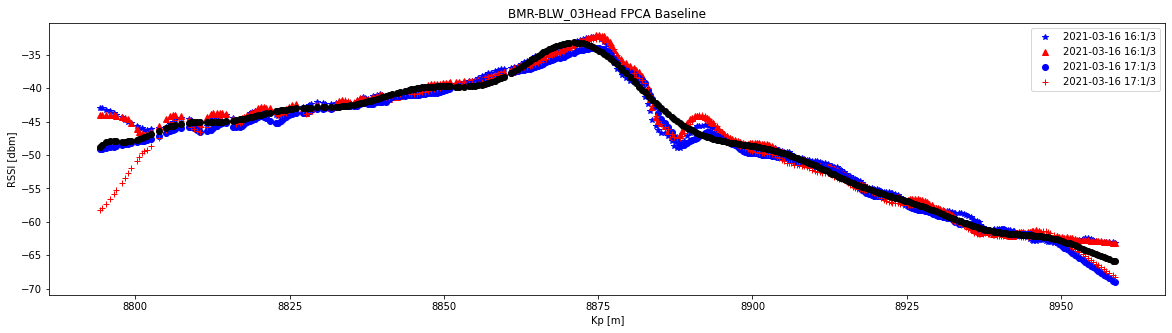

In [230]:
# plot the curves
for i in range(len(sample_df)):
    plt.plot(sample_df['kp'].iloc[i]/100,sample_df['primary_rssi'].iloc[i], marker = next(marker),color = 'b', label = sample_df['date'].iloc[i],linestyle='')
    plt.plot(sample_df['kp'].iloc[i]/100,sample_df['secondary_rssi'].iloc[i], marker = next(marker),color = 'r', label = sample_df['date'].iloc[i],linestyle='')
    plt.legend()
    plt.title(sample_df['tre_id'].iloc[i] + sample_df['obm_direction'].iloc[i]+' FPCA Baseline')
    plt.ylabel('RSSI [dbm]')
    plt.xlabel('Kp [m]')
plt.plot(sample_df['kp'].iloc[0]/100,sample_baseline_df['fpca_baseline'].iloc[0], marker = 'o',color = 'k', label = 'FPCA Baseline',linestyle='')

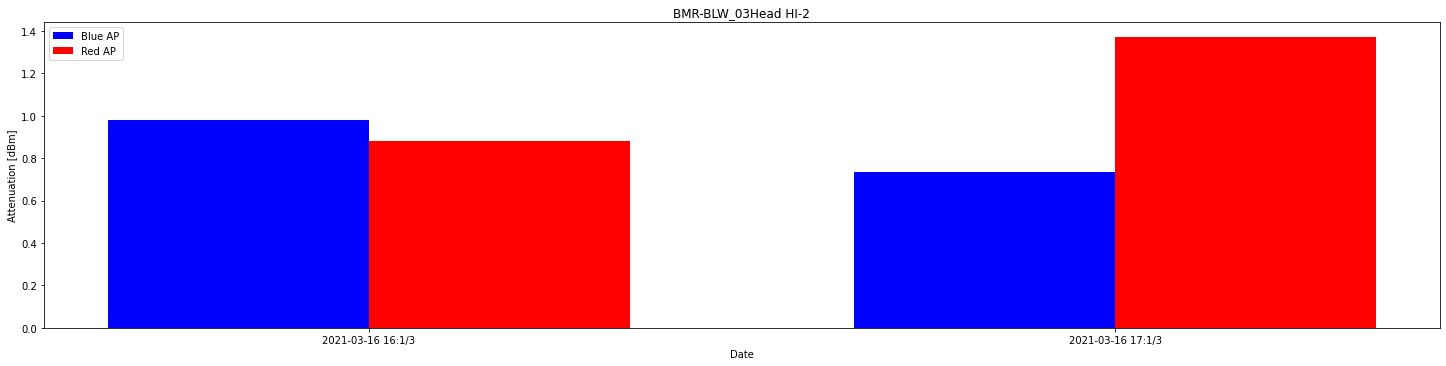

In [231]:
# HI-2    
fig, ax = plt.subplots()
sample_df.index.values
x = np.arange(len(sample_df))
# x = np.arange(int(sample_df.index.values.min()),int(sample_df.index.values.max()) + 1)  # the label locations
width = 0.35  # the width of the bars

rects1 = ax.bar(x - width/2, sample_df['primary_dist'], width , label='Blue AP',color='b')
rects2 = ax.bar(x + width/2, sample_df['secondary_dist'], width , label='Red AP',color='r')

ax.set_xticks(x)
ax.set_xticklabels(sample_df['date'])
ax.legend()
plt.title(sample_df['tre_id'].iloc[0] + sample_df['obm_direction'].iloc[0] + ' HI-2')
fig.tight_layout()
plt.xlabel('Date')
plt.ylabel('Attenuation [dBm]')
plt.show()

Antenna level

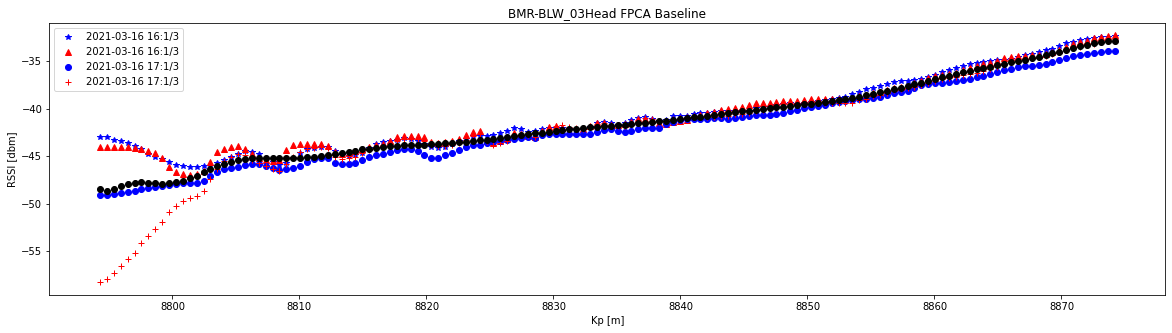

In [232]:
# plot the curves
for i in range(len(sample_df)):
    plt.plot(sample_df['kp_ant1'].iloc[i]/100,sample_df['primary_rssi_ant1'].iloc[i], marker = next(marker),color = 'b', label = sample_df['date'].iloc[i],linestyle='')
    plt.plot(sample_df['kp_ant1'].iloc[i]/100,sample_df['secondary_rssi_ant1'].iloc[i], marker = next(marker),color = 'r', label = sample_df['date'].iloc[i],linestyle='')
    plt.legend()
    plt.title(sample_df['tre_id'].iloc[i] + sample_df['obm_direction'].iloc[i]+' FPCA Baseline')
    plt.ylabel('RSSI [dbm]')
    plt.xlabel('Kp [m]')
plt.plot(sample_df['kp_ant1'].iloc[0]/100,sample_baseline_df['fpca_baseline_ant1'].iloc[0], marker = 'o',color = 'k', label = 'FPCA Baseline',linestyle='')

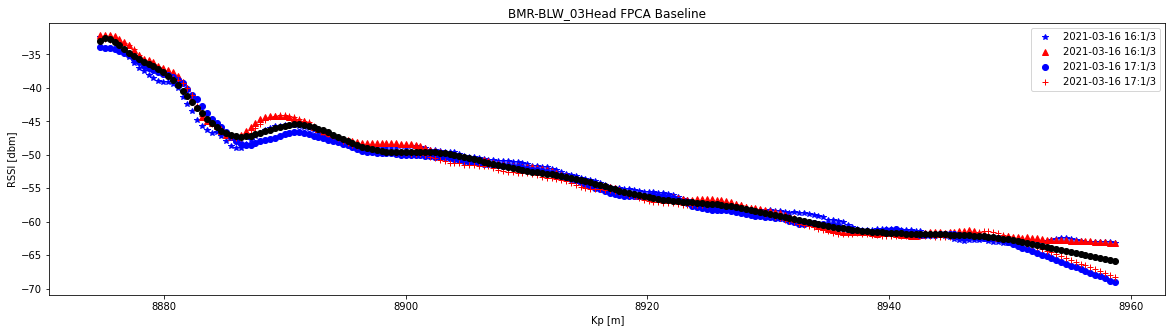

In [233]:
# plot the curves
for i in range(len(sample_df)):
    plt.plot(sample_df['kp_ant2'].iloc[i]/100,sample_df['primary_rssi_ant2'].iloc[i], marker = next(marker),color = 'b', label = sample_df['date'].iloc[i],linestyle='')
    plt.plot(sample_df['kp_ant2'].iloc[i]/100,sample_df['secondary_rssi_ant2'].iloc[i], marker = next(marker),color = 'r', label = sample_df['date'].iloc[i],linestyle='')
    plt.legend()
    plt.title(sample_df['tre_id'].iloc[i] + sample_df['obm_direction'].iloc[i]+' FPCA Baseline')
    plt.ylabel('RSSI [dbm]')
    plt.xlabel('Kp [m]')
plt.plot(sample_df['kp_ant2'].iloc[0]/100,sample_baseline_df['fpca_baseline_ant2'].iloc[0], marker = 'o',color = 'k', label = 'FPCA Baseline',linestyle='')

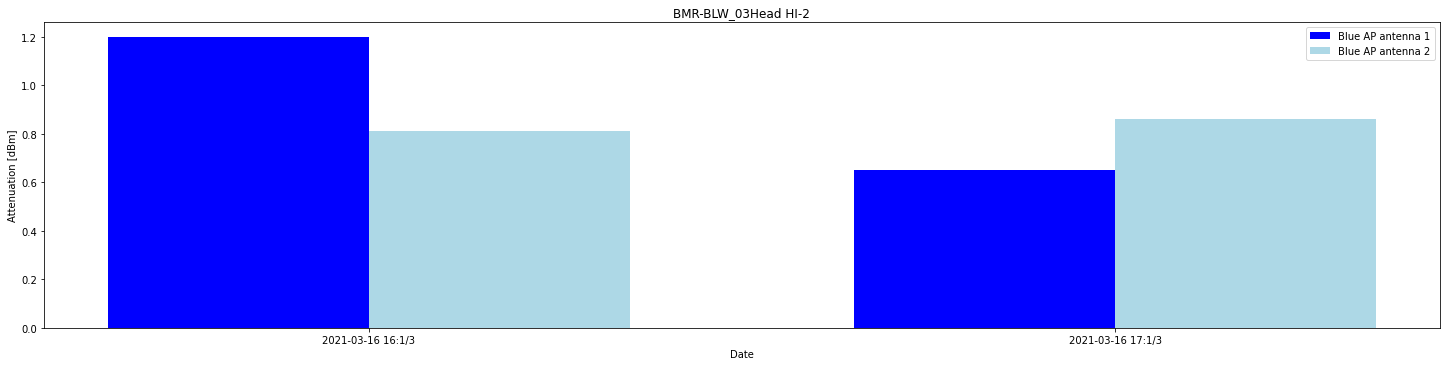

In [234]:
# HI primary    
fig, ax = plt.subplots()
sample_df.index.values
x = np.arange(len(sample_df))  # the label locations
y = [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5]
width = 0.35  # the width of the bars

rects1 = ax.bar(x - width/2, sample_df['primary_dist_ant1'], width , label='Blue AP antenna 1',color='b')
rects2 = ax.bar(x + width/2, sample_df['primary_dist_ant2'], width , label='Blue AP antenna 2',color='lightblue')

ax.set_xticks(x)
ax.set_xticklabels(sample_df['date'])
ax.legend()
plt.title(sample_df['tre_id'].iloc[0] + sample_df['obm_direction'].iloc[0] + ' HI-2')
fig.tight_layout()
plt.xlabel('Date')
plt.ylabel('Attenuation [dBm]')
plt.show()

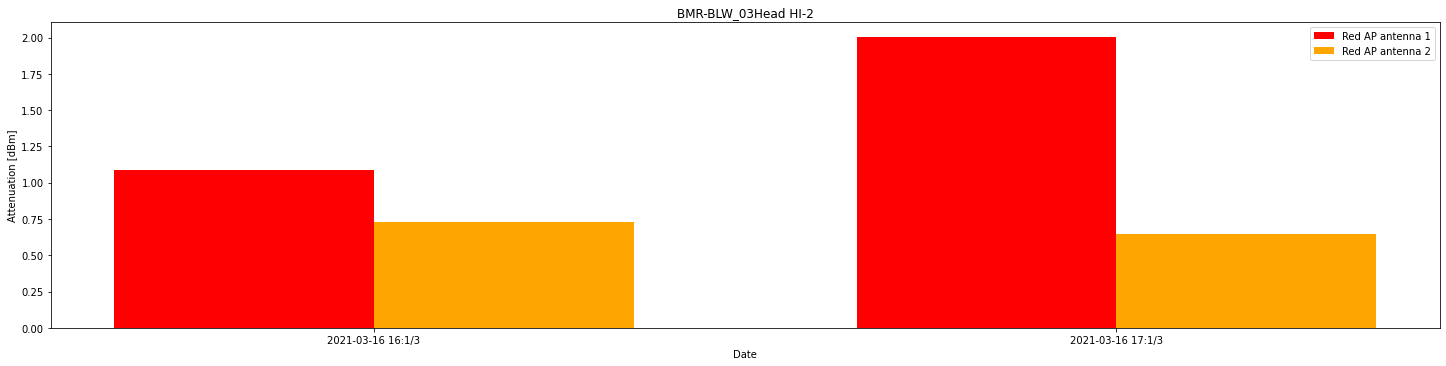

In [235]:
# HI secondary    
fig, ax = plt.subplots()
sample_df.index.values
x = np.arange(len(sample_df))  # the label locations
y = [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5]
width = 0.35  # the width of the bars

rects1 = ax.bar(x - width/2, sample_df['secondary_dist_ant1'], width , label='Red AP antenna 1',color='r')
rects2 = ax.bar(x + width/2, sample_df['secondary_dist_ant2'], width , label='Red AP antenna 2',color='orange')

ax.set_xticks(x)
ax.set_xticklabels(sample_df['date'])
ax.legend()
plt.title(sample_df['tre_id'].iloc[0] + sample_df['obm_direction'].iloc[0] + ' HI-2')
fig.tight_layout()
plt.xlabel('Date')
plt.ylabel('Attenuation [dBm]')
plt.show()

In [ ]:
############## IGNORE BELOW ##################

Anomaly Detection Test

In [100]:
ad_test = br_df_test.copy(deep = True)
ad_test

,primary_mac_address,train_id,obm_direction,date,primary_rssi_dbm,primary_kp,secondary_mac_address,secondary_rssi_dbm,secondary_kp,secondary_connection,ap_mac_address,tre_ap_name,tre_id,ap_physical_name,ap_name_geo,ap_color,ap_kp_in_track,kp_inc
0,00:14:5a:02:31:5e,121,Head,2021-03-16 14:2/3,"[-62.0, -62.3, -62.105000000000004, -61.93925,...","[204712.35897435897, 204690.5641025641, 204625...",00:14:5a:02:36:4a,"[-55.0, -55.15, -55.8775, -56.195875, -56.7664...","[204668.7692307692, 204646.97435897437, 204603...",False,00:14:5a:02:31:5e,WLP-WPP_03_BLUE,WLP-WPP_03,WLP-WPP_03_RAP_BLUE,WPP_03_BLUE,BLUE,179400.0,False
1,00:14:5a:02:31:5e,121,Head,2021-03-16 15:2/3,"[-63.0, -62.550000000000004, -61.8675000000000...","[204647.2105263158, 204624.84210526315, 204580...",00:14:5a:02:36:4a,"[-61.0, -61.3, -61.555, -61.47175, -61.2509875...","[204602.47368421053, 204557.73684210525, 20451...",False,00:14:5a:02:31:5e,WLP-WPP_03_BLUE,WLP-WPP_03,WLP-WPP_03_RAP_BLUE,WPP_03_BLUE,BLUE,179400.0,False
2,00:14:5a:02:31:5e,121,Head,2021-03-16 16:1/3,"[-60.0, -60.0, -60.0, -60.300000000000004, -61...","[205359.9512195122, 205323.36585365853, 205286...",00:14:5a:02:36:4a,"[-64.0, -64.0, -64.45, -65.2825, -64.940125, -...","[205341.65853658537, 205305.0731707317, 205268...",False,00:14:5a:02:31:5e,WLP-WPP_03_BLUE,WLP-WPP_03,WLP-WPP_03_RAP_BLUE,WPP_03_BLUE,BLUE,179400.0,False
3,00:14:5a:02:31:5e,121,Head,2021-03-16 17:1/3,"[-61.0, -60.85, -60.572500000000005, -60.33662...","[204992.8780487805, 204951.41463414635, 204909...",00:14:5a:02:36:4a,"[-57.0, -57.3, -57.705, -57.749249999999996, -...","[204972.1463414634, 204930.6829268293, 204889....",False,00:14:5a:02:31:5e,WLP-WPP_03_BLUE,WLP-WPP_03,WLP-WPP_03_RAP_BLUE,WPP_03_BLUE,BLUE,179400.0,False


In [101]:
# get the baseline for the curves
baseline_test = tre_baseline_df[(tre_baseline_df['tre_id'] == 'WLP-WPP_03') & (tre_baseline_df['obm_direction'] == 'Head') & (tre_baseline_df['kp_inc'] == False)]
baseline_test

,tre_id,obm_direction,kp_inc,baseline,fpca_baseline,fd,baseline_ant1,fpca_baseline_ant1,fd_ant1,baseline_ant2,fpca_baseline_ant2,fd_ant2,rssi_baseline,rssi_baseline_ant1,rssi_baseline_ant2
5,WLP-WPP_03,Head,False,NaN,"[[-67.92705175227317], [-67.02842783205315], [...",[[[FDataBasis(\n _basis=BSpline(domain_rang...,NaN,"[[-44.21146842162776], [-44.1333845809078], [-...",[[[FDataBasis(\n _basis=BSpline(domain_rang...,NaN,"[[-66.96127996924535], [-66.57001161481394], [...",[[[FDataBasis(\n _basis=BSpline(domain_rang...,"[[-66.92769267171889], [-66.65938211989767], [...","[[-43.80813678474336], [-43.89047866024941], [...","[[-66.92769267171889], [-66.65938211989767], [..."


Text(0.5, 1.0, 'Blue and Red curves for WLP-WPP_03Head')

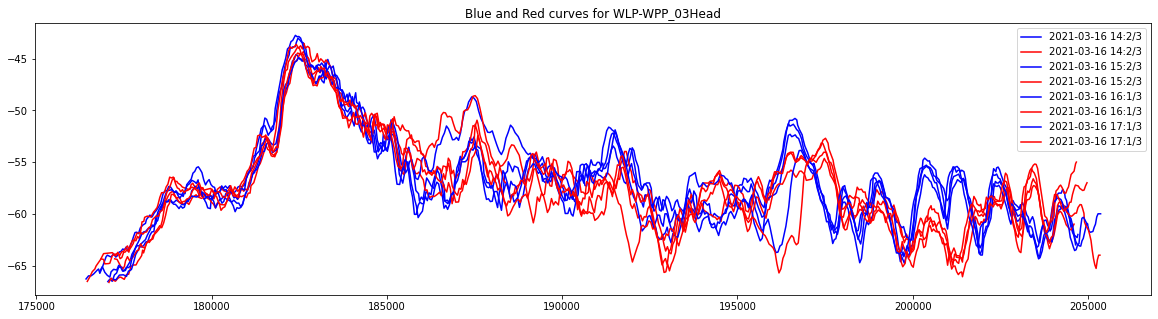

In [102]:
# blue red curves
for i in range(len(ad_test)):
    plt.plot(br_df_test['primary_kp'].iloc[i],br_df_test['primary_rssi_dbm'].iloc[i],'b', label = br_df_test['date'].iloc[i])
    plt.plot(br_df_test['secondary_kp'].iloc[i],br_df_test['secondary_rssi_dbm'].iloc[i],'r', label = br_df_test['date'].iloc[i])
plt.legend()
plt.title('Blue and Red curves for ' + br_df_test['tre_id'].iloc[0] + br_df_test['obm_direction'].iloc[0])

Add degradation to one of the curves

In [103]:
# create new columns to save type of degradation and level of attenuation
ad_test['type_degradation'] = np.nan
ad_test['degraded_ap'] = np.nan
ad_test['attenuation'] = np.nan
ad_test['degraded_antenna'] = np.nan
ad_test['tilt_degree'] = np.nan

In [104]:
# read tilt simulation processed data
front_1 = pd.read_csv('front_antenna1.csv')
front_2 = pd.read_csv('front_antenna2.csv')
rear_1 = pd.read_csv('rear_antenna1.csv')
rear_2 = pd.read_csv('rear_antenna2.csv')

# algorithm to fit the curve to tilt simulation data based on parameters 
def tilt_fit_curve(obm_direction = "Head", tilt_degree = 15, antenna = 1):
    if obm_direction == "Head":
        if antenna == 1:
            for i in [col for col in front_1 if col.endswith('diff_' + str(tilt_degree))]:
                spl = UnivariateSpline(front_1["Distance"], front_1[i])
                
        if antenna == 2:
            for i in [col for col in front_2 if col.endswith('diff_' + str(tilt_degree))]:
                spl = UnivariateSpline(front_2["Distance"], front_2[i])
            
    if obm_direction == "Tail":
        if antenna == 1:
            for i in [col for col in rear_1 if col.endswith('diff_' + str(tilt_degree))]:
                spl = UnivariateSpline(rear_1["Distance"], rear_1[i])
                
        if antenna == 2:
            for i in [col for col in rear_2 if col.endswith('diff_' + str(tilt_degree))]:
                spl = UnivariateSpline(rear_2["Distance"], rear_2[i])
    
    # set smoothing factor
    spl.set_smoothing_factor(0.8)
        
    return spl

In [105]:
def antenna_tilt_change(row, tilt_degree = 15, access_point = 'primary', antenna = 1):
   

    # subset the data with the given index and color
    if ap == 'primary':
        kp = row['primary_kp']
        rssi = row['primary_rssi_dbm']
        obm_direction = row['obm_direction']
        kp_inc = row['kp_inc']
        
    if ap == 'secondary':
        kp = row['secondary_kp']
        rssi = row['secondary_rssi_dbm']
        obm_direction = row['obm_direction']
        kp_inc = row['kp_inc']

    #find the peak 
    max_index = np.argmax(rssi, axis=0)
    peak_kp = kp[max_index] 
#     print('Direction ',obm_direction)
#     print('Kp_inc ',kp_inc)
#     print('peak ',peak_kp)

    #function to generate model w.r.t the tilt, orient and antenna  
    tilt_curve = tilt_fit_curve(obm_direction, tilt_degree, antenna)
        
    #estimation of position of access point
    #condition if the orientation is front, which means the obm is at the front.
    if obm_direction == "Head":
        if antenna == 1:
            peak_sim = 600
            len_max = 125000
        else:
            peak_sim = 700
            len_max = 124900
    else:
        if antenna == 1:
            peak_sim = 700
            len_max = 125000
        else:
            peak_sim = 600
            len_max = 124900
            
    #algorithm for generating change in RSSI [dBm] due to antenna tilt for a single antenna.
    #condition for antenna 1
    if (antenna == 1 and kp_inc == True) or (antenna == 2 and kp_inc == False):
        #initialising the position of the ap to 0
        position_ap = peak_kp + peak_sim
        # subset kp
        subkp = kp[kp > peak_kp]
        #loop to iterate through sorted kp in track values which are greater than our peak value of the selected access point
        for i in np.sort(subkp):
            #the distance between the the access point and the peak of the model should be greater than or equal to 600 cm.
            if i - peak_kp >= peak_sim:
                #if condition is satisfied assign the kp in track as the position of access point
                position_ap = i
                #break the loop
                break
#         print('position ap ',position_ap)
        #loop to iterate through kp in track for selected parameters
        for i in range(0,len(kp)):
            #make changes only if the kp in track is 100 cm away from the ap towards the left and also only till 125000 cms away from ap
            if(kp[i] <= position_ap - peak_sim) & (position_ap - kp[i] <= len_max):
                #calculate the difference in distance from the access point to the current kp in track
                diff = position_ap - kp[i] 

                rssi[i] = rssi[i]+ tilt_curve(diff)

    if (antenna == 1 and kp_inc == False) or (antenna == 2 and kp_inc == True):
        #initialising the position of the ap to 0
        position_ap = peak_kp - peak_sim
        # subset kp
        subkp = kp[kp < peak_kp]
        #loop to iterate through sorted kp in track values which are greater than our peak value of the selected access point
        for i in np.sort(subkp)[::-1]:
            #the distance between the the access point and the peak of the model should be greater than or equal to 600 cm.
            if peak_kp - i >= peak_sim:
                #if condition is satisfied assign the kp in track as the position of access point
                position_ap = i
                #break the loop
                break
                
#         print('position ap ',position_ap)
        #loop to iterate through kp in track for selected parameters
        for i in range(0,len(kp)):
            #make changes only if the kp in track is 100 cm away from the ap towards the left and also only till 125000 cms away from ap
            if(kp[i] >= position_ap + peak_sim) & (kp[i] - position_ap <= len_max):
                #calculate the difference in distance from the access point to the current kp in track
                diff = kp[i] - position_ap 

                rssi[i] = rssi[i]+ tilt_curve(diff)

    #return data, position of the peak, position of the access point
    return rssi

In [106]:
def constant_attenuation(row, attenuation, access_point = 'primary', single_side = False, antenna = 1):
    # subset the data with the given index and color
    if ap == 'primary':
        rssi = row['primary_rssi_dbm']
        
    if ap == 'secondary':
        rssi = row['secondary_rssi_dbm']
    
    if single_side == False:
        rssi = rssi - attenuation
    else:
        #find index of the peak 
        max_index = np.argmax(rssi, axis=0)

        if antenna == 1:
            rssi[:max_index+1] = rssi[:max_index+1] - attenuation
        else:
            rssi[max_index+1:] = rssi[max_index+1:] - attenuation

    return rssi

In [107]:
# apply degradation to any of the curve
i = 0
# degradation = np.random.choice(['constant attenuation','antenna tilt','single sided attenuation'])
degradation = 'antenna tilt'
ap = np.random.choice(['primary','secondary'])


ad_test['type_degradation'].iloc[i] = degradation
ad_test['degraded_ap'].iloc[i] = ap

if degradation == 'constant attenuation':

#         print('adding constant attenuation')

    attenuation = np.random.choice([2,3,4,5])
    ad_test['attenuation'].iloc[i] = attenuation

    degraded_rssi = constant_attenuation(ad_test.iloc[i].copy(), attenuation, access_point = ap, single_side = False)

elif degradation == 'antenna tilt':

#         print('adding antenna tilt')

    tilt = np.random.choice([10,15,20,25,30])
    ant = np.random.choice([1,2])

#         if type(sim_df[ap+'_rssi_dbm_ant'+str(ant)].iloc[i]) in [float,np.float64]:
#             ant = list(set([1,2]) - set([ant]))[0]

    ad_test['tilt_degree'].iloc[i] = tilt
    ad_test['degraded_antenna'].iloc[i] = ant

    degraded_rssi = antenna_tilt_change(ad_test.iloc[i].copy(),tilt_degree = tilt, access_point = ap, antenna = ant)

else:
    attenuation = np.random.choice([2,3,4,5])
    ant = np.random.choice([1,2])

#         if type(sim_df[ap+'_rssi_dbm_ant'+str(ant)].iloc[i]) in [float,np.float64]:
#             ant = list(set([1,2]) - set([ant]))[0]

    ad_test['attenuation'].iloc[i] = attenuation
    ad_test['degraded_antenna'].iloc[i] = ant

    degraded_rssi = constant_attenuation(ad_test.iloc[i].copy(), attenuation, access_point = ap, single_side = True, antenna = ant)

if ap == 'primary':
    ad_test['primary_rssi_dbm'].iloc[i] = degraded_rssi
else:
    ad_test['secondary_rssi_dbm'].iloc[i] = degraded_rssi


In [108]:
ad_test

,primary_mac_address,train_id,obm_direction,date,primary_rssi_dbm,primary_kp,secondary_mac_address,secondary_rssi_dbm,secondary_kp,secondary_connection,...,ap_physical_name,ap_name_geo,ap_color,ap_kp_in_track,kp_inc,type_degradation,degraded_ap,attenuation,degraded_antenna,tilt_degree
0,00:14:5a:02:31:5e,121,Head,2021-03-16 14:2/3,"[-62.0, -62.3, -62.105000000000004, -61.93925,...","[204712.35897435897, 204690.5641025641, 204625...",00:14:5a:02:36:4a,"[-55.0, -55.15, -55.8775, -56.195875, -56.7664...","[204668.7692307692, 204646.97435897437, 204603...",False,...,WLP-WPP_03_RAP_BLUE,WPP_03_BLUE,BLUE,179400.0,False,antenna tilt,primary,NaN,2.0,20.0
1,00:14:5a:02:31:5e,121,Head,2021-03-16 15:2/3,"[-63.0, -62.550000000000004, -61.8675000000000...","[204647.2105263158, 204624.84210526315, 204580...",00:14:5a:02:36:4a,"[-61.0, -61.3, -61.555, -61.47175, -61.2509875...","[204602.47368421053, 204557.73684210525, 20451...",False,...,WLP-WPP_03_RAP_BLUE,WPP_03_BLUE,BLUE,179400.0,False,NaN,NaN,NaN,NaN,NaN
2,00:14:5a:02:31:5e,121,Head,2021-03-16 16:1/3,"[-60.0, -60.0, -60.0, -60.300000000000004, -61...","[205359.9512195122, 205323.36585365853, 205286...",00:14:5a:02:36:4a,"[-64.0, -64.0, -64.45, -65.2825, -64.940125, -...","[205341.65853658537, 205305.0731707317, 205268...",False,...,WLP-WPP_03_RAP_BLUE,WPP_03_BLUE,BLUE,179400.0,False,NaN,NaN,NaN,NaN,NaN
3,00:14:5a:02:31:5e,121,Head,2021-03-16 17:1/3,"[-61.0, -60.85, -60.572500000000005, -60.33662...","[204992.8780487805, 204951.41463414635, 204909...",00:14:5a:02:36:4a,"[-57.0, -57.3, -57.705, -57.749249999999996, -...","[204972.1463414634, 204930.6829268293, 204889....",False,...,WLP-WPP_03_RAP_BLUE,WPP_03_BLUE,BLUE,179400.0,False,NaN,NaN,NaN,NaN,NaN


Text(0.5, 1.0, 'Blue and Red curves for WLP-WPP_03Head')

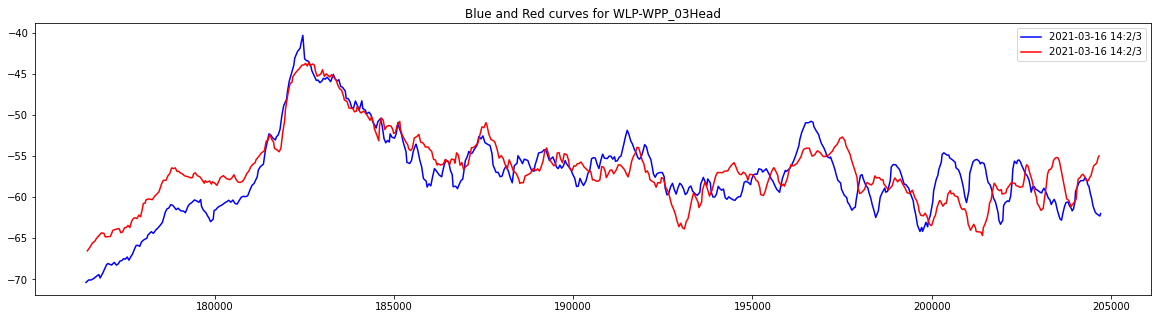

In [109]:
i = 0
plt.plot(ad_test['primary_kp'].iloc[i],ad_test['primary_rssi_dbm'].iloc[i],'b', label = ad_test['date'].iloc[i])
plt.plot(ad_test['secondary_kp'].iloc[i],ad_test['secondary_rssi_dbm'].iloc[i],'r', label = ad_test['date'].iloc[i])
plt.legend()
plt.title('Blue and Red curves for ' + ad_test['tre_id'].iloc[0] + ad_test['obm_direction'].iloc[0])

In [110]:
# preprocess the curves

In [111]:
# adjust primary kp wrt registered kp
a,b=zip(*ad_test.apply(lambda x : interp_primary_rssi(x,kp_df), axis=1))
# assign kp and rssi
ad_test['primary_kp'] = list(a)
ad_test['primary_rssi_dbm'] = list(b)

In [112]:
# adjust primary kp wrt primary kp
a,b=zip(*ad_test.apply(lambda x : interp_secondary_rssi(x), axis=1))
# assign new secondary kp and rssi
ad_test['secondary_kp'] = list(a)
ad_test['secondary_rssi_dbm'] = list(b)

In [113]:
# get kalman filtered rssi
a,b=zip(*ad_test.apply(lambda x : kalman_rssi(x), axis=1))
ad_test['primary_rssi_dbm'] = list(a)
ad_test['secondary_rssi_dbm'] = list(b)

In [114]:
# flip kp based on increasing or decreasing kp
a,b,c=zip(*ad_test.apply(lambda x : flip_kp(x), axis=1))
ad_test['kp'] = list(a)
ad_test['primary_rssi'] = list(b)
ad_test['secondary_rssi'] = list(c)

In [115]:
# find peak and split rssi
a,b,c,d,e,f=zip(*ad_test.apply(lambda x : find_peak_rssi_split(x), axis=1))
ad_test["primary_kp_peak"] = list(a)
ad_test["secondary_kp_peak"] = list(b)
ad_test["primary_rssi_dbm_ant1"] = list(c)
ad_test["primary_rssi_dbm_ant2"] = list(d)
ad_test["secondary_rssi_dbm_ant1"] = list(e)
ad_test["secondary_rssi_dbm_ant2"] = list(f)

In [116]:
# split kp
a, b, c, d = zip(*ad_test.apply(lambda x : split_kp(x), axis=1))
# add changes to the data 
ad_test["primary_kp_ant1"] = list(a)
ad_test["primary_kp_ant2"] = list(b)
ad_test["secondary_kp_ant1"] = list(c)
ad_test["secondary_kp_ant2"] = list(d)

In [117]:
# interpolate blue antenna level curves    
a, b, c, d = zip(*ad_test.apply(lambda x : interp_primary_rssi_antenna(x,kp_df), axis=1))
# add changes
ad_test['primary_kp_ant1'] = list(a)
ad_test['primary_kp_ant2'] = list(b)
ad_test['primary_rssi_dbm_ant1'] = list(c)
ad_test['primary_rssi_dbm_ant2'] = list(d)

In [118]:
# interpolate red antenna level curves
a, b = zip(*ad_test.apply(lambda x : interp_secondary_rssi_antenna(x), axis=1))
# add changes 
ad_test['secondary_rssi_dbm_ant1'] = list(a)
ad_test['secondary_rssi_dbm_ant2'] = list(b)
ad_test['secondary_kp_ant1'] = ad_test['primary_kp_ant1']
ad_test['secondary_kp_ant2'] = ad_test['primary_kp_ant2']

In [119]:
# flip kp antenna 1 based on inc or dec kp
a,b,c=zip(*ad_test.apply(lambda x : flip_kp_ant1(x), axis=1))
ad_test['kp_ant1'] = list(a)
ad_test['primary_rssi_ant1'] = list(b)
ad_test['secondary_rssi_ant1'] = list(c)

In [120]:
# flip kp antenna 1 based on inc or dec kp
a,b,c=zip(*ad_test.apply(lambda x : flip_kp_ant2(x), axis=1))
ad_test['kp_ant2'] = list(a)
ad_test['primary_rssi_ant2'] = list(b)
ad_test['secondary_rssi_ant2'] = list(c)

In [121]:
# datagrid
ad_test['primary_fdata'] = ad_test.apply(lambda x : fdata_primary(x), axis=1)
ad_test['secondary_fdata'] = ad_test.apply(lambda x : fdata_secondary(x), axis=1)

In [122]:
# functional form
ad_test['primary_fpca'] = ad_test.apply(lambda row : FPCA(row["primary_fdata"]),axis=1) 
ad_test['secondary_fpca'] = ad_test.apply(lambda row : FPCA(row["secondary_fdata"]),axis=1)

In [123]:
# fpca reconstruction
ad_test['primary_fpca_predict'] = ad_test[ad_test['primary_fpca'].notnull()].apply(lambda row : row["primary_fpca"].evaluate(row["primary_fdata"].sample_points[0])[0],axis=1)
ad_test['secondary_fpca_predict'] = ad_test[ad_test['secondary_fpca'].notnull()].apply(lambda row : row["secondary_fpca"].evaluate(row["secondary_fdata"].sample_points[0])[0],axis=1)

Text(0.5, 1.0, 'Actual and FPCA reconstructed curves')

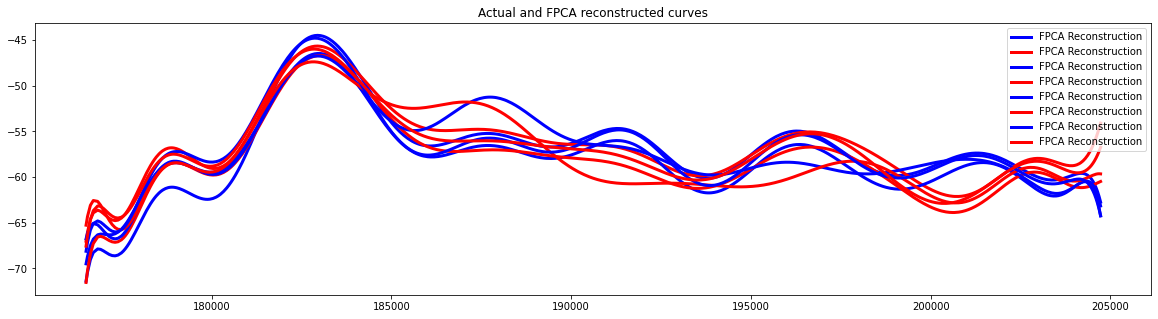

In [124]:
# fpca reconstruction
for fid in range(len(ad_test)):
#     plt.plot(ad_test['kp'].iloc[fid],ad_test['primary_rssi'].iloc[fid],'b',label = 'Blue AP')
    plt.plot(ad_test['kp'].iloc[fid],ad_test['primary_fpca_predict'].iloc[fid],'b',label = 'FPCA Reconstruction',linewidth = 3)
#     plt.plot(ad_test['kp'].iloc[fid],ad_test['secondary_rssi'].iloc[fid],'r',label = 'Red AP')
    plt.plot(ad_test['kp'].iloc[fid],ad_test['secondary_fpca_predict'].iloc[fid],'r',label = 'FPCA Reconstruction',linewidth = 3)
plt.legend()
plt.title('Actual and FPCA reconstructed curves')

Text(0.5, 1.0, 'Actual and FPCA reconstructed curves')

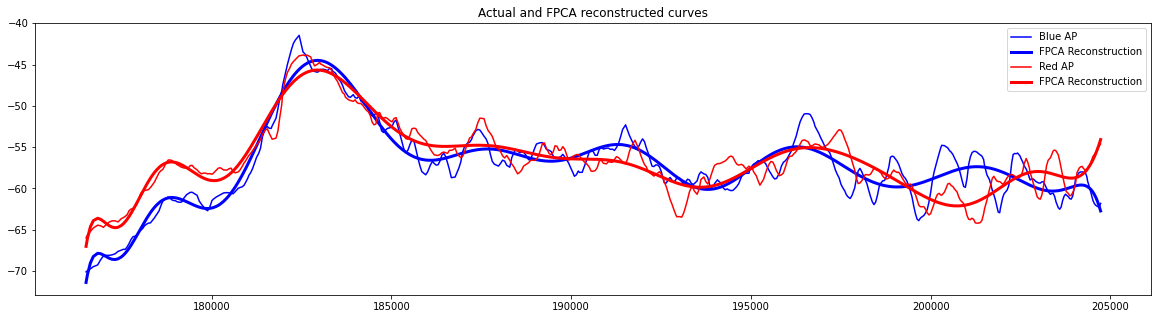

In [125]:
# degraded fpca reconstruction
fid = 0

plt.plot(ad_test['kp'].iloc[fid],ad_test['primary_rssi'].iloc[fid],'b',label = 'Blue AP')
plt.plot(ad_test['kp'].iloc[fid],ad_test['primary_fpca_predict'].iloc[fid],'b',label = 'FPCA Reconstruction',linewidth = 3)
plt.plot(ad_test['kp'].iloc[fid],ad_test['secondary_rssi'].iloc[fid],'r',label = 'Red AP')
plt.plot(ad_test['kp'].iloc[fid],ad_test['secondary_fpca_predict'].iloc[fid],'r',label = 'FPCA Reconstruction',linewidth = 3)
plt.legend()
plt.title('Actual and FPCA reconstructed curves')

In [126]:
# antenna 1 data grid
a,b = zip(*ad_test.apply(lambda x : fdata_primary_antenna(x), axis=1))
ad_test['primary_fdata_ant1'] = list(a)
ad_test['primary_fdata_ant2'] = list(b)

In [127]:
# antenna 2 data grid
a,b = zip(*ad_test.apply(lambda x : fdata_secondary_antenna(x), axis=1))
ad_test['secondary_fdata_ant1'] = list(a)
ad_test['secondary_fdata_ant2'] = list(b)

In [128]:
# functional form of antennas
ad_test['primary_fpca_ant1'] = ad_test.apply(lambda row : FPCA(row["primary_fdata_ant1"]),axis=1) 
ad_test['secondary_fpca_ant1'] = ad_test.apply(lambda row : FPCA(row["secondary_fdata_ant1"]),axis=1)  
ad_test['primary_fpca_ant2'] = ad_test.apply(lambda row : FPCA(row["primary_fdata_ant2"]),axis=1) 
ad_test['secondary_fpca_ant2'] = ad_test.apply(lambda row : FPCA(row["secondary_fdata_ant2"]),axis=1)  

In [129]:
# fpca reconstruction for primary ap for both antennas
ad_test['primary_fpca_predict_ant1'] = ad_test[ad_test['primary_fpca_ant1'].notnull()].apply(lambda row : row["primary_fpca_ant1"].evaluate(row["primary_fdata_ant1"].sample_points[0])[0],axis=1)
ad_test['primary_fpca_predict_ant2'] = ad_test[ad_test['primary_fpca_ant2'].notnull()].apply(lambda row : row["primary_fpca_ant2"].evaluate(row["primary_fdata_ant2"].sample_points[0])[0],axis=1)

In [130]:
# fpca reconstruction for secondary ap for both antennas
ad_test['secondary_fpca_predict_ant1'] = ad_test[ad_test['secondary_fpca_ant1'].notnull()].apply(lambda row : row["secondary_fpca_ant1"].evaluate(row["secondary_fdata_ant1"].sample_points[0])[0],axis=1)
ad_test['secondary_fpca_predict_ant2'] = ad_test[ad_test['secondary_fpca_ant2'].notnull()].apply(lambda row : row["secondary_fpca_ant2"].evaluate(row["secondary_fdata_ant2"].sample_points[0])[0],axis=1)

Text(0.5, 1.0, 'Actual and FPCA reconstructed curves antenna 1')

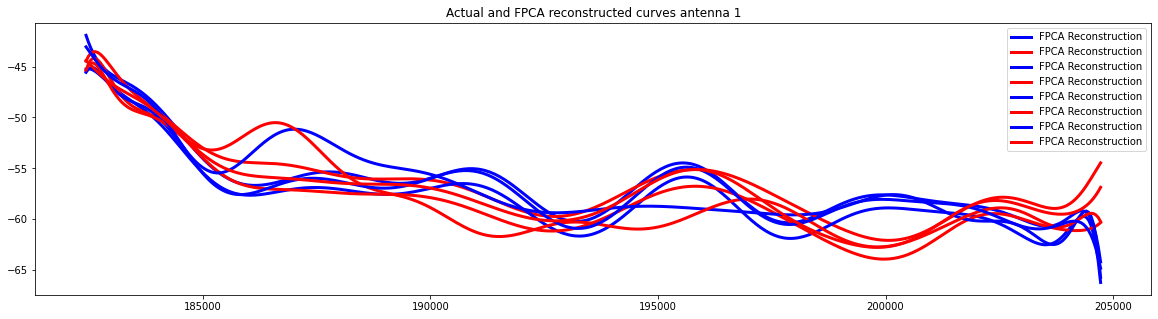

In [131]:
# sample fpca antenna 1 reconstruction
for fid in range(len(ad_test)):
#     plt.plot(ad_test['kp_ant1'].iloc[fid],ad_test['primary_rssi_ant1'].iloc[fid],'b',label = 'Blue AP')
    plt.plot(ad_test['kp_ant1'].iloc[fid],ad_test['primary_fpca_predict_ant1'].iloc[fid],'b',label = 'FPCA Reconstruction',linewidth = 3)
#     plt.plot(ad_test['kp_ant1'].iloc[fid],ad_test['secondary_rssi_ant1'].iloc[fid],'r',label = 'Red AP')
    plt.plot(ad_test['kp_ant1'].iloc[fid],ad_test['secondary_fpca_predict_ant1'].iloc[fid],'r',label = 'FPCA Reconstruction',linewidth = 3)
plt.legend()
plt.title('Actual and FPCA reconstructed curves antenna 1')

Text(0.5, 1.0, 'Actual and FPCA reconstructed curves antenna 2')

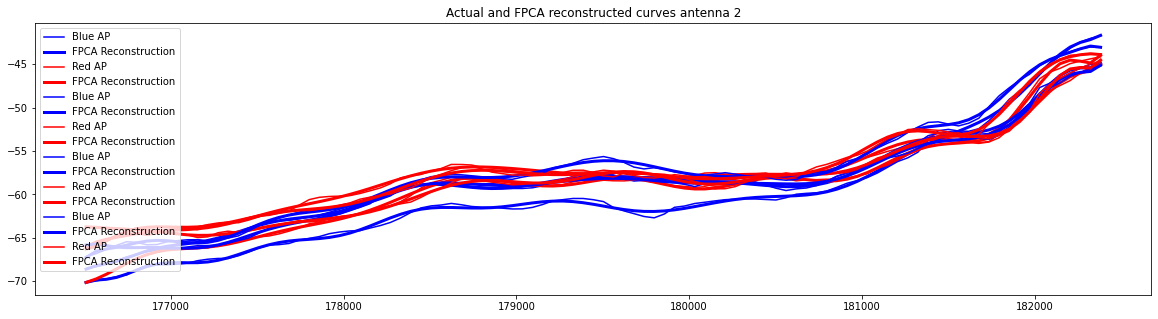

In [132]:
# sample fpca antenna 2 reconstruction
for fid in range(len(ad_test)):
    plt.plot(ad_test['kp_ant2'].iloc[fid],ad_test['primary_rssi_ant2'].iloc[fid],'b',label = 'Blue AP')
    plt.plot(ad_test['kp_ant2'].iloc[fid],ad_test['primary_fpca_predict_ant2'].iloc[fid],'b',label = 'FPCA Reconstruction',linewidth = 3)
    plt.plot(ad_test['kp_ant2'].iloc[fid],ad_test['secondary_rssi_ant2'].iloc[fid],'r',label = 'Red AP')
    plt.plot(ad_test['kp_ant2'].iloc[fid],ad_test['secondary_fpca_predict_ant2'].iloc[fid],'r',label = 'FPCA Reconstruction',linewidth = 3)
plt.legend()
plt.title('Actual and FPCA reconstructed curves antenna 2')

In [133]:
# error
ad_test['primary_fpca_r2'] = ad_test[ad_test['primary_fpca'].notnull()].apply(lambda row : eval_r2(row["primary_fdata"],row["primary_fpca"]),axis=1)
ad_test['secondary_fpca_r2'] = ad_test[ad_test['secondary_fpca'].notnull()].apply(lambda row : eval_r2(row["secondary_fdata"],row["secondary_fpca"]),axis=1)

HI-2 computation

In [134]:
# distance bewteen primary and secondary computation
ad_test['distance_primary_secondary'] = ad_test[ad_test['primary_fpca_r2'] > 0.5].apply(lambda row : compute_distance_primary_secondary(row),axis=1)

In [135]:
# distance from baseline to blue and red curves
a,b=zip(*ad_test.apply(lambda x : compute_distance_baseline(x,tre_baseline_df), axis=1))
ad_test['primary_dist'] = list(a)
ad_test['secondary_dist'] = list(b)

In [136]:
# distance from antenna 1 baseline to antenna 1 blue and red curves
c,d=zip(*ad_test.apply(lambda x : compute_distance_baseline_ant1(x,tre_baseline_df), axis=1))
ad_test['primary_dist_ant1'] = list(c)
ad_test['secondary_dist_ant1'] = list(d)

In [137]:
# distance from antenna 1 baseline to antenna 1 blue and red curves
e,f=zip(*ad_test.apply(lambda x : compute_distance_baseline_ant2(x,tre_baseline_df), axis=1))
ad_test['primary_dist_ant2'] = list(e)
ad_test['secondary_dist_ant2'] = list(f)

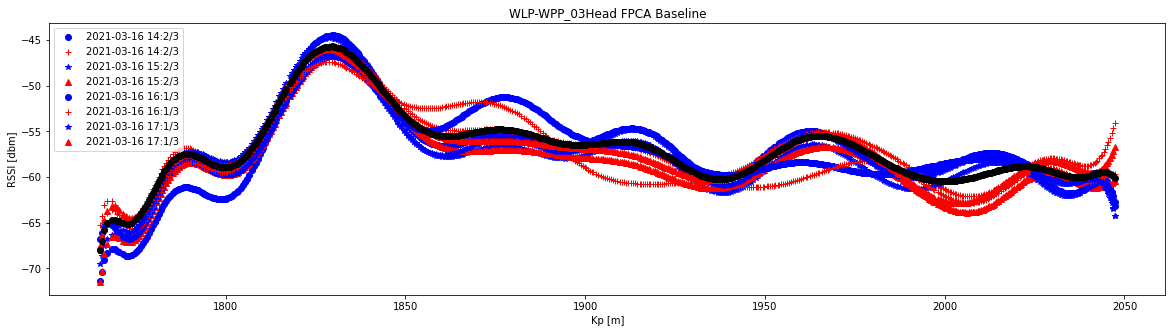

In [138]:
# plot the curves
for i in range(len(ad_test)):
    plt.plot(ad_test['kp'].iloc[i]/100,ad_test['primary_fpca_predict'].iloc[i], marker = next(marker),color = 'b', label = ad_test['date'].iloc[i],linestyle='')
    plt.plot(ad_test['kp'].iloc[i]/100,ad_test['secondary_fpca_predict'].iloc[i], marker = next(marker),color = 'r', label = ad_test['date'].iloc[i],linestyle='')
    plt.legend()
    plt.title(ad_test['tre_id'].iloc[i] + ad_test['obm_direction'].iloc[i]+' FPCA Baseline')
    plt.ylabel('RSSI [dbm]')
    plt.xlabel('Kp [m]')
plt.plot(ad_test['kp'].iloc[0]/100,baseline_test['fpca_baseline'].iloc[0], marker = 'o',color = 'k', label = 'FPCA Baseline',linestyle='')

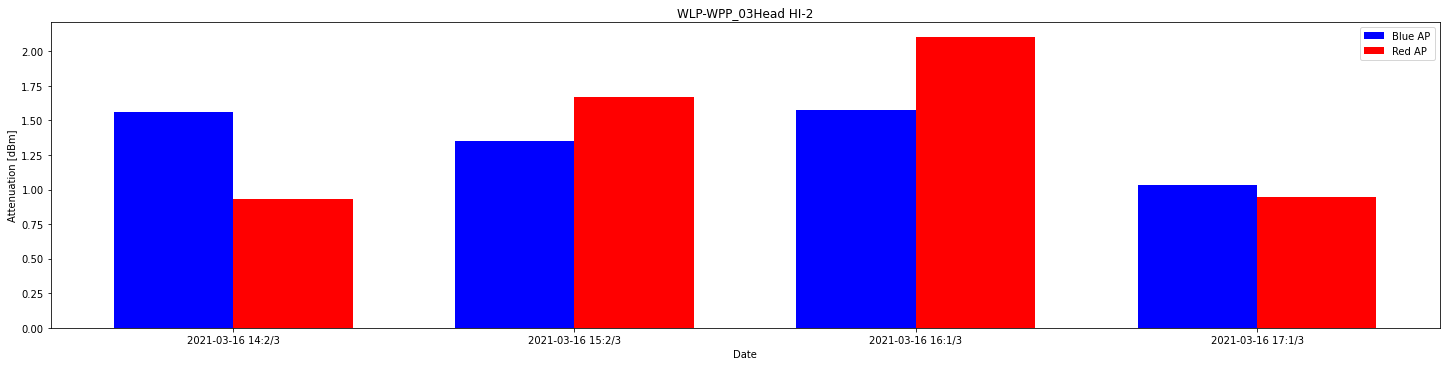

In [139]:
# HI-2    
fig, ax = plt.subplots()
ad_test.index.values
x = np.arange(len(ad_test))
# x = np.arange(int(ad_test.index.values.min()),int(ad_test.index.values.max()) + 1)  # the label locations
width = 0.35  # the width of the bars

rects1 = ax.bar(x - width/2, ad_test['primary_dist'], width , label='Blue AP',color='b')
rects2 = ax.bar(x + width/2, ad_test['secondary_dist'], width , label='Red AP',color='r')

ax.set_xticks(x)
ax.set_xticklabels(ad_test['date'])
ax.legend()
plt.title(ad_test['tre_id'].iloc[0] + ad_test['obm_direction'].iloc[0] + ' HI-2')
fig.tight_layout()
plt.xlabel('Date')
plt.ylabel('Attenuation [dBm]')
plt.show()

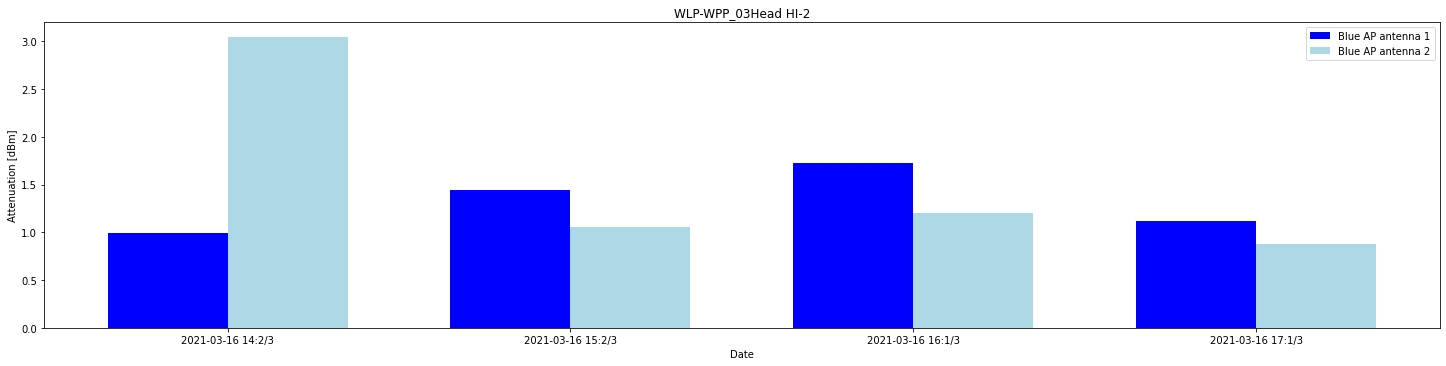

In [140]:
# HI primary    
fig, ax = plt.subplots()
ad_test.index.values
x = np.arange(len(ad_test))  # the label locations
y = [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5]
width = 0.35  # the width of the bars

rects1 = ax.bar(x - width/2, ad_test['primary_dist_ant1'], width , label='Blue AP antenna 1',color='b')
rects2 = ax.bar(x + width/2, ad_test['primary_dist_ant2'], width , label='Blue AP antenna 2',color='lightblue')

ax.set_xticks(x)
ax.set_xticklabels(ad_test['date'])
ax.legend()
plt.title(ad_test['tre_id'].iloc[0] + ad_test['obm_direction'].iloc[0] + ' HI-2')
fig.tight_layout()
plt.xlabel('Date')
plt.ylabel('Attenuation [dBm]')
plt.show()

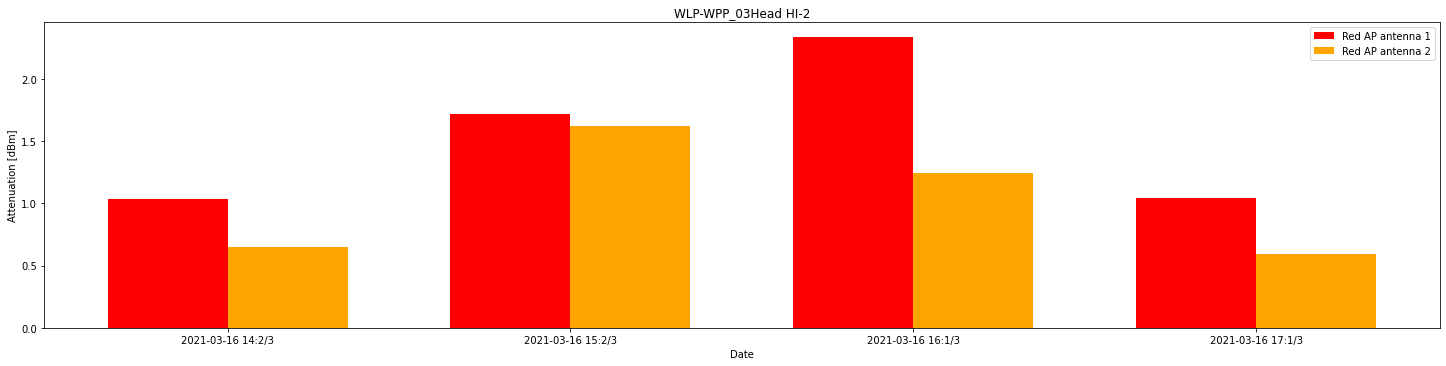

In [141]:
# HI secondary    
fig, ax = plt.subplots()
ad_test.index.values
x = np.arange(len(ad_test))  # the label locations
y = [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5]
width = 0.35  # the width of the bars

rects1 = ax.bar(x - width/2, ad_test['secondary_dist_ant1'], width , label='Red AP antenna 1',color='r')
rects2 = ax.bar(x + width/2, ad_test['secondary_dist_ant2'], width , label='Red AP antenna 2',color='orange')

ax.set_xticks(x)
ax.set_xticklabels(ad_test['date'])
ax.legend()
plt.title(ad_test['tre_id'].iloc[0] + ad_test['obm_direction'].iloc[0] + ' HI-2')
fig.tight_layout()
plt.xlabel('Date')
plt.ylabel('Attenuation [dBm]')
plt.show()

In [142]:
hi = 3
ad_test[(ad_test['primary_dist'] > hi) | (ad_test['secondary_dist'] > hi) | (ad_test['primary_dist_ant1'] > hi) | (ad_test['secondary_dist_ant1'] > hi) | (ad_test['primary_dist_ant2'] > hi) | (ad_test['secondary_dist_ant2'] > hi)].reset_index(drop = True)

,primary_mac_address,train_id,obm_direction,date,primary_rssi_dbm,primary_kp,secondary_mac_address,secondary_rssi_dbm,secondary_kp,secondary_connection,...,secondary_fpca_predict_ant2,primary_fpca_r2,secondary_fpca_r2,distance_primary_secondary,primary_dist,secondary_dist,primary_dist_ant1,secondary_dist_ant1,primary_dist_ant2,secondary_dist_ant2
0,00:14:5a:02:31:5e,121,Head,2021-03-16 14:2/3,"[-61.819117647058775, -62.276818414514075, -62...","[204725.5, 204683.0, 204640.5, 204598.0, 20455...",00:14:5a:02:36:4a,"[-54.60955882352815, -54.901509813920846, -55....","[204725.5, 204683.0, 204640.5, 204598.0, 20455...",False,...,"[[-66.0462757253233], [-65.48514189044441], [-...",0.886934,0.889158,32.783139,1.559212,0.928426,0.991044,1.037889,3.046973,0.647012


Simulation of curves and degradations

In [143]:
# load the dataset
sim_br_df = pd.read_pickle("RSSI_cBLUE_RED_TU121_16Mars2021.zip",compression="zip")
sim_br_df

,primary_mac_address,train_id,obm_direction,date,primary_rssi_dbm,primary_kp,secondary_mac_address,secondary_rssi_dbm,secondary_kp,secondary_connection,ap_mac_address,tre_ap_name,tre_id,ap_physical_name,ap_name_geo,ap_color,ap_kp_in_track,kp_inc
0,00:14:5a:02:31:2d,121,Tail,2021-03-16 09:1/3,"[-50.0, -48.5, -47.525000000000006, -46.99625,...","[181368.75, 181426.25, 181483.75, 181541.25, 1...",00:14:5a:03:08:6c,"[-42.0, -41.400000000000006, -40.7400000000000...","[181397.5, 181455.0, 181512.5, 181570.0, 18162...",False,00:14:5a:02:31:2d,WLP-WPP_03B_BLUE,WLP-WPP_03B,WLP-WPP_03B_RAP_BLUE,WPP_03B_BLUE,BLUE,179400.0,True
1,00:14:5a:02:31:2d,121,Tail,2021-03-16 10:1/3,"[-50.0, -49.550000000000004, -48.1175, -47.649...","[181407.5, 181462.5, 181517.5, 181572.5, 18165...",00:14:5a:03:08:6c,"[-42.0, -41.85000000000001, -41.57250000000000...","[181435.0, 181490.0, 181545.0, 181626.25, 1816...",False,00:14:5a:02:31:2d,WLP-WPP_03B_BLUE,WLP-WPP_03B,WLP-WPP_03B_RAP_BLUE,WPP_03B_BLUE,BLUE,179400.0,True
2,00:14:5a:02:31:2d,121,Tail,2021-03-16 11:1/3,"[-38.0, -37.85, -37.8725, -37.59162500000001, ...","[181950.0, 182000.0, 182050.0, 182100.0, 18215...",00:14:5a:03:08:6c,"[-37.0, -37.150000000000006, -37.1275000000000...","[181975.0, 182025.0, 182075.0, 182125.0, 18217...",False,00:14:5a:02:31:2d,WLP-WPP_03B_BLUE,WLP-WPP_03B,WLP-WPP_03B_RAP_BLUE,WPP_03B_BLUE,BLUE,179400.0,True
3,00:14:5a:02:31:2d,121,Tail,2021-03-16 12:3/3,"[-56.0, -55.550000000000004, -55.4675, -54.647...","[181306.0975609756, 181357.31707317077, 181408...",00:14:5a:03:08:6c,"[-50.0, -49.85, -49.1225, -48.504125, -47.2285...","[181331.7073170732, 181382.92682926828, 181434...",False,00:14:5a:02:31:2d,WLP-WPP_03B_BLUE,WLP-WPP_03B,WLP-WPP_03B_RAP_BLUE,WPP_03B_BLUE,BLUE,179400.0,True
4,00:14:5a:02:31:2d,121,Tail,2021-03-16 16:2/3,"[-51.0, -52.050000000000004, -51.8925, -52.658...","[181236.58536585365, 181285.36585365853, 18133...",00:14:5a:03:08:6c,"[-52.0, -52.00000000000001, -51.10000000000001...","[181260.9756097561, 181309.75609756095, 181358...",False,00:14:5a:02:31:2d,WLP-WPP_03B_BLUE,WLP-WPP_03B,WLP-WPP_03B_RAP_BLUE,WPP_03B_BLUE,BLUE,179400.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
811,00:14:5a:03:06:1b,121,Head,2021-03-16 14:2/3,"[-64.0, -64.45, -64.9825, -64.23512500000001, ...","[115465.78048780488, 115414.56097560975, 11536...",00:14:5a:02:3a:1a,"[-52.0, -51.85, -52.3225, -52.274125000000005,...","[115440.17073170732, 115388.9512195122, 115337...",False,00:14:5a:03:06:1b,NMT-WLP_01_BLUE,NMT-WLP_01,NMT-WLP_01_RAP_BLUE,WLP_01_BLUE,BLUE,102600.0,False
812,00:14:5a:03:06:1b,121,Head,2021-03-16 15:2/3,"[-66.0, -66.15, -66.5775, -65.740875, -65.0297...","[115496.26829268291, 115445.0487804878, 115393...",00:14:5a:02:3a:1a,"[-53.0, -52.85, -53.1725, -53.146625, -54.0246...","[115470.65853658535, 115419.43902439025, 11536...",False,00:14:5a:03:06:1b,NMT-WLP_01_BLUE,NMT-WLP_01,NMT-WLP_01_RAP_BLUE,WLP_01_BLUE,BLUE,102600.0,False
813,00:14:5a:03:06:1b,121,Head,2021-03-16 17:1/3,"[-67.0, -67.0, -66.7, -65.845, -65.26825, -63....","[115458.02564102564, 115406.7435897436, 115355...",00:14:5a:02:3a:1a,"[-51.0, -51.75, -52.2375, -52.951875, -53.5590...","[115432.3846153846, 115381.10256410256, 115329...",False,00:14:5a:03:06:1b,NMT-WLP_01_BLUE,NMT-WLP_01,NMT-WLP_01_RAP_BLUE,WLP_01_BLUE,BLUE,102600.0,False
814,00:14:5a:03:08:6c,121,Tail,2021-03-16 15:2/3,"[-50.0, -49.7, -49.29500000000001, -49.1007500...","[205673.66666666663, 205699.85714285716, 20572...",00:14:5a:02:31:2d,"[-56.0, -55.7, -55.595, -55.65575, -55.8573875...","[205686.7619047619, 205712.9523809524, 205739....",True,00:14:5a:03:08:6c,WLP-WPP_03B_RED,WLP-WPP_03B,WLP-WPP_03B_RAP_RED,WPP_03B_RED,RED,179400.0,True


In [144]:
# split into 2 datasets. One for simulating curves to build the model. Other to test the model
br_df_sim_test = sim_br_df[791:].reset_index(drop = True)
sim_br_df = sim_br_df[:791]
# get the rows which have to be subset for testing
sim_con = sim_br_df.index.isin([30,31,32,33])
sim_br_df = sim_br_df[~sim_con].reset_index(drop = True)

In [145]:
# function to add noise in the data
# set a seed to reproduce the same results everytime
np.random.seed(123)

def noise_rssi(size,level):
    return [random.gauss(0,level) for _ in range(size)]

In [146]:
# add a column to use as a flag to drop rows
sim_br_df['delete_flag'] = 0
sim_br_df['actual_curve'] = 1

In [147]:
# create a copy
sim_br_df_copy = sim_br_df.copy()

In [148]:
tre_list = sim_br_df_copy['tre_id'].to_list()
direction_list = sim_br_df_copy['obm_direction'].to_list()
kp_inc_list = sim_br_df_copy['kp_inc'].to_list()
date_list = sim_br_df_copy['date'].to_list()

In [149]:
# Simulating curves for each tre
# br_df_copy = br_df.copy() # create a copy to use for iterating through the tre and direction variables
sig_sig=1 #simulate artificial noise and smooth with splines
Nsim=1 #simulate Nsim blue-red pair curves for the selected TRE

for tre,direction,kp_inc,date_val in zip(tre_list, direction_list,kp_inc_list,date_list):
    sim_br_df_temp = sim_br_df_copy[(sim_br_df_copy['tre_id'] == tre) & (sim_br_df_copy['obm_direction'] == direction) & (sim_br_df_copy['kp_inc'] == kp_inc) & (sim_br_df_copy['date'] == date_val)].copy() #a deep copy
    for ind in sim_br_df_temp.index:
        sim_br_df_cd = sim_br_df_temp.loc[[ind]]
        for i in range(0,Nsim):
            xp=sim_br_df_cd['primary_kp'].iloc[0]
            yp=sim_br_df_cd["primary_rssi_dbm"].iloc[0]
            xs=sim_br_df_cd['secondary_kp'].iloc[0]
            ys=sim_br_df_cd["secondary_rssi_dbm"].iloc[0]
            rssi_primary_fake = yp+noise_rssi(len(yp),sig_sig)
            rssi_secondary_fake = ys+noise_rssi(len(ys),sig_sig)
            #if br_df_cd_copy['direction'].iloc[0]=='Head':
            if sim_br_df_cd['kp_inc'].iloc[0]==False:
                xp=np.flip(xp)
                yp=np.flip(yp)
                rssi_primary_fake=np.flip(rssi_primary_fake)
                xs=np.flip(xs)
                ys=np.flip(ys)
                rssi_secondary_fake=np.flip(rssi_secondary_fake)
            splp = UnivariateSpline(xp, rssi_primary_fake)
            spls = UnivariateSpline(xs, rssi_secondary_fake)
            #xs = np.flip(br_df_cd_copy["Kp"].iloc[0])
            #plt.plot(br_df_cd_copy["Kp"].iloc[0],br_df_cd_copy['RSSI'].iloc[0],'b')
            splp.set_smoothing_factor(len(xp)*random.uniform(0.5, 1))
            spls.set_smoothing_factor(len(xs)*random.uniform(0.5, 1))
            ysp=splp(xp)
            yss=spls(xs)
            #if br_df_cd_copy['direction'].iloc[0]=='Head':
            if sim_br_df_cd['kp_inc'].iloc[0]==False:    
                ysp=np.flip(ysp)
                yss=np.flip(yss)
            #br_df_cd_copy.at[br_df_cd_copy.index[0],"rKp"] = br_df_cd['Kp'].iloc[0]
#             print(np.round(ysb,2))
            if np.isnan(sum(ysp)) or np.isnan(sum(yss)):
                sim_br_df_cd['delete_flag'].iloc[0] = 1
            sim_br_df_cd.at[sim_br_df_cd.index[0],"primary_rssi_dbm"] = np.round(ysp,2) #round to second decimal
            sim_br_df_cd.at[sim_br_df_cd.index[0],"secondary_rssi_dbm"] = np.round(yss,2)
            sim_br_df_cd.at[sim_br_df_cd.index[0],"actual_curve"] = 0
            # increment the date - extract only the hour
            date = datetime.datetime.strptime(sim_br_df_cd['date'].iloc[0][0:13],"%Y-%m-%d %H")
            date += datetime.timedelta(days= i+1)
            sim_br_df_cd.at[sim_br_df_cd.index[0],"date"] = date.strftime("%Y-%m-%d %H") + sim_br_df_cd['date'].iloc[0][-4:]
            sim_br_df=sim_br_df.append(sim_br_df_cd, ignore_index=True)
    #     print(tre,k)

In [150]:
# get the simulated curves and drop the real ones
sim_df = sim_br_df[(sim_br_df['delete_flag'] == 0) & (sim_br_df['actual_curve'] == 0)].reset_index(drop = True).drop(columns = ['delete_flag','actual_curve'])

Add degradations

In [151]:
# create new columns to save type of degradation and level of attenuation
sim_df['type_degradation'] = np.nan
sim_df['degraded_ap'] = np.nan
sim_df['attenuation'] = np.nan
sim_df['degraded_antenna'] = np.nan
sim_df['tilt_degree'] = np.nan

In [152]:
for i in range(len(sim_df)):
    degradation = np.random.choice(['constant attenuation','antenna tilt','single sided attenuation'])
    ap = np.random.choice(['primary','secondary'])
    
    
    sim_df['type_degradation'].iloc[i] = degradation
    sim_df['degraded_ap'].iloc[i] = ap
    
    if degradation == 'constant attenuation':
        
#         print('adding constant attenuation')
        
        attenuation = np.random.choice([2,3,4,5])
        sim_df['attenuation'].iloc[i] = attenuation
        
        degraded_rssi = constant_attenuation(sim_df.iloc[i].copy(), attenuation, access_point = ap, antenna = ant)
        
    elif degradation == 'antenna tilt':
        
#         print('adding antenna tilt')

        tilt = np.random.choice([10,15,20,25,30])
        ant = np.random.choice([1,2])
        
#         if type(sim_df[ap+'_rssi_dbm_ant'+str(ant)].iloc[i]) in [float,np.float64]:
#             ant = list(set([1,2]) - set([ant]))[0]
            
        sim_df['tilt_degree'].iloc[i] = tilt
        sim_df['degraded_antenna'].iloc[i] = ant
        
        degraded_rssi = antenna_tilt_change(sim_df.iloc[i].copy(),tilt_degree = tilt, access_point = ap, antenna = ant)
    
    else:
        attenuation = np.random.choice([2,3,4,5])
        ant = np.random.choice([1,2])
        
#         if type(sim_df[ap+'_rssi_dbm_ant'+str(ant)].iloc[i]) in [float,np.float64]:
#             ant = list(set([1,2]) - set([ant]))[0]
            
        sim_df['attenuation'].iloc[i] = attenuation
        sim_df['degraded_antenna'].iloc[i] = ant
    
        degraded_rssi = constant_attenuation(sim_df.iloc[i].copy(), attenuation, access_point = ap, single_side = True, antenna = ant)

    if ap == 'primary':
        sim_df['primary_rssi_dbm'].iloc[i] = degraded_rssi
    else:
        sim_df['secondary_rssi_dbm'].iloc[i] = degraded_rssi

In [153]:
# apply function
a,b=zip(*sim_df.apply(lambda x : interp_primary_rssi(x,kp_df), axis=1))
# assign kp and rssi
sim_df['primary_kp'] = list(a)
sim_df['primary_rssi_dbm'] = list(b)

In [154]:
# drop the curves which have RSSI nan 
sim_df = sim_df[sim_df['primary_rssi_dbm'].notna()].reset_index(drop = True)

In [155]:
# apply function
a,b=zip(*sim_df.apply(lambda x : interp_secondary_rssi(x), axis=1))
# assign new secondary kp and rssi
sim_df['secondary_kp'] = list(a)
sim_df['secondary_rssi_dbm'] = list(b)

In [156]:
# get kalman filtered rssi
a,b=zip(*sim_df.apply(lambda x : kalman_rssi(x), axis=1))
sim_df['primary_rssi_dbm'] = list(a)
sim_df['secondary_rssi_dbm'] = list(b)

In [157]:
a,b,c=zip(*sim_df.apply(lambda x : flip_kp(x), axis=1))
sim_df['kp'] = list(a)
sim_df['primary_rssi'] = list(b)
sim_df['secondary_rssi'] = list(c)

In [158]:
# add changes to the data
a,b,c,d,e,f=zip(*sim_df.apply(lambda x : find_peak_rssi_split(x), axis=1))
sim_df["primary_kp_peak"] = list(a)
sim_df["secondary_kp_peak"] = list(b)
sim_df["primary_rssi_dbm_ant1"] = list(c)
sim_df["primary_rssi_dbm_ant2"] = list(d)
sim_df["secondary_rssi_dbm_ant1"] = list(e)
sim_df["secondary_rssi_dbm_ant2"] = list(f)

In [159]:
# apply function
a, b, c, d = zip(*sim_df.apply(lambda x : split_kp(x), axis=1))
# add changes to the data 
sim_df["primary_kp_ant1"] = list(a)
sim_df["primary_kp_ant2"] = list(b)
sim_df["secondary_kp_ant1"] = list(c)
sim_df["secondary_kp_ant2"] = list(d)

In [160]:
# interpolate blue antenna level curves    
a, b, c, d = zip(*sim_df.apply(lambda x : interp_primary_rssi_antenna(x,kp_df), axis=1))
# add changes
sim_df['primary_kp_ant1'] = list(a)
sim_df['primary_kp_ant2'] = list(b)
sim_df['primary_rssi_dbm_ant1'] = list(c)
sim_df['primary_rssi_dbm_ant2'] = list(d)

In [161]:
# interpolate red antenna level curves
a, b = zip(*sim_df.apply(lambda x : interp_secondary_rssi_antenna(x), axis=1))
# add changes 
sim_df['secondary_rssi_dbm_ant1'] = list(a)
sim_df['secondary_rssi_dbm_ant2'] = list(b)
sim_df['secondary_kp_ant1'] = sim_df['primary_kp_ant1']
sim_df['secondary_kp_ant2'] = sim_df['primary_kp_ant2']

In [162]:
a,b,c=zip(*sim_df.apply(lambda x : flip_kp_ant1(x), axis=1))
sim_df['kp_ant1'] = list(a)
sim_df['primary_rssi_ant1'] = list(b)
sim_df['secondary_rssi_ant1'] = list(c)

In [163]:
a,b,c=zip(*sim_df.apply(lambda x : flip_kp_ant2(x), axis=1))
sim_df['kp_ant2'] = list(a)
sim_df['primary_rssi_ant2'] = list(b)
sim_df['secondary_rssi_ant2'] = list(c)

In [164]:
sim_df['primary_fdata'] = sim_df.apply(lambda x : fdata_primary(x), axis=1)
sim_df['secondary_fdata'] = sim_df.apply(lambda x : fdata_secondary(x), axis=1)

In [165]:
# functional form
sim_df['primary_fpca'] = sim_df.apply(lambda row : FPCA(row["primary_fdata"]),axis=1) 
sim_df['secondary_fpca'] = sim_df.apply(lambda row : FPCA(row["secondary_fdata"]),axis=1)  

In [166]:
# fpca reconstruction
sim_df['primary_fpca_predict'] = sim_df[sim_df['primary_fpca'].notnull()].apply(lambda row : row["primary_fpca"].evaluate(row["primary_fdata"].sample_points[0])[0],axis=1)
sim_df['secondary_fpca_predict'] = sim_df[sim_df['secondary_fpca'].notnull()].apply(lambda row : row["secondary_fpca"].evaluate(row["secondary_fdata"].sample_points[0])[0],axis=1)

Text(0.5, 1.0, 'Actual and FPCA reconstructed curves')

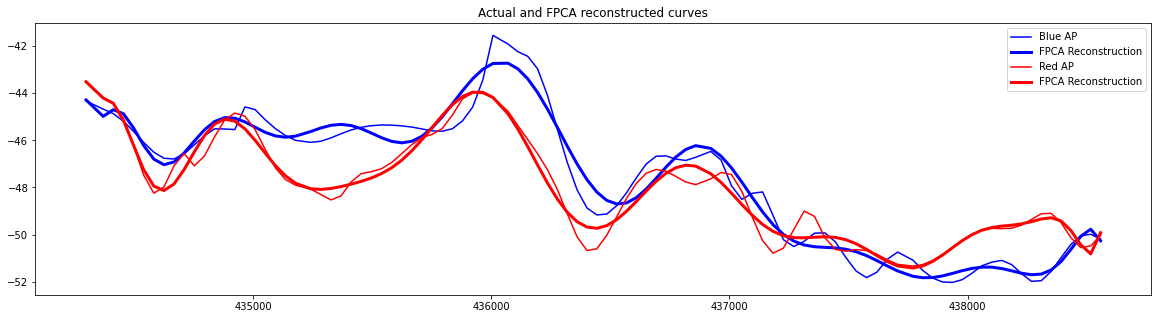

In [167]:
# sample fpca reconstruction
fid = 567

plt.plot(sim_df['kp'].iloc[fid],sim_df['primary_rssi'].iloc[fid],'b',label = 'Blue AP')
plt.plot(sim_df['kp'].iloc[fid],sim_df['primary_fpca_predict'].iloc[fid],'b',label = 'FPCA Reconstruction',linewidth = 3)
plt.plot(sim_df['kp'].iloc[fid],sim_df['secondary_rssi'].iloc[fid],'r',label = 'Red AP')
plt.plot(sim_df['kp'].iloc[fid],sim_df['secondary_fpca_predict'].iloc[fid],'r',label = 'FPCA Reconstruction',linewidth = 3)
plt.legend()
plt.title('Actual and FPCA reconstructed curves')

In [168]:
a,b = zip(*sim_df.apply(lambda x : fdata_primary_antenna(x), axis=1))
sim_df['primary_fdata_ant1'] = list(a)
sim_df['primary_fdata_ant2'] = list(b)

In [169]:
a,b = zip(*sim_df.apply(lambda x : fdata_secondary_antenna(x), axis=1))
sim_df['secondary_fdata_ant1'] = list(a)
sim_df['secondary_fdata_ant2'] = list(b)

In [170]:
sim_df['primary_fpca_ant1'] = sim_df.apply(lambda row : FPCA(row["primary_fdata_ant1"]),axis=1) 
sim_df['secondary_fpca_ant1'] = sim_df.apply(lambda row : FPCA(row["secondary_fdata_ant1"]),axis=1)  
sim_df['primary_fpca_ant2'] = sim_df.apply(lambda row : FPCA(row["primary_fdata_ant2"]),axis=1) 
sim_df['secondary_fpca_ant2'] = sim_df.apply(lambda row : FPCA(row["secondary_fdata_ant2"]),axis=1)  

In [171]:
print("FPCA blue antenna 1 generation failures %d%%" % (len(sim_df[sim_df['primary_fpca_ant1'].notnull() == False])*100/len(sim_df)))
print("FPCA red antenna 1 generation failures %d%%" % (len(sim_df[sim_df['secondary_fpca_ant1'].notnull() == False])*100/len(sim_df)))
print("FPCA blue antenna 2 generation failures %d%%" % (len(sim_df[sim_df['primary_fpca_ant2'].notnull() == False])*100/len(sim_df)))
print("FPCA red antenna 2 generation failures %d%%" % (len(sim_df[sim_df['secondary_fpca_ant2'].notnull() == False])*100/len(sim_df)))

FPCA blue antenna 1 generation failures 24%
FPCA red antenna 1 generation failures 24%
FPCA blue antenna 2 generation failures 3%
FPCA red antenna 2 generation failures 4%


In [172]:
# predict primary for both antennas
sim_df['primary_fpca_predict_ant1'] = sim_df[sim_df['primary_fpca_ant1'].notnull()].apply(lambda row : row["primary_fpca_ant1"].evaluate(row["primary_fdata_ant1"].sample_points[0])[0],axis=1)
sim_df['primary_fpca_predict_ant2'] = sim_df[sim_df['primary_fpca_ant2'].notnull()].apply(lambda row : row["primary_fpca_ant2"].evaluate(row["primary_fdata_ant2"].sample_points[0])[0],axis=1)

In [173]:
# predict red for both antennas
sim_df['secondary_fpca_predict_ant1'] = sim_df[sim_df['secondary_fpca_ant1'].notnull()].apply(lambda row : row["secondary_fpca_ant1"].evaluate(row["secondary_fdata_ant1"].sample_points[0])[0],axis=1)
sim_df['secondary_fpca_predict_ant2'] = sim_df[sim_df['secondary_fpca_ant2'].notnull()].apply(lambda row : row["secondary_fpca_ant2"].evaluate(row["secondary_fdata_ant2"].sample_points[0])[0],axis=1)

In [174]:
# error
sim_df['primary_fpca_r2'] = sim_df[sim_df['primary_fpca'].notnull()].apply(lambda row : eval_r2(row["primary_fdata"],row["primary_fpca"]),axis=1)
sim_df['secondary_fpca_r2'] = sim_df[sim_df['secondary_fpca'].notnull()].apply(lambda row : eval_r2(row["secondary_fdata"],row["secondary_fpca"]),axis=1)

In [175]:
# RSSI difference and distance computation
sim_df['distance_primary_secondary'] = sim_df[sim_df['primary_fpca_r2'] > 0.5].apply(lambda row : compute_distance_primary_secondary(row),axis=1)

In [176]:
# distance from baseline to blue and red curves
a,b=zip(*sim_df.apply(lambda x : compute_distance_baseline(x,tre_baseline_df), axis=1))
sim_df['primary_dist'] = list(a)
sim_df['secondary_dist'] = list(b)

In [177]:
# distance from antenna 1 baseline to antenna 1 blue and red curves
c,d=zip(*sim_df.apply(lambda x : compute_distance_baseline_ant1(x,tre_baseline_df), axis=1))
sim_df['primary_dist_ant1'] = list(c)
sim_df['secondary_dist_ant1'] = list(d)

In [178]:
# distance from antenna 1 baseline to antenna 1 blue and red curves
e,f=zip(*sim_df.apply(lambda x : compute_distance_baseline_ant2(x,tre_baseline_df), axis=1))
sim_df['primary_dist_ant2'] = list(e)
sim_df['secondary_dist_ant2'] = list(f)

In [179]:
# select a random acquisition
sid = 24
tre_s = sim_df['tre_id'].iloc[sid]
direction_s = sim_df['obm_direction'].iloc[sid]
kp_inc_s = sim_df['kp_inc'].iloc[sid]

In [180]:
# subset with the respective treid,direction,kp inc flag
sample_df = sim_df[(sim_df['tre_id'] == tre_s) & (sim_df['obm_direction'] == direction_s) & (sim_df['kp_inc'] == kp_inc_s)] 
sample_baseline_df = tre_baseline_df[(tre_baseline_df['tre_id'] == tre_s) & (tre_baseline_df['obm_direction'] == direction_s) & (tre_baseline_df['kp_inc'] == kp_inc_s)]

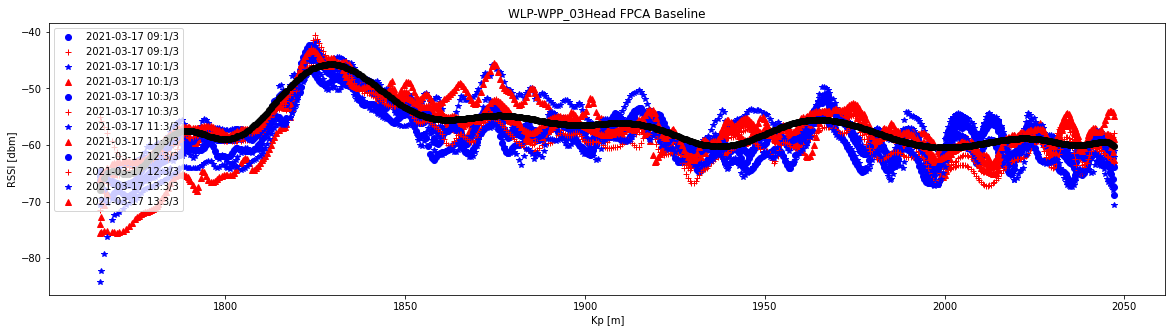

In [181]:
# plot the curves
for i in range(len(sample_df)):
    plt.plot(sample_df['kp'].iloc[i]/100,sample_df['primary_rssi'].iloc[i], marker = next(marker),color = 'b', label = sample_df['date'].iloc[i],linestyle='')
    plt.plot(sample_df['kp'].iloc[i]/100,sample_df['secondary_rssi'].iloc[i], marker = next(marker),color = 'r', label = sample_df['date'].iloc[i],linestyle='')
    plt.legend()
    plt.title(sample_df['tre_id'].iloc[i] + sample_df['obm_direction'].iloc[i]+' FPCA Baseline')
    plt.ylabel('RSSI [dbm]')
    plt.xlabel('Kp [m]')
plt.plot(sample_df['kp'].iloc[0]/100,sample_baseline_df['fpca_baseline'].iloc[0], marker = 'o',color = 'k', label = 'FPCA Baseline',linestyle='')

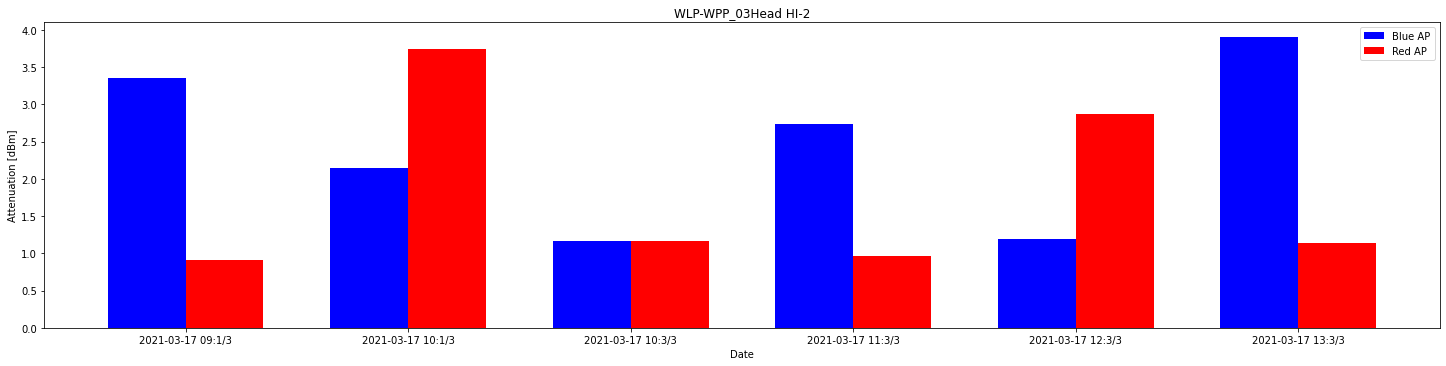

In [182]:
# HI-2    
fig, ax = plt.subplots()
sample_df.index.values
x = np.arange(len(sample_df))
# x = np.arange(int(sample_df.index.values.min()),int(sample_df.index.values.max()) + 1)  # the label locations
width = 0.35  # the width of the bars

rects1 = ax.bar(x - width/2, sample_df['primary_dist'], width , label='Blue AP',color='b')
rects2 = ax.bar(x + width/2, sample_df['secondary_dist'], width , label='Red AP',color='r')

ax.set_xticks(x)
ax.set_xticklabels(sample_df['date'])
ax.legend()
plt.title(sample_df['tre_id'].iloc[0] + sample_df['obm_direction'].iloc[0] + ' HI-2')
fig.tight_layout()
plt.xlabel('Date')
plt.ylabel('Attenuation [dBm]')
plt.show()

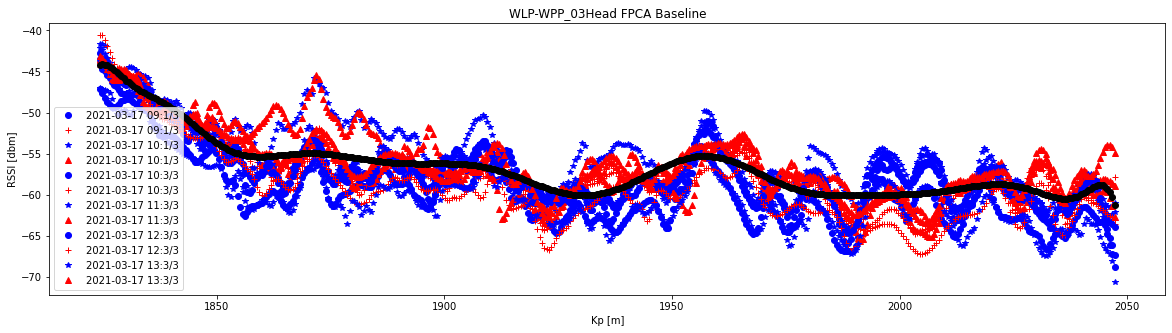

In [183]:
# plot the curves
for i in range(len(sample_df)):
    plt.plot(sample_df['kp_ant1'].iloc[i]/100,sample_df['primary_rssi_ant1'].iloc[i], marker = next(marker),color = 'b', label = sample_df['date'].iloc[i],linestyle='')
    plt.plot(sample_df['kp_ant1'].iloc[i]/100,sample_df['secondary_rssi_ant1'].iloc[i], marker = next(marker),color = 'r', label = sample_df['date'].iloc[i],linestyle='')
    plt.legend()
    plt.title(sample_df['tre_id'].iloc[i] + sample_df['obm_direction'].iloc[i]+' FPCA Baseline')
    plt.ylabel('RSSI [dbm]')
    plt.xlabel('Kp [m]')
plt.plot(sample_df['kp_ant1'].iloc[0]/100,sample_baseline_df['fpca_baseline_ant1'].iloc[0], marker = 'o',color = 'k', label = 'FPCA Baseline',linestyle='')

In [180]:
# # plot the curves
# for i in range(len(sample_df)):
#     plt.plot(sample_df['kp_ant2'].iloc[i]/100,sample_df['primary_rssi_ant2'].iloc[i], marker = next(marker),color = 'b', label = sample_df['date'].iloc[i],linestyle='')
#     plt.plot(sample_df['kp_ant2'].iloc[i]/100,sample_df['secondary_rssi_ant2'].iloc[i], marker = next(marker),color = 'r', label = sample_df['date'].iloc[i],linestyle='')
#     plt.legend()
#     plt.title(sample_df['tre_id'].iloc[i] + sample_df['obm_direction'].iloc[i]+' FPCA Baseline')
#     plt.ylabel('RSSI [dbm]')
#     plt.xlabel('Kp [m]')
# plt.plot(sample_df['kp_ant2'].iloc[0]/100,sample_baseline_df['fpca_baseline_ant2'].iloc[0], marker = 'o',color = 'k', label = 'FPCA Baseline',linestyle='')

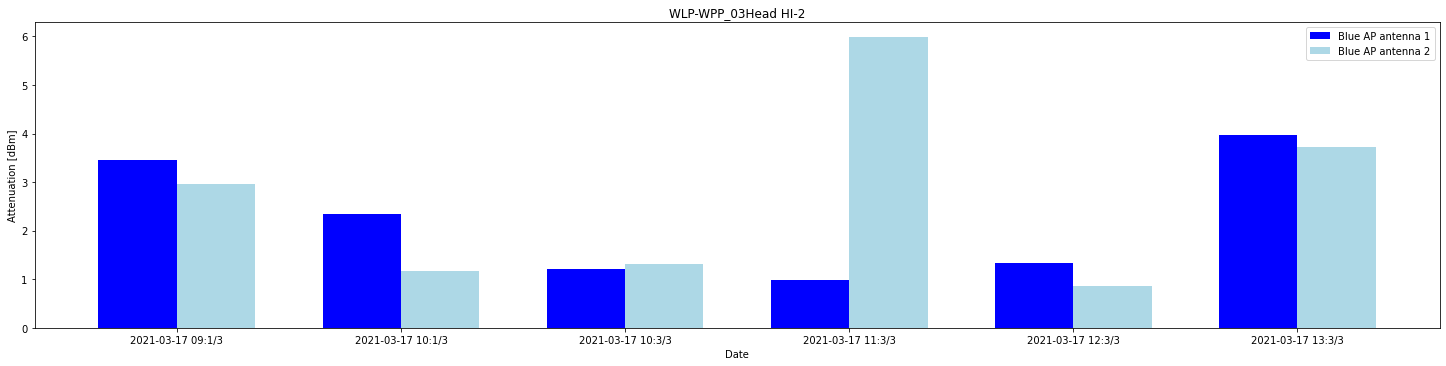

In [184]:
# HI primary    
fig, ax = plt.subplots()
sample_df.index.values
x = np.arange(len(sample_df))  # the label locations
y = [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5]
width = 0.35  # the width of the bars

rects1 = ax.bar(x - width/2, sample_df['primary_dist_ant1'], width , label='Blue AP antenna 1',color='b')
rects2 = ax.bar(x + width/2, sample_df['primary_dist_ant2'], width , label='Blue AP antenna 2',color='lightblue')

ax.set_xticks(x)
ax.set_xticklabels(sample_df['date'])
ax.legend()
plt.title(sample_df['tre_id'].iloc[0] + sample_df['obm_direction'].iloc[0] + ' HI-2')
fig.tight_layout()
plt.xlabel('Date')
plt.ylabel('Attenuation [dBm]')
plt.show()

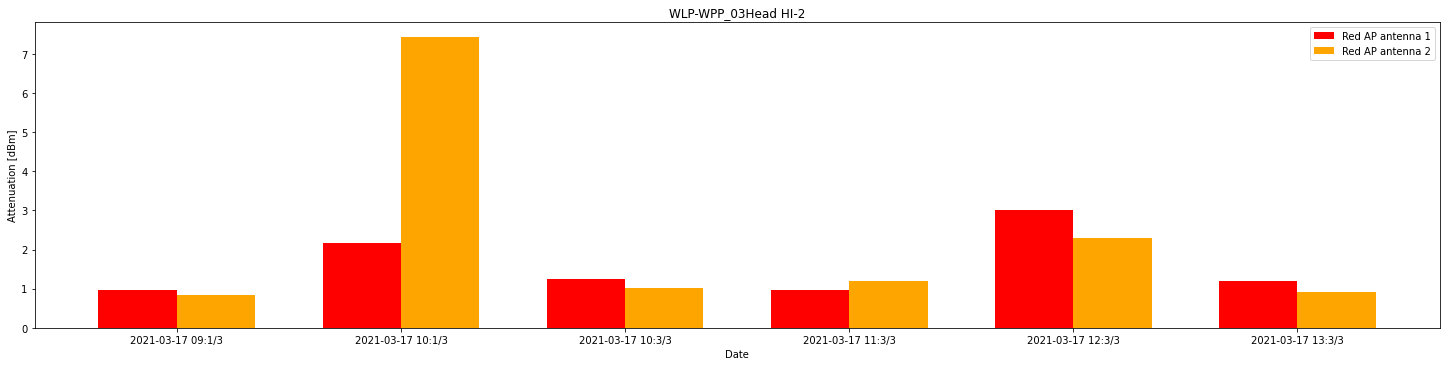

In [185]:
# HI secondary    
fig, ax = plt.subplots()
sample_df.index.values
x = np.arange(len(sample_df))  # the label locations
y = [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5]
width = 0.35  # the width of the bars

rects1 = ax.bar(x - width/2, sample_df['secondary_dist_ant1'], width , label='Red AP antenna 1',color='r')
rects2 = ax.bar(x + width/2, sample_df['secondary_dist_ant2'], width , label='Red AP antenna 2',color='orange')

ax.set_xticks(x)
ax.set_xticklabels(sample_df['date'])
ax.legend()
plt.title(sample_df['tre_id'].iloc[0] + sample_df['obm_direction'].iloc[0] + ' HI-2')
fig.tight_layout()
plt.xlabel('Date')
plt.ylabel('Attenuation [dBm]')
plt.show()

In [186]:
# stats
def stats_diff(row, baseline, primary = True):
    
    tre = row['tre_id']
    direction = row['obm_direction']
    kp_inc = row['kp_inc']
    
    cd = baseline[(baseline['tre_id'] == tre) & (baseline['obm_direction'] == direction) & (baseline['kp_inc'] == kp_inc)].index.values[0]
    
    if primary == True:
        diff = baseline['fpca_baseline'][cd] - row['primary_fpca_predict']
    else:
        diff = baseline['fpca_baseline'][cd] - row['secondary_fpca_predict']
    
    mean_diff = np.mean(diff)
    var_diff = np.var(diff)
    median_diff = np.median(diff)
    
    return mean_diff,var_diff,median_diff

In [187]:
# get stats for primary curves
a,b,c=zip(*sim_df.apply(lambda x : stats_diff(x,tre_baseline_df), axis=1))
sim_df['primary_mean_diff'] = list(a)
sim_df['primary_var_diff'] = list(b)
sim_df['primary_median_diff'] = list(c)

In [188]:
# get stats for secondar curves
a,b,c=zip(*sim_df.apply(lambda x : stats_diff(x,tre_baseline_df,primary = False), axis=1))
sim_df['secondary_mean_diff'] = list(a)
sim_df['secondary_var_diff'] = list(b)
sim_df['secondary_median_diff'] = list(c)

In [189]:
# get stats at antenna level
def stats_diff_antenna1(row, baseline, primary = True):
    
    tre = row['tre_id']
    direction = row['obm_direction']
    kp_inc = row['kp_inc']
    
    cd = baseline[(baseline['tre_id'] == tre) & (baseline['obm_direction'] == direction) & (baseline['kp_inc'] == kp_inc)].index.values[0]
    
    if primary == True:
        diff_ant1 = baseline['fpca_baseline_ant1'][cd] - row['primary_fpca_predict_ant1']
    else:
        diff_ant1 = baseline['fpca_baseline_ant1'][cd] - row['secondary_fpca_predict_ant1']
    
    mean_diff = np.mean(diff_ant1)
    var_diff = np.var(diff_ant1)
    median_diff = np.median(diff_ant1)
    
    return mean_diff,var_diff,median_diff

In [190]:
# get stats for primary antenna 1
a,b,c=zip(*sim_df.apply(lambda x : stats_diff_antenna1(x,tre_baseline_df), axis=1))
sim_df['primary_mean_diff_ant1'] = list(a)
sim_df['primary_var_diff_ant1'] = list(b)
sim_df['primary_median_diff_ant1'] = list(c)

In [191]:
# get stats for primary antenna 2
a,b,c=zip(*sim_df.apply(lambda x : stats_diff_antenna1(x,tre_baseline_df,primary = False), axis=1))
sim_df['secondary_mean_diff_ant1'] = list(a)
sim_df['secondary_var_diff_ant1'] = list(b)
sim_df['secondary_median_diff_ant1'] = list(c)

In [192]:
# stats for antenna 2
def stats_diff_antenna2(row, baseline, primary = True):
    
    tre = row['tre_id']
    direction = row['obm_direction']
    kp_inc = row['kp_inc']
    
    cd = baseline[(baseline['tre_id'] == tre) & (baseline['obm_direction'] == direction) & (baseline['kp_inc'] == kp_inc)].index.values[0]
    
    if primary == True:
        diff_ant2 = baseline['fpca_baseline_ant2'][cd] - row['primary_fpca_predict_ant2']
    else:
        diff_ant2 = baseline['fpca_baseline_ant2'][cd] - row['secondary_fpca_predict_ant2']
    
    mean_diff = np.mean(diff_ant2)
    var_diff = np.var(diff_ant2)
    median_diff = np.median(diff_ant2)
    
    return mean_diff,var_diff,median_diff

In [193]:
# get stats for primary antenna 2
a,b,c=zip(*sim_df.apply(lambda x : stats_diff_antenna2(x,tre_baseline_df), axis=1))
sim_df['primary_mean_diff_ant2'] = list(a)
sim_df['primary_var_diff_ant2'] = list(b)
sim_df['primary_median_diff_ant2'] = list(c)

In [194]:
# get stats for secondary antenna 2
a,b,c=zip(*sim_df.apply(lambda x : stats_diff_antenna2(x,tre_baseline_df,primary = False), axis=1))
sim_df['secondary_mean_diff_ant2'] = list(a)
sim_df['secondary_var_diff_ant2'] = list(b)
sim_df['secondary_median_diff_ant2'] = list(c)

In [195]:
# get the datatset where HI values are greater than a particular threshold
hi = 3
ml_df = sim_df[(sim_df['primary_dist'] > hi) | (sim_df['secondary_dist'] > hi) | (sim_df['primary_dist_ant1'] > hi) | (sim_df['secondary_dist_ant1'] > hi) | (sim_df['primary_dist_ant2'] > hi) | (sim_df['secondary_dist_ant2'] > hi)].reset_index(drop = True)
ml_df

,primary_mac_address,train_id,obm_direction,date,primary_rssi_dbm,primary_kp,secondary_mac_address,secondary_rssi_dbm,secondary_kp,secondary_connection,...,primary_median_diff_ant1,secondary_mean_diff_ant1,secondary_var_diff_ant1,secondary_median_diff_ant1,primary_mean_diff_ant2,primary_var_diff_ant2,primary_median_diff_ant2,secondary_mean_diff_ant2,secondary_var_diff_ant2,secondary_median_diff_ant2
0,00:14:5a:02:31:2d,121,Tail,2021-03-17 09:1/3,"[-57.32015151515193, -57.04339061075904, -56.9...","[205673.66666666663, 205699.85714285716, 20572...",00:14:5a:03:08:6c,"[-51.21545454545484, -50.97338637512948, -50.7...","[205673.66666666663, 205699.85714285716, 20572...",False,...,NaN,NaN,NaN,NaN,17.051787,131.531037,16.516548,31.755792,1045.475761,29.414383
1,00:14:5a:02:31:2d,121,Tail,2021-03-17 10:1/3,"[-60.46888888888953, -60.03178064057738, -59.7...","[205673.66666666663, 205699.85714285716, 20572...",00:14:5a:03:08:6c,"[-49.66333333333407, -49.16617500983282, -48.8...","[205673.66666666663, 205699.85714285716, 20572...",False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,00:14:5a:02:31:2d,121,Tail,2021-03-17 11:1/3,"[-56.76333333333383, -56.42943571128556, -56.2...","[205673.66666666663, 205699.85714285716, 20572...",00:14:5a:03:08:6c,"[-54.12716089880832, -53.90256525394773, -53.8...","[205673.66666666663, 205699.85714285716, 20572...",False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,00:14:5a:02:31:2d,121,Tail,2021-03-17 12:3/3,"[-57.18500000000144, -56.210152189812725, -55....","[205673.66666666663, 205699.85714285716, 20572...",00:14:5a:03:08:6c,"[-50.740000000000556, -50.34092516721068, -50....","[205673.66666666663, 205699.85714285716, 20572...",False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.178618,190.115529,10.546854
4,00:14:5a:02:31:2d,121,Tail,2021-03-17 16:2/3,"[-57.40233333333415, -56.92928785567098, -56.5...","[205673.66666666663, 205699.85714285716, 20572...",00:14:5a:03:08:6c,"[-50.151666666666394, -50.40235312436618, -50....","[205673.66666666663, 205699.85714285716, 20572...",False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
536,00:14:5a:02:3f:c7,121,Head,2021-03-17 14:2/3,"[-58.0090333333333, -57.99379340119862, -57.96...","[864431.0638297872, 864384.2765957447, 864353....",00:14:5a:02:3f:96,"[-55.42613333333328, -55.38881945067765, -55.3...","[864431.0638297872, 864384.2765957447, 864353....",False,...,NaN,NaN,NaN,NaN,3.664529,0.292388,3.672804,0.375277,0.629206,0.341032
537,00:14:5a:02:3f:c7,121,Head,2021-03-17 16:1/3,"[-54.06, -54.98945011099778, -55.2498162697290...","[864431.0638297872, 864384.2765957447, 864353....",00:14:5a:02:3f:96,"[-54.32, -53.244467560648786, -53.178155964067...","[864431.0638297872, 864384.2765957447, 864353....",False,...,NaN,NaN,NaN,NaN,3.750038,0.600278,3.925470,1.133299,0.480982,1.257830
538,00:14:5a:03:05:aa,121,Head,2021-03-17 14:1/3,"[-39.191008820286285, -38.91908710850036, -38....","[982510.7, 982484.5, 982458.3, 982432.1, 98240...",00:14:5a:03:06:0a,"[-45.24452039691186, -44.943652001271, -44.759...","[982510.7, 982484.5, 982458.3, 982432.1, 98240...",False,...,-1.521614,4.142817,0.382773,4.309859,-1.709912,2.564178,-1.029043,4.441719,0.760464,4.490789
539,00:14:5a:03:05:aa,121,Tail,2021-03-17 10:2/3,"[-94.92298295447993, -94.7348399986705, -94.61...","[978880.78125, 978915.9375, 978951.09375, 9789...",00:14:5a:03:06:0a,"[-493.16807528572394, -491.24440781771074, -48...","[978880.78125, 978915.9375, 978951.09375, 9789...",False,...,NaN,NaN,NaN,NaN,11.605304,74.057574,9.833259,8.702949,67.421701,6.571084


In [196]:
ml_df.columns

Index(['primary_mac_address', 'train_id', 'obm_direction', 'date',
       'primary_rssi_dbm', 'primary_kp', 'secondary_mac_address',
       'secondary_rssi_dbm', 'secondary_kp', 'secondary_connection',
       'ap_mac_address', 'tre_ap_name', 'tre_id', 'ap_physical_name',
       'ap_name_geo', 'ap_color', 'ap_kp_in_track', 'kp_inc',
       'type_degradation', 'degraded_ap', 'attenuation', 'degraded_antenna',
       'tilt_degree', 'kp', 'primary_rssi', 'secondary_rssi',
       'primary_kp_peak', 'secondary_kp_peak', 'primary_rssi_dbm_ant1',
       'primary_rssi_dbm_ant2', 'secondary_rssi_dbm_ant1',
       'secondary_rssi_dbm_ant2', 'primary_kp_ant1', 'primary_kp_ant2',
       'secondary_kp_ant1', 'secondary_kp_ant2', 'kp_ant1',
       'primary_rssi_ant1', 'secondary_rssi_ant1', 'kp_ant2',
       'primary_rssi_ant2', 'secondary_rssi_ant2', 'primary_fdata',
       'secondary_fdata', 'primary_fpca', 'secondary_fpca',
       'primary_fpca_predict', 'secondary_fpca_predict', 'primary_fdata_an

In [197]:
ml_df[['distance_primary_secondary', 'primary_dist', 'secondary_dist',
       'primary_dist_ant1', 'secondary_dist_ant1', 'primary_dist_ant2',
       'secondary_dist_ant2', 'primary_mean_diff', 'primary_var_diff',
       'primary_median_diff', 'secondary_mean_diff', 'secondary_var_diff',
       'secondary_median_diff', 'primary_mean_diff_ant1',
       'primary_var_diff_ant1', 'primary_median_diff_ant1',
       'secondary_mean_diff_ant1', 'secondary_var_diff_ant1',
       'secondary_median_diff_ant1', 'primary_mean_diff_ant2',
       'primary_var_diff_ant2', 'primary_median_diff_ant2',
       'secondary_mean_diff_ant2', 'secondary_var_diff_ant2',
       'secondary_median_diff_ant2','type_degradation', 'degraded_ap', 'attenuation', 'degraded_antenna',
       'tilt_degree']]

,distance_primary_secondary,primary_dist,secondary_dist,primary_dist_ant1,secondary_dist_ant1,primary_dist_ant2,secondary_dist_ant2,primary_mean_diff,primary_var_diff,primary_median_diff,...,primary_var_diff_ant2,primary_median_diff_ant2,secondary_mean_diff_ant2,secondary_var_diff_ant2,secondary_median_diff_ant2,type_degradation,degraded_ap,attenuation,degraded_antenna,tilt_degree
0,127.933629,23.529047,47.788016,NaN,NaN,20.549805,45.320041,19.290615,181.488219,18.291050,...,131.531037,16.516548,31.755792,1045.475761,29.414383,single sided attenuation,secondary,4.0,1.0,NaN
1,462.966760,27.997674,127.408400,NaN,NaN,NaN,NaN,-16.985561,495.360430,-14.648704,...,NaN,NaN,NaN,NaN,NaN,constant attenuation,primary,4.0,NaN,NaN
2,961.005316,150.088563,356.768827,NaN,NaN,NaN,NaN,-111.734003,10042.089433,-104.679585,...,NaN,NaN,NaN,NaN,NaN,antenna tilt,secondary,NaN,2.0,20.0
3,310.448090,44.644288,20.657219,NaN,NaN,NaN,NaN,-31.644845,991.716249,-29.190156,...,NaN,NaN,11.178618,190.115529,10.546854,antenna tilt,primary,NaN,1.0,15.0
4,493.114457,73.027818,179.459596,NaN,NaN,NaN,NaN,-52.929198,2531.562215,-49.151139,...,NaN,NaN,NaN,NaN,NaN,antenna tilt,primary,NaN,1.0,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
536,21.432838,3.765244,1.042979,NaN,NaN,3.704208,0.877518,3.725346,0.298862,3.667472,...,0.292388,3.672804,0.375277,0.629206,0.341032,constant attenuation,primary,4.0,NaN,NaN
537,19.207778,3.724948,1.273961,NaN,NaN,3.829238,1.328664,3.626702,0.722268,3.779111,...,0.600278,3.925470,1.133299,0.480982,1.257830,constant attenuation,primary,4.0,NaN,NaN
538,31.521551,2.230929,4.557325,1.813971,4.18876,2.342643,4.526514,-1.666551,2.199650,-1.123342,...,2.564178,-1.029043,4.441719,0.760464,4.490789,constant attenuation,secondary,5.0,NaN,NaN
539,1001.679431,37.624903,231.310968,NaN,NaN,14.447860,11.965075,29.249884,560.077618,25.170575,...,74.057574,9.833259,8.702949,67.421701,6.571084,constant attenuation,primary,4.0,NaN,NaN


## ML

In [198]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import cross_val_score  
import seaborn as sns

In [199]:
#function for plotting graphs
def data_plot(data,col):
    countplt=sns.countplot(x=col, data=data, palette ='hls')
    plt.show()

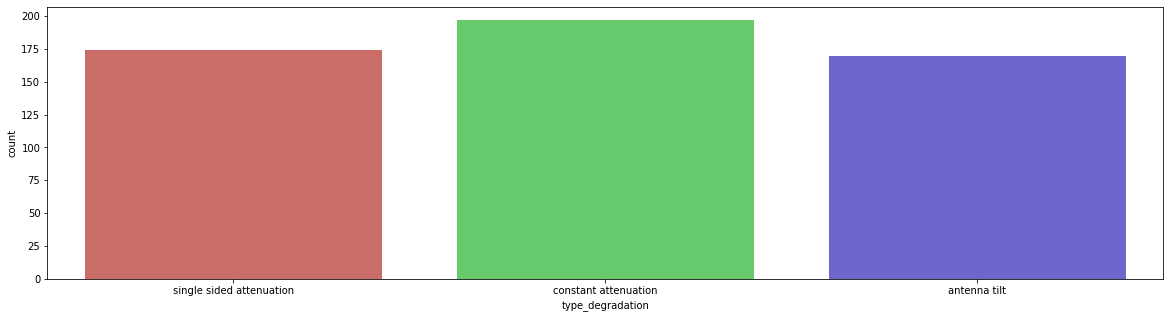

constant attenuation        197
single sided attenuation    174
antenna tilt                170
Name: type_degradation, dtype: int64

In [200]:
#plotting label
data_plot(ml_df,"type_degradation")
ml_df["type_degradation"].value_counts()

In [201]:
decision_tree = DecisionTreeClassifier()
xgboost = XGBClassifier(eval_metric = 'mlogloss',n_estimators=150)

In [202]:
models = {
#     "decision tree" : decision_tree, 
    "xgboost" : xgboost
}

In [203]:
# features
selected_features = ['distance_primary_secondary', 'primary_dist', 'secondary_dist',
       'primary_dist_ant1', 'secondary_dist_ant1', 'primary_dist_ant2',
       'secondary_dist_ant2', 'primary_mean_diff', 'primary_var_diff', 'secondary_mean_diff', 'secondary_var_diff', 'primary_mean_diff_ant1',
       'primary_var_diff_ant1','secondary_mean_diff_ant1', 'secondary_var_diff_ant1', 'primary_mean_diff_ant2',
       'primary_var_diff_ant2','secondary_mean_diff_ant2', 'secondary_var_diff_ant2']

In [204]:
# target variable
target = 'type_degradation'

In [205]:
# split data
X_train,X_test,y_train,y_test = train_test_split(ml_df[selected_features],ml_df[target], test_size=0.30, random_state = 1)

In [206]:
#power transformer for transforming variables
pt = PowerTransformer()

In [207]:
# transform features
pt.fit(X_train)
transformed_features = pt.transform(X_train)
X_train = pd.DataFrame(transformed_features, columns = [selected_features])

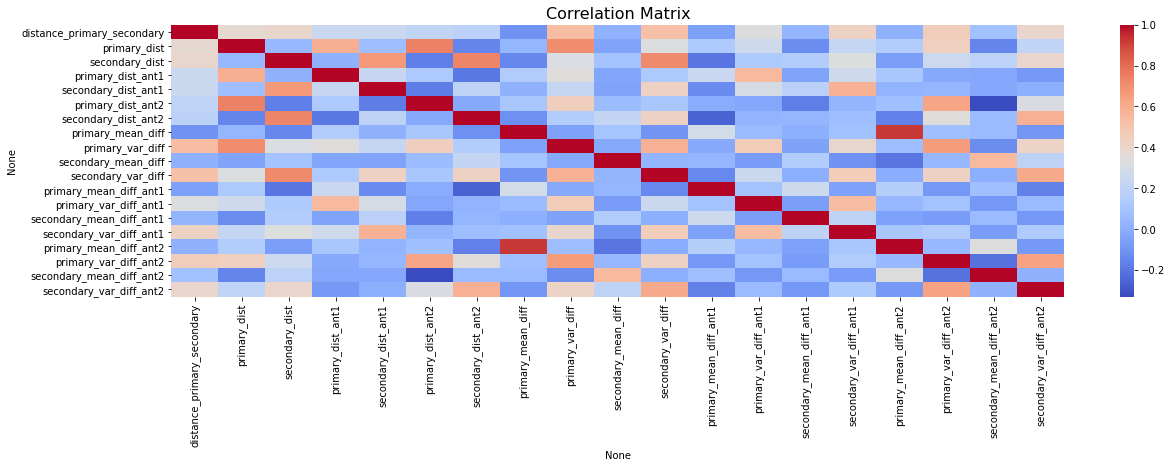

In [208]:
# correlation matrix
correlaton = X_train.corr()
sns.heatmap(correlaton, cbar=True, cmap="coolwarm")
plt.title("Correlation Matrix", fontsize=16)
plt.show()

In [209]:
#fitting the models
for model in models:
    models[model].fit(X_train,y_train)
    print(f"{model} has been trained successfully")

xgboost has been trained successfully


In [210]:
# store training performance
performances_training = {}

for model in models:
    predictions   = models[model].predict(X_train)
    probabilities = pd.DataFrame(models[model].predict_proba(X_train))[1]
    accuracy      = accuracy_score(y_train,predictions)
#     auc           = roc_auc_score(np.array(y_train),np.array(probabilities),multi_class = 'ovr')
    
    performances_training[model] = {"Accuracy":accuracy}

In [211]:
#cross validation

In [212]:
def cv_fit(alg, train, target, predictors, perform_cv=True, print_feature_importance=True, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(train, target)
        
    #Predict training set:
    train_predictions = alg.predict(train)
    train_predprob = alg.predict_proba(train)[:,1]
    
    #Perform cross-validation:
    if perform_cv:
        cv_score = cross_val_score(alg, train, target, cv=cv_folds, scoring='accuracy')
    
    #Print model report:
    
    print ("\nModel Report: ",alg)
#     print ("Accuracy : %.4g" % accuracy_score(target.values, train_predictions))
#     print ("AUC (Train): %f" % roc_auc_score(target, train_predprob))
    
    if perform_cv:
        print ("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        print("\n-----------------------------------********************-----------------------------------\n")
    #Print Feature Importance:
    if print_feature_importance:
        feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')

In [213]:
for model in models:
    cv_fit(models[model],X_train,y_train,selected_features,print_feature_importance=False)


Model Report:  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='mlogloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=150, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
CV Score : Mean - 0.5794035 | Std - 0.03614761 | Min - 0.5131579 | Max - 0.6184211

-----------------------------------********************-----------------------------------



Test

In [214]:
# transform features
pt.fit(X_test)
transformed_features_test = pt.transform(X_test)
X_test = pd.DataFrame(transformed_features_test, columns = [selected_features])

In [215]:
# store testing performance
performances_test = {}

for model in models:
    predictions   = models[model].predict(X_test)
    probabilities = pd.DataFrame(models[model].predict_proba(X_test))[1]
    accuracy      = accuracy_score(y_test,predictions)
    
    performances_test[model] = {"Accuracy":accuracy}

In [216]:
pd.DataFrame(performances_test)

,xgboost
Accuracy,0.515337


In [217]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

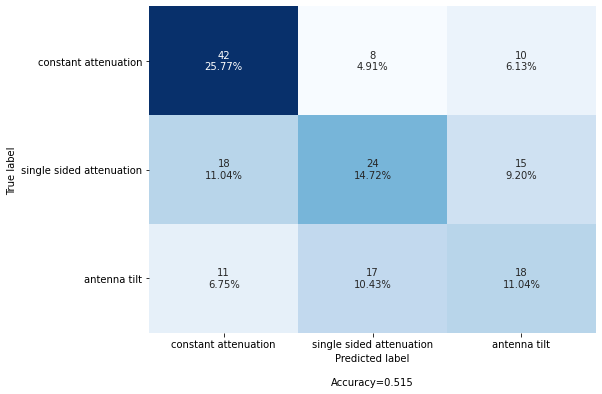

In [218]:
labels = ['constant attenuation','single sided attenuation','antenna tilt']
cm = confusion_matrix(y_test, predictions, labels = labels)
make_confusion_matrix(cm, figsize=(8,6),categories=labels, cbar=False)

In [ ]:
# Testing on the real dataset

In [219]:
ad_test

,primary_mac_address,train_id,obm_direction,date,primary_rssi_dbm,primary_kp,secondary_mac_address,secondary_rssi_dbm,secondary_kp,secondary_connection,...,secondary_fpca_predict_ant2,primary_fpca_r2,secondary_fpca_r2,distance_primary_secondary,primary_dist,secondary_dist,primary_dist_ant1,secondary_dist_ant1,primary_dist_ant2,secondary_dist_ant2
0,00:14:5a:02:31:5e,121,Head,2021-03-16 14:2/3,"[-61.819117647058775, -62.276818414514075, -62...","[204725.5, 204683.0, 204640.5, 204598.0, 20455...",00:14:5a:02:36:4a,"[-54.60955882352815, -54.901509813920846, -55....","[204725.5, 204683.0, 204640.5, 204598.0, 20455...",False,...,"[[-66.0462757253233], [-65.48514189044441], [-...",0.886934,0.889158,32.783139,1.559212,0.928426,0.991044,1.037889,3.046973,0.647012
1,00:14:5a:02:31:5e,121,Head,2021-03-16 15:2/3,"[-64.5749999999994, -63.7193628127435, -63.149...","[204725.5, 204683.0, 204640.5, 204598.0, 20455...",00:14:5a:02:36:4a,"[-60.175000000000395, -60.459395412092036, -60...","[204725.5, 204683.0, 204640.5, 204598.0, 20455...",False,...,"[[-70.1460780408333], [-69.73732017661573], [-...",0.863111,0.895390,33.271957,1.351302,1.672559,1.442330,1.719846,1.052322,1.624399
2,00:14:5a:02:31:5e,121,Head,2021-03-16 16:1/3,"[-63.15158883820728, -62.87594497038704, -62.6...","[204725.5, 204683.0, 204640.5, 204598.0, 20455...",00:14:5a:02:36:4a,"[-59.34425358128221, -59.78251110569149, -59.8...","[204725.5, 204683.0, 204640.5, 204598.0, 20455...",False,...,"[[-63.73762887918253], [-63.795805176265624], ...",0.833612,0.873351,32.897822,1.578970,2.104072,1.724994,2.338575,1.205236,1.240785
3,00:14:5a:02:31:5e,121,Head,2021-03-16 17:1/3,"[-62.78319826691327, -63.23936264863512, -63.4...","[204725.5, 204683.0, 204640.5, 204598.0, 20455...",00:14:5a:02:36:4a,"[-57.322033154641595, -57.26427195688088, -57....","[204725.5, 204683.0, 204640.5, 204598.0, 20455...",False,...,"[[-66.30790507518307], [-65.97003626106603], [...",0.870920,0.890498,36.591307,1.031476,0.945006,1.117939,1.042537,0.879448,0.596861


In [220]:
a,b,c=zip(*ad_test.apply(lambda x : stats_diff(x,tre_baseline_df), axis=1))
ad_test['primary_mean_diff'] = list(a)
ad_test['primary_var_diff'] = list(b)
ad_test['primary_median_diff'] = list(c)

In [221]:
a,b,c=zip(*ad_test.apply(lambda x : stats_diff(x,tre_baseline_df,primary = False), axis=1))
ad_test['secondary_mean_diff'] = list(a)
ad_test['secondary_var_diff'] = list(b)
ad_test['secondary_median_diff'] = list(c)

In [222]:
a,b,c=zip(*ad_test.apply(lambda x : stats_diff_antenna1(x,tre_baseline_df), axis=1))
ad_test['primary_mean_diff_ant1'] = list(a)
ad_test['primary_var_diff_ant1'] = list(b)
ad_test['primary_median_diff_ant1'] = list(c)

In [223]:
a,b,c=zip(*ad_test.apply(lambda x : stats_diff_antenna1(x,tre_baseline_df,primary = False), axis=1))
ad_test['secondary_mean_diff_ant1'] = list(a)
ad_test['secondary_var_diff_ant1'] = list(b)
ad_test['secondary_median_diff_ant1'] = list(c)

In [224]:
a,b,c=zip(*ad_test.apply(lambda x : stats_diff_antenna2(x,tre_baseline_df), axis=1))
ad_test['primary_mean_diff_ant2'] = list(a)
ad_test['primary_var_diff_ant2'] = list(b)
ad_test['primary_median_diff_ant2'] = list(c)

In [225]:
a,b,c=zip(*ad_test.apply(lambda x : stats_diff_antenna2(x,tre_baseline_df,primary = False), axis=1))
ad_test['secondary_mean_diff_ant2'] = list(a)
ad_test['secondary_var_diff_ant2'] = list(b)
ad_test['secondary_median_diff_ant2'] = list(c)

In [226]:
input_test = np.array(ad_test[selected_features].iloc[0]).reshape(1, -1)
target_test = ad_test[target].iloc[0]

In [227]:
# input data
input_test

array([[32.78313934,  1.55921194,  0.92842625,  0.99104417,  1.03788868,
         3.04697279,  0.64701163,  0.28129813,  2.35201323, -0.23488709,
         0.80680335, -0.25391613,  0.91769515, -0.25823908,  1.01052549,
         2.54992995,  2.78190043, -0.13694889,  0.39986906]])

In [228]:
# target variable
target_test

'antenna tilt'

In [229]:
# transform features
pt.fit(input_test)
transformed_features = pt.transform(input_test)
input_test = pd.DataFrame(transformed_features, columns = [selected_features])

In [230]:
# predict the type of degradation
prediction = models['xgboost'].predict(input_test)
prediction

array(['single sided attenuation'], dtype=object)

In [ ]:
################################### IGNORE #########################################

In [652]:
# create new columns to save type of degradation and level of attenuation
br_df_test['type_degradation'] = np.nan
br_df_test['degraded_ap'] = np.nan
br_df_test['attenuation'] = np.nan
br_df_test['degraded_antenna'] = np.nan
br_df_test['tilt_degree'] = np.nan

In [653]:
# degradations to 5 random TREs
for i in [0,1,4,10,21]:
    degradation = np.random.choice(['constant attenuation','antenna tilt','single sided attenuation'])
    ap = np.random.choice(['primary','secondary'])
    
    
    br_df_test['type_degradation'].iloc[i] = degradation
    br_df_test['degraded_ap'].iloc[i] = ap
    
    if degradation == 'constant attenuation':
        
#         print('adding constant attenuation')
        
        attenuation = np.random.choice([2,3,4,5])
        br_df_test['attenuation'].iloc[i] = attenuation
        
        degraded_rssi = constant_attenuation(br_df_test.iloc[i].copy(), attenuation, access_point = ap, antenna = ant)
        
    elif degradation == 'antenna tilt':
        
#         print('adding antenna tilt')

        tilt = np.random.choice([10,15,20,25,30])
        ant = np.random.choice([1,2])
        
#         if type(sim_df[ap+'_rssi_dbm_ant'+str(ant)].iloc[i]) in [float,np.float64]:
#             ant = list(set([1,2]) - set([ant]))[0]
            
        br_df_test['tilt_degree'].iloc[i] = tilt
        br_df_test['degraded_antenna'].iloc[i] = ant
        
        degraded_rssi = antenna_tilt_change(br_df_test.iloc[i].copy(),tilt_degree = tilt, access_point = ap, antenna = ant)
    
    else:
        attenuation = np.random.choice([2,3,4,5])
        ant = np.random.choice([1,2])
        
#         if type(sim_df[ap+'_rssi_dbm_ant'+str(ant)].iloc[i]) in [float,np.float64]:
#             ant = list(set([1,2]) - set([ant]))[0]
            
        br_df_test['attenuation'].iloc[i] = attenuation
        br_df_test['degraded_antenna'].iloc[i] = ant
    
        degraded_rssi = constant_attenuation(br_df_test.iloc[i].copy(), attenuation, access_point = ap, single_side = True, antenna = ant)

    if ap == 'primary':
        br_df_test['primary_rssi_dbm'].iloc[i] = degraded_rssi
    else:
        br_df_test['secondary_rssi_dbm'].iloc[i] = degraded_rssi
        

In [654]:
br_df_test

,primary_mac_address,train_id,obm_direction,date,primary_rssi_dbm,primary_kp,secondary_mac_address,secondary_rssi_dbm,secondary_kp,secondary_connection,...,ap_physical_name,ap_name_geo,ap_color,ap_kp_in_track,kp_inc,type_degradation,degraded_ap,attenuation,degraded_antenna,tilt_degree
0,00:14:5a:03:05:aa,121,Tail,2021-03-16 15:3/3,"[-39.0, -39.15, -39.1275, -38.958375000000004,...","[978880.78125, 978915.9375, 978951.09375, 9789...",00:14:5a:03:06:0a,"[-43.21106640591492, -42.729406445027685, -42....","[978892.5, 978927.65625, 978962.8125, 978997.9...",False,...,KEN-GPP_02_RAP_BLUE,GPP_02_BLUE,BLUE,977800.0,True,single sided attenuation,primary,4.0,2.0,NaN
1,00:14:5a:03:05:ac,121,Tail,2021-03-16 13:1/3,"[-66.0, -65.85, -66.02250000000001, -66.169125...","[535040.1395348837, 535088.976744186, 535162.2...",00:14:5a:03:08:6e,"[-66.0, -66.45, -66.6825, -66.730125, -66.0206...","[535064.5581395349, 535113.3953488372, 535186....",False,...,SLW-MDW_05_RAP_BLUE,MDW_05_BLUE,BLUE,504500.0,True,single sided attenuation,secondary,3.0,1.0,NaN
2,00:14:5a:03:05:d1,121,Tail,2021-03-16 11:1/3,"[-47.0, -47.150000000000006, -46.9775000000000...","[550554.7142857143, 550600.380952381, 550652.5...",00:14:5a:02:3d:48,"[-47.0, -46.85000000000001, -47.17250000000001...","[550574.2857142857, 550626.4761904762, 550678....",False,...,SLW-MDW_08_RAP_BLUE,MDW_08_BLUE,BLUE,533500.0,True,NaN,NaN,NaN,NaN,NaN
3,00:14:5a:03:05:d1,121,Tail,2021-03-16 13:1/3,"[-52.0, -51.85, -51.7225, -51.464124999999996,...","[550095.281553398, 550177.5339805825, 550218.6...",00:14:5a:02:3d:48,"[-54.0, -53.85, -53.4225, -53.209125, -52.5777...","[550136.4077669902, 550208.3786407767, 550228....",False,...,SLW-MDW_08_RAP_BLUE,MDW_08_BLUE,BLUE,533500.0,True,NaN,NaN,NaN,NaN,NaN
4,00:14:5a:03:05:d1,121,Tail,2021-03-16 14:3/3,"[-63.0, -62.85, -62.8725, -62.891625000000005,...","[536159.2727272727, 536213.8181818182, 536254....",00:14:5a:02:3d:48,"[-58.0, -57.550000000000004, -56.8675000000000...","[536172.9090909091, 536227.4545454546, 536268....",False,...,SLW-MDW_08_RAP_BLUE,MDW_08_BLUE,BLUE,533500.0,True,constant attenuation,primary,5.0,NaN,NaN
5,00:14:5a:03:06:06,121,Head,2021-03-16 09:3/3,"[-58.0, -58.300000000000004, -57.9550000000000...","[687884.0, 687848.0, 687824.0, 687812.0, 68776...",00:14:5a:02:3e:e7,"[-55.0, -54.85, -54.8725, -54.741625000000006,...","[687860.0, 687836.0, 687800.0, 687778.0, 68774...",False,...,MDW-DVD_05_RAP_BLUE,DVD_05_BLUE,BLUE,678200.0,False,NaN,NaN,NaN,NaN,NaN
6,00:14:5a:03:06:06,121,Head,2021-03-16 11:3/3,"[-58.0, -58.0, -58.0, -57.85, -57.4225, -57.20...","[688961.2558139535, 688928.6976744186, 688896....",00:14:5a:02:3e:e7,"[-54.0, -53.7, -53.44500000000001, -53.2282500...","[688944.976744186, 688912.4186046511, 688879.8...",False,...,MDW-DVD_05_RAP_BLUE,DVD_05_BLUE,BLUE,678200.0,False,NaN,NaN,NaN,NaN,NaN
7,00:14:5a:03:06:06,121,Head,2021-03-16 13:2/3,"[-55.0, -54.85, -54.572500000000005, -54.18662...","[687065.0833333334, 687030.7083333334, 687007....",00:14:5a:02:3e:e7,"[-58.0, -58.0, -58.0, -57.85, -57.8725, -57.59...","[687019.25, 686996.3333333334, 686961.95833333...",False,...,MDW-DVD_05_RAP_BLUE,DVD_05_BLUE,BLUE,678200.0,False,NaN,NaN,NaN,NaN,NaN
8,00:14:5a:03:06:06,121,Head,2021-03-16 15:1/3,"[-54.0, -54.6, -55.11000000000001, -55.5435000...","[689003.0, 688975.5, 688948.0, 688920.5, 68889...",00:14:5a:02:3e:e7,"[-52.0, -52.45, -52.9825, -53.135125, -53.1148...","[688989.25, 688961.75, 688934.25, 688906.75, 6...",False,...,MDW-DVD_05_RAP_BLUE,DVD_05_BLUE,BLUE,678200.0,False,NaN,NaN,NaN,NaN,NaN
9,00:14:5a:03:06:06,121,Head,2021-03-16 17:1/3,"[-56.0, -55.550000000000004, -55.4675, -55.397...","[688822.1463414634, 688774.5853658536, 688758....",00:14:5a:02:3e:e7,"[-53.0, -52.85, -52.722500000000004, -52.46412...","[688806.2926829269, 688790.4390243902, 688742....",False,...,MDW-DVD_05_RAP_BLUE,DVD_05_BLUE,BLUE,678200.0,False,NaN,NaN,NaN,NaN,NaN


In [655]:
# apply function
a,b=zip(*br_df_test.apply(lambda x : interp_primary_rssi(x,kp_df), axis=1))
# assign kp and rssi
br_df_test['primary_kp'] = list(a)
br_df_test['primary_rssi_dbm'] = list(b)

In [656]:
# drop the curves which have RSSI nan 
br_df_test = br_df_test[br_df_test['primary_rssi_dbm'].notna()].reset_index(drop = True)

In [657]:
# apply function
a,b=zip(*br_df_test.apply(lambda x : interp_secondary_rssi(x), axis=1))
# assign new secondary kp and rssi
br_df_test['secondary_kp'] = list(a)
br_df_test['secondary_rssi_dbm'] = list(b)

In [658]:
# get kalman filtered rssi
a,b=zip(*br_df_test.apply(lambda x : kalman_rssi(x), axis=1))
br_df_test['primary_rssi_dbm'] = list(a)
br_df_test['secondary_rssi_dbm'] = list(b)

In [659]:
a,b,c=zip(*br_df_test.apply(lambda x : flip_kp(x), axis=1))
br_df_test['kp'] = list(a)
br_df_test['primary_rssi'] = list(b)
br_df_test['secondary_rssi'] = list(c)

In [660]:
# add changes to the data
a,b,c,d,e,f=zip(*br_df_test.apply(lambda x : find_peak_rssi_split(x), axis=1))
br_df_test["primary_kp_peak"] = list(a)
br_df_test["secondary_kp_peak"] = list(b)
br_df_test["primary_rssi_dbm_ant1"] = list(c)
br_df_test["primary_rssi_dbm_ant2"] = list(d)
br_df_test["secondary_rssi_dbm_ant1"] = list(e)
br_df_test["secondary_rssi_dbm_ant2"] = list(f)

In [661]:
# apply function
a, b, c, d = zip(*br_df_test.apply(lambda x : split_kp(x), axis=1))
# add changes to the data 
br_df_test["primary_kp_ant1"] = list(a)
br_df_test["primary_kp_ant2"] = list(b)
br_df_test["secondary_kp_ant1"] = list(c)
br_df_test["secondary_kp_ant2"] = list(d)

In [662]:
# interpolate blue antenna level curves    
a, b, c, d = zip(*br_df_test.apply(lambda x : interp_primary_rssi_antenna(x,kp_df), axis=1))
# add changes
br_df_test['primary_kp_ant1'] = list(a)
br_df_test['primary_kp_ant2'] = list(b)
br_df_test['primary_rssi_dbm_ant1'] = list(c)
br_df_test['primary_rssi_dbm_ant2'] = list(d)

In [663]:
# interpolate red antenna level curves
a, b = zip(*br_df_test.apply(lambda x : interp_secondary_rssi_antenna(x), axis=1))
# add changes 
br_df_test['secondary_rssi_dbm_ant1'] = list(a)
br_df_test['secondary_rssi_dbm_ant2'] = list(b)
br_df_test['secondary_kp_ant1'] = br_df_test['primary_kp_ant1']
br_df_test['secondary_kp_ant2'] = br_df_test['primary_kp_ant2']

In [664]:
a,b,c=zip(*br_df_test.apply(lambda x : flip_kp_ant1(x), axis=1))
br_df_test['kp_ant1'] = list(a)
br_df_test['primary_rssi_ant1'] = list(b)
br_df_test['secondary_rssi_ant1'] = list(c)

In [665]:
a,b,c=zip(*br_df_test.apply(lambda x : flip_kp_ant2(x), axis=1))
br_df_test['kp_ant2'] = list(a)
br_df_test['primary_rssi_ant2'] = list(b)
br_df_test['secondary_rssi_ant2'] = list(c)

In [666]:
br_df_test['primary_fdata'] = br_df_test.apply(lambda x : fdata_primary(x), axis=1)
br_df_test['secondary_fdata'] = br_df_test.apply(lambda x : fdata_secondary(x), axis=1)

In [667]:
# functional form
br_df_test['primary_fpca'] = br_df_test.apply(lambda row : FPCA(row["primary_fdata"]),axis=1) 
br_df_test['secondary_fpca'] = br_df_test.apply(lambda row : FPCA(row["secondary_fdata"]),axis=1)  

In [668]:
# fpca reconstruction
br_df_test['primary_fpca_predict'] = br_df_test[br_df_test['primary_fpca'].notnull()].apply(lambda row : row["primary_fpca"].evaluate(row["primary_fdata"].sample_points[0])[0],axis=1)
br_df_test['secondary_fpca_predict'] = br_df_test[br_df_test['secondary_fpca'].notnull()].apply(lambda row : row["secondary_fpca"].evaluate(row["secondary_fdata"].sample_points[0])[0],axis=1)

In [669]:
a,b = zip(*br_df_test.apply(lambda x : fdata_primary_antenna(x), axis=1))
br_df_test['primary_fdata_ant1'] = list(a)
br_df_test['primary_fdata_ant2'] = list(b)

In [670]:
a,b = zip(*br_df_test.apply(lambda x : fdata_secondary_antenna(x), axis=1))
br_df_test['secondary_fdata_ant1'] = list(a)
br_df_test['secondary_fdata_ant2'] = list(b)

In [671]:
br_df_test['primary_fpca_ant1'] = br_df_test.apply(lambda row : FPCA(row["primary_fdata_ant1"]),axis=1) 
br_df_test['secondary_fpca_ant1'] = br_df_test.apply(lambda row : FPCA(row["secondary_fdata_ant1"]),axis=1)  
br_df_test['primary_fpca_ant2'] = br_df_test.apply(lambda row : FPCA(row["primary_fdata_ant2"]),axis=1) 
br_df_test['secondary_fpca_ant2'] = br_df_test.apply(lambda row : FPCA(row["secondary_fdata_ant2"]),axis=1)  

In [672]:
print("FPCA blue antenna 1 generation failures %d%%" % (len(br_df_test[br_df_test['primary_fpca_ant1'].notnull() == False])*100/len(br_df_test)))
print("FPCA red antenna 1 generation failures %d%%" % (len(br_df_test[br_df_test['secondary_fpca_ant1'].notnull() == False])*100/len(br_df_test)))
print("FPCA blue antenna 2 generation failures %d%%" % (len(br_df_test[br_df_test['primary_fpca_ant2'].notnull() == False])*100/len(br_df_test)))
print("FPCA red antenna 2 generation failures %d%%" % (len(br_df_test[br_df_test['secondary_fpca_ant2'].notnull() == False])*100/len(br_df_test)))

FPCA blue antenna 1 generation failures 40%
FPCA red antenna 1 generation failures 40%
FPCA blue antenna 2 generation failures 0%
FPCA red antenna 2 generation failures 0%


In [673]:
# predict primary for both antennas
br_df_test['primary_fpca_predict_ant1'] = br_df_test[br_df_test['primary_fpca_ant1'].notnull()].apply(lambda row : row["primary_fpca_ant1"].evaluate(row["primary_fdata_ant1"].sample_points[0])[0],axis=1)
br_df_test['primary_fpca_predict_ant2'] = br_df_test[br_df_test['primary_fpca_ant2'].notnull()].apply(lambda row : row["primary_fpca_ant2"].evaluate(row["primary_fdata_ant2"].sample_points[0])[0],axis=1)

In [674]:
# predict red for both antennas
br_df_test['secondary_fpca_predict_ant1'] = br_df_test[br_df_test['secondary_fpca_ant1'].notnull()].apply(lambda row : row["secondary_fpca_ant1"].evaluate(row["secondary_fdata_ant1"].sample_points[0])[0],axis=1)
br_df_test['secondary_fpca_predict_ant2'] = br_df_test[br_df_test['secondary_fpca_ant2'].notnull()].apply(lambda row : row["secondary_fpca_ant2"].evaluate(row["secondary_fdata_ant2"].sample_points[0])[0],axis=1)

In [675]:
# error
br_df_test['primary_fpca_r2'] = br_df_test[br_df_test['primary_fpca'].notnull()].apply(lambda row : eval_r2(row["primary_fdata"],row["primary_fpca"]),axis=1)
br_df_test['secondary_fpca_r2'] = br_df_test[br_df_test['secondary_fpca'].notnull()].apply(lambda row : eval_r2(row["secondary_fdata"],row["secondary_fpca"]),axis=1)

In [676]:
# RSSI difference and distance computation
br_df_test['distance_primary_secondary'] = br_df_test[br_df_test['primary_fpca_r2'] > 0.5].apply(lambda row : compute_distance_primary_secondary(row),axis=1)

In [677]:
# distance from baseline to blue and red curves
a,b=zip(*br_df_test.apply(lambda x : compute_distance_baseline(x,tre_baseline_df), axis=1))
br_df_test['primary_dist'] = list(a)
br_df_test['secondary_dist'] = list(b)

In [678]:
# distance from antenna 1 baseline to antenna 1 blue and red curves
c,d=zip(*br_df_test.apply(lambda x : compute_distance_baseline_ant1(x,tre_baseline_df), axis=1))
br_df_test['primary_dist_ant1'] = list(c)
br_df_test['secondary_dist_ant1'] = list(d)

In [679]:
# distance from antenna 1 baseline to antenna 1 blue and red curves
e,f=zip(*br_df_test.apply(lambda x : compute_distance_baseline_ant2(x,tre_baseline_df), axis=1))
br_df_test['primary_dist_ant2'] = list(e)
br_df_test['secondary_dist_ant2'] = list(f)

In [680]:
a,b,c=zip(*br_df_test.apply(lambda x : stats_diff(x,tre_baseline_df), axis=1))
br_df_test['primary_mean_diff'] = list(a)
br_df_test['primary_var_diff'] = list(b)
br_df_test['primary_median_diff'] = list(c)

In [681]:
a,b,c=zip(*br_df_test.apply(lambda x : stats_diff(x,tre_baseline_df,primary = False), axis=1))
br_df_test['secondary_mean_diff'] = list(a)
br_df_test['secondary_var_diff'] = list(b)
br_df_test['secondary_median_diff'] = list(c)

In [682]:
a,b,c=zip(*br_df_test.apply(lambda x : stats_diff_antenna1(x,tre_baseline_df), axis=1))
br_df_test['primary_mean_diff_ant1'] = list(a)
br_df_test['primary_var_diff_ant1'] = list(b)
br_df_test['primary_median_diff_ant1'] = list(c)

In [683]:
a,b,c=zip(*br_df_test.apply(lambda x : stats_diff_antenna1(x,tre_baseline_df,primary = False), axis=1))
br_df_test['secondary_mean_diff_ant1'] = list(a)
br_df_test['secondary_var_diff_ant1'] = list(b)
br_df_test['secondary_median_diff_ant1'] = list(c)

In [684]:
a,b,c=zip(*br_df_test.apply(lambda x : stats_diff_antenna2(x,tre_baseline_df), axis=1))
br_df_test['primary_mean_diff_ant2'] = list(a)
br_df_test['primary_var_diff_ant2'] = list(b)
br_df_test['primary_median_diff_ant2'] = list(c)

In [685]:
a,b,c=zip(*br_df_test.apply(lambda x : stats_diff_antenna2(x,tre_baseline_df,primary = False), axis=1))
br_df_test['secondary_mean_diff_ant2'] = list(a)
br_df_test['secondary_var_diff_ant2'] = list(b)
br_df_test['secondary_median_diff_ant2'] = list(c)

In [686]:
hi = 2
# br_df_ml = br_df_test[(br_df_test['primary_dist'] > hi) | (br_df_test['secondary_dist'] > hi) | (br_df_test['primary_dist_ant1'] > hi) | (br_df_test['secondary_dist_ant1'] > hi) | (br_df_test['primary_dist_ant2'] > hi) | (br_df_test['secondary_dist_ant2'] > hi)].reset_index(drop = True)
br_df_test_ml = br_df_test[br_df_test['type_degradation'].notna()].reset_index(drop = True)

In [689]:
br_df_test_ml

,primary_mac_address,train_id,obm_direction,date,primary_rssi_dbm,primary_kp,secondary_mac_address,secondary_rssi_dbm,secondary_kp,secondary_connection,...,primary_median_diff_ant1,secondary_mean_diff_ant1,secondary_var_diff_ant1,secondary_median_diff_ant1,primary_mean_diff_ant2,primary_var_diff_ant2,primary_median_diff_ant2,secondary_mean_diff_ant2,secondary_var_diff_ant2,secondary_median_diff_ant2
0,00:14:5a:03:05:aa,121,Tail,2021-03-16 15:3/3,"[-39.0, -39.14960850782984, -39.13486952717453...","[978880.78125, 978915.9375, 978951.09375, 9789...",00:14:5a:03:06:0a,"[-43.37161972621067, -42.889530874303595, -42....","[978880.78125, 978915.9375, 978951.09375, 9789...",False,...,NaN,NaN,NaN,NaN,10.582374,23.871055,10.626583,7.909005,21.999789,7.879276
1,00:14:5a:03:05:ac,121,Tail,2021-03-16 13:1/3,"[-66.0, -65.84934151316973, -65.96478031199489...","[535040.1395348837, 535088.976744186, 535162.2...",00:14:5a:03:08:6e,"[-65.77499999999947, -66.22433776324421, -66.4...","[535040.1395348837, 535088.976744186, 535162.2...",False,...,3.334697,1.747343,3.738920,1.446584,0.054830,2.118962,0.411221,-2.015867,0.509767,-1.669610
2,00:14:5a:03:05:d1,121,Tail,2021-03-16 14:3/3,"[-60.34567747506015, -59.308355332652745, -58....","[550095.281553398, 550177.5339805825, 550218.6...",00:14:5a:02:3d:48,"[-51.982612506433476, -51.88510259750695, -51....","[550095.281553398, 550177.5339805825, 550218.6...",False,...,NaN,NaN,NaN,NaN,3.982622,2.879908,4.371650,-0.181049,2.627715,-0.502089
3,00:14:5a:03:06:06,121,Tail,2021-03-16 09:2/3,"[-42.071477207493466, -41.805562077325256, -41...","[681075.4912280702, 681088.649122807, 681101.8...",00:14:5a:02:3e:e7,"[-43.28362131327012, -43.21193424294519, -43.2...","[681075.4912280702, 681088.649122807, 681101.8...",False,...,NaN,NaN,NaN,NaN,1.883528,0.787643,1.832908,2.761311,1.239792,2.827471
4,00:14:5a:03:06:1b,121,Head,2021-03-16 15:2/3,"[-55.636569807544696, -54.67265004993205, -54....","[114217.0, 114167.0, 114117.0, 114067.0, 11401...",00:14:5a:02:3a:1a,"[-55.68437248698746, -55.749162009719576, -55....","[114217.0, 114167.0, 114117.0, 114067.0, 11401...",False,...,-0.314240,0.637682,1.530675,0.674123,8.352827,3.339946,8.808589,-0.399009,1.268608,-0.239899


In [687]:
input_data = br_df_test_ml[selected_features]
target = br_df_test_ml[target]

KeyError: "None of [Index(['single sided attenuation', 'single sided attenuation',\n       'constant attenuation', 'single sided attenuation',\n       'constant attenuation'],\n      dtype='object')] are in the [columns]"

In [688]:
pt.fit(input_data)
transformed_features = pt.transform(input_data)
input_data = pd.DataFrame(transformed_features, columns = [selected_features])

In [646]:
# store testing performance
performances_test = {}

for model in models:
    predictions   = models[model].predict(input_data)
    probabilities = pd.DataFrame(models[model].predict_proba(input_data))[1]
    accuracy      = accuracy_score(target,predictions)
    
    performances_test[model] = {"Accuracy":accuracy}

In [647]:
performances_test

{'xgboost': {'Accuracy': 0.4}}

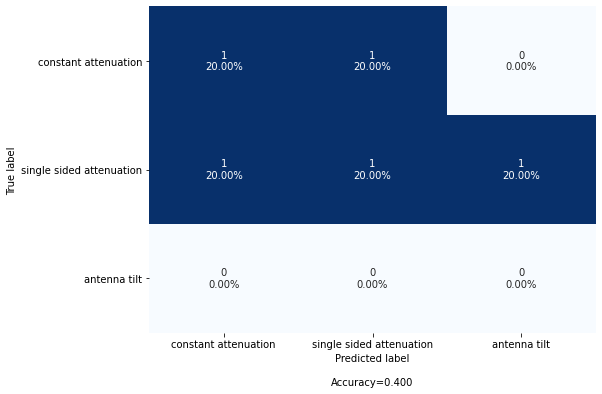

In [648]:
labels = ['constant attenuation','single sided attenuation','antenna tilt']
cm = confusion_matrix(target, predictions, labels = labels)
make_confusion_matrix(cm, figsize=(8,6),categories=labels, cbar=False)